# This notebook is for compiling the Jurassic Monster Shift data and for calculating the monster shift tracking using the current Bayesian statistical framwork

The advances in high-precision geochronology techniques, the development of vast amount of paleomagnetic data, as well as new statistical method of deriving paleogeography Euler pole plate reconstructions allow for this project to investigate in detail and precision the proposed Jurasic Monster pole Shift. 

Goals of this work:
- To go through current published pmag and geochron data on poles during this Monster Shift period ~ (160 Ma to 140 Ma)
- Whether the published compilation work makes good sense
- Whether the Monster Shift (rapid shift rate) is real
- Whether the Monster Shift is a differential plate motion or TPW
- Using the Bayesian approach to assess whether the Monster Shift rate is indeed as fast as previously shown
- What is the mechanism that can cause either a rapid plate motion like this or a TPW under the paleogeographical framework during this time

In [1]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import IPython
import pandas as pd
import matplotlib
import numpy as np
import numpy.polynomial.legendre as legendre
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import random
import copy
from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import skewnorm
from scipy.stats import vonmises
from scipy.stats import beta
from scipy.stats import gamma
import scipy.special as sps
from scipy.special import i0
import scipy.special as sc
from scipy.stats import truncnorm
from scipy.stats import uniform
from scipy.stats import poisson
import seaborn as sb
from scipy.constants import Julian_year
from scipy.special import erf, erfi

import pymc3 as pm
import pymc

import sys  
sys.path.insert(0, '../')
import mcplates

from pymc3 import distributions
from pymc3.distributions import Continuous, draw_values, generate_samples
import theano.tensor as T
from theano.compile.ops import as_op
from theano import shared
import theano
from pymc3.theanof import floatX

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [2]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

In [3]:
# function for finding a95 from dm and dp
def calc_a95(Im, dp, dm):
    Im = Im*d2r
    p = np.arctan(2/np.tan(Im))
    a95_dp = dp/(1+3*np.cos(p)**2)*2
    a95_dm = dm/np.sin(p)*np.cos(Im)

    print(a95_dp, a95_dm)
    return a95_dp, a95_dm

Let's create an empty dataframe that will be populated with pole means called 'pole_means'.

<b>PoleName | SLat | SLon | PLat | Plon | A95 | PolarityZone | PmagRef | AgeNominal | AgeLower | AgeUpper | AgeInfo | Q  </b>

<b>Pole_name</b> = Name of pole which corresponds to volcanic group <br>
<b>SLat</b> = Sample area decimal latitude (e.g. -56.2)<br>
<b>SLon</b> = Sample area decimal longitude (e.g. 134.8)<br>
<b>PLat</b> = Palaeomagnetic pole decimal latitude (e.g. -56.2)<br>
<b>PLon</b> = Palaeomagnetic pole decimal longitude (e.g. 134.8)<br>
<b>A95</b> = 95% confidence limit on pole in degrees (e.g. 6.2)<br>
<b>k</b> = Fisher precision parameter (e.g. 42.5)<br>
<b>N</b> = Number of VGPs used to calculate the mean<br>
<b>PolarityZone</b> = Assigned polarity zone<br>
<b>AgeNominal</b> = Mean / representative age of sampled formation (e.g. 1105.1)<br>
<b>AgeLower</b> = Estimate lower bound on age uncertainty (e.g. 1103.2)<br>
<b>AgeUpper</b> = Estimate upper bound on age uncertainty (e.g. 1107.4)<br>
<b>Gaussian_2sigma</b> = 2sigma error if Gaussian Distribution is to be used<br>
<b>GaussianOrUniform</b> = Distribution type used for Bayesian inversion<br>
<b>Q</b> = Van der Voo quality criteria (0 - 7)<br>

In [4]:
pole_means = pd.DataFrame(columns=['PoleName','SLat','SLon','PLat','PLon',
                                   'A95','K','N','PolarityZone','PmagRef',
                                   'AgeNominal','AgeLower','AgeUpper',
                                   'AgeInfo','AgeRef','Gaussian_2sigma',
                                   'GaussianOrUniform','Q','color'])

## Jurassic Monster Shift pole compilation

In late Jurassic, global paleomagnetic records show rapid pole progression between ca. 160 Ma and ca. 145 Ma. The current configuration of the Monster Shift pole path is under debate. Kent (2010, 2015) argue that uncertainties in age, structural correlations, and directional data exclude many of the paleomagnetic poles included in Torsvik (2012). Also, inclination shallowing uncertainties in sedimentary data, structural correction uncertainties associated with the Colorado plateau (rotation) all play a role in the current compilations and causing different Monster Shift paths, leading to controversies in interpretations. 

The difference in pole choices and averaging result lead to significant interpretations between Kent (2015) and Torsvik (2012), with the Torsvik one much smoother and with a much smaller pole distance between 160 Ma and 140 Ma. Torsvik: 14.0􏰽 as in K&I: 26.7􏰽 degrees.



Reference:
Kent, D. V., B. A. Kjarsgaard, J. S. Gee,
G. Muttoni, and L. M. Heaman (2015), Tracking the Late Jurassic apparent (or true) polar shift in U-Pb-dated kimberlites from cratonic North America (Superior Province of Canada), Geochem. Geophys. Geosyst., 16, 983– 994, doi:10.1002/2015GC005734.

Muttoni, G., & Kent, D. V. (2019). Jurassic monster polar shift confirmed by sequential paleopoles from Adria, promontory of Africa. Journal of Geophysical Research: Solid Earth, 124, 3288–3306. https://doi.org/10.1029/2018JB017199. 

# North American Monster Shift records (Appalachian)

## DuBois (1957) lavas and sediments from Holyoke and connecticut

This is a very early study, even in terms of pmag, let alone with respect to polar wander. In this study the goal was to test whether rocks formed during same time, in the same continent recorded similar paleomagnetic directions.

In the study, no experimental precedure was described. No geochronology data were provided, the locations of sites are vague. Nevertheless, the directions recorded by the Holyoke lavas and the lavas and seds in Connecticut are very similar.

The two means (not site means) might be useful for combining with data from other early studies.

Du Bois, P. M., Irving, E., Opdyke, N. D., Runcorn, S. K., & Banks, M. R. (1957). The geomagnetic field in Upper Triassic times in the United States. Nature, 180(4596), 1186-1187. doi: https://doi.org/10.1038/1801186a0.

In [5]:
DuBois1957a_sites = pd.read_csv('pmag_compiled/duBois1957a/duBois1957a_sites.txt', sep = '\t', header = 1)
DuBois1957a_sites = ipmag.vgp_calc(DuBois1957a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',)
DuBois1957a_sites

site       location  dir_dec  dir_inc  dir_k  dir_n_samples  \
0     1  Massachusetts       10       14    NaN              8   
1     2    Connecticut       12       14    NaN             12   

   dir_n_specimens  dir_n_total_specimens  dir_tilt_correction  dir_alpha95  \
0                8                      8                    0           11   
1               12                     12                    0           15   

   ...  age  age_unit                               note              group  \
0  ...  200        Ma                            Holyoke  Deerfield_Holyoke   
1  ...  200        Ma  lava and sediments in Connecticut  Deerfield_Holyoke   

           citations  paleolatitude    vgp_lat    vgp_lon  vgp_lat_rev  \
0  10.1038/1801186a0        7.10606  53.999228  89.953168   -53.999228   
1  10.1038/1801186a0        7.10606  53.523198  86.693588   -53.523198   

  vgp_lon_rev  
0  269.953168  
1  266.693588  

[2 rows x 28 columns]

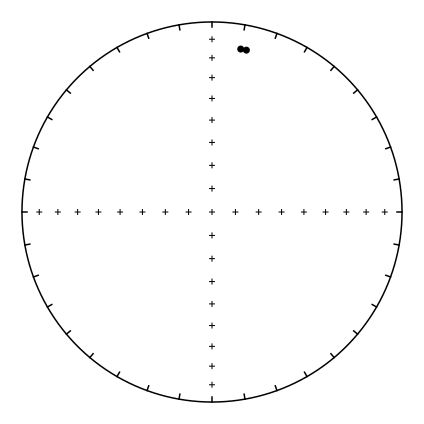

In [6]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(DuBois1957a_sites['dir_dec'].tolist(), DuBois1957a_sites['dir_inc'].tolist(),  markersize = 50)

# plt.legend(loc = 8)
plt.show()

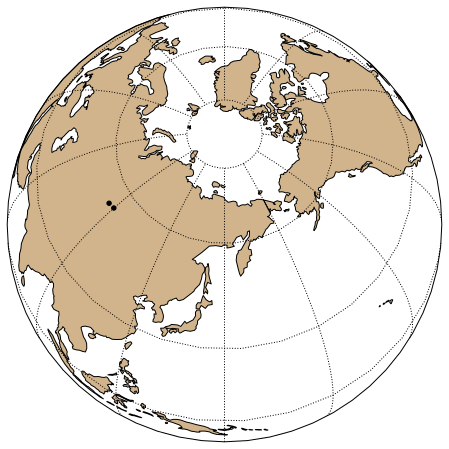

In [7]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, DuBois1957a_sites['vgp_lon'].tolist(),DuBois1957a_sites['vgp_lat'].tolist(), color = 'black')

# plt.legend()
plt.show()

**these might be helpful to be treated as additional site level data to be averaged with other similar age site directions for a 199 Ma or 200 Ma pole**

## Bowker (1960) Holyoke related lava flows in PhD thesis (recalculated by deBoer,  1968)

Bowker in this PhD thesis sampled lava flows from Deerfield, Hampden, Talcott, Holyoke, and North Mountain. Similar to other early studies the data in this thesis work may add to the pool of Holyoke related igneous rocks and be assigned age of ~ 200 Ma.

The data included here are not site-level data, because deBoer in 1968 recalculated into sub-location level means, using sample level data in the appendix of this thesis to derive mean directions for samples, and grouped them by apparent direction differences. **Note that the site mean provided by Bowker in the thesis has rther large uncertainties.** 

Bowker, D. E. (1960). Remanent magnetization of eastern United States Triassic rocks (Doctoral dissertation, Massachusetts Institute of Technology).

In [8]:
Bowker1960a_sites = pd.read_csv('pmag_compiled/Bowker1960a/Bowker1960a_sites.txt', sep = '\t', header = 1)
Bowker1960a_sites['vgp_lon'] = Bowker1960a_sites['PLon'].tolist()
Bowker1960a_sites['vgp_lat'] = Bowker1960a_sites['PLat'].tolist()

Bowker1960a_sites

site        location  dir_dec  dir_inc  dir_k  dir_n_samples  \
0     1       Deerfield     19.0     -1.0    105              8   
1     2       Deerfield     34.0     29.0     24              8   
2     3         Hampden     13.0     47.0     72              8   
3     4         Talcott     15.0     27.0     57              6   
4     5         Talcott      4.0     75.0     22              6   
5     6         Holyoke     15.0     19.0    625              3   
6     7  North Mountain      NaN      NaN     20             73   

   dir_n_specimens  dir_n_total_specimens  dir_tilt_correction  dir_alpha95  \
0               16                     16                  100            5   
1               13                     13                  100           11   
2               12                     12                  100            6   
3                7                      7                  100            9   
4                8                      8                  100           15   
5                5                      5                  100            5   
6              216                    216                  100           10   

   ...  result_type  age age_unit PLon PLat                           note  \
0  ...            i  200       Ma   80   44  recalculated by DeBoer (1968)   
1  ...            i  200       Ma   50   50  recalculated by DeBoer (1968)   
2  ...            i  200       Ma   69   72  recalculated by DeBoer (1968)   
3  ...            i  200       Ma   80   58  recalculated by DeBoer (1968)   
4  ...            i  200       Ma  -67   70  recalculated by DeBoer (1968)   
5  ...            i  200       Ma   75   63  recalculated by DeBoer (1968)   
6  ...            i  200       Ma   77   78  recalculated by DeBoer (1968)   

               group                   citations  vgp_lon vgp_lat  
0  Deerfield_Holyoke  Bowker 1961 MIT PhD thesis       80      44  
1  Deerfield_Holyoke  Bowker 1961 MIT PhD thesis       50      50  
2           Hartford  Bowker 1961 MIT PhD thesis       69      72  
3           Hartford  Bowker 1961 MIT PhD thesis       80      58  
4           Hartford  Bowker 1961 MIT PhD thesis      -67      70  
5  Deerfield_Holyoke  Bowker 1961 MIT PhD thesis       75      63  
6     North_Mountain  Bowker 1961 MIT PhD thesis       77      78  

[7 rows x 27 columns]

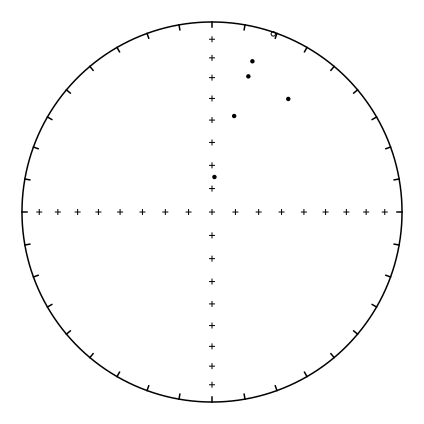

In [9]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Bowker1960a_sites['dir_dec'].tolist(), Bowker1960a_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

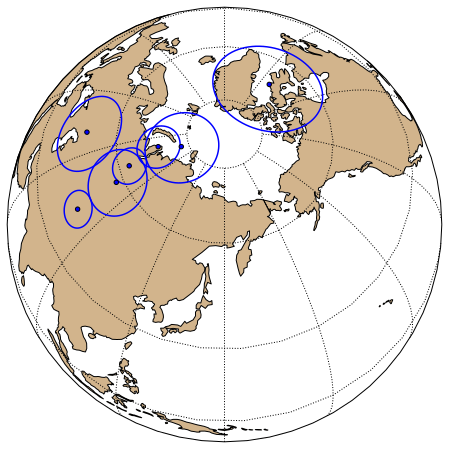

In [10]:
map_axis = ipmag.make_orthographic_map(150, 65)

for i in range(len(Bowker1960a_sites['PLon'])):
    
    ipmag.plot_pole(map_axis,Bowker1960a_sites['PLon'].tolist()[i], Bowker1960a_sites['PLat'].tolist()[i], Bowker1960a_sites['dir_alpha95'].tolist()[i], color = 'blue')

plt.show()

## Opdyke (1961) Watchung flows and intrusives in Newark

Opdyke (1961) with a goal of investigating the degree of inclination error in sediments, sampled the lava flows and intrusives sills in a series of structural basins inthe Appalachians.

The lava flows are named Watchung flows, and are contained in the sedimentary layers. The dolerite intrusions intrudes the sediments and are faulted by Cretaceous faults. The lava and sills are chemically indistinguishable and are different only in texture. 

At the time magnetic property measurement showed the coercivity of the lava and sills is around 20-38 mT, which is likely MD dominated grains. Primary remanence is supported by that the directions after 15 mT cleaning was 50 degrees away from present local field, and are better clustered after tilt correction. The dec and inc in the table probided are already tilt-correcteed, and the a95 values are calculated from k parameter and N of samples using fisher statistics. 

Opdyke, N. D. (1961). The paleomagnetism of the New Jersey Triassic: A field study of the inclination error in red sediments. Journal of Geophysical Research, 66(6), 1941-1949. doi: https://10.1029/jz066i006p01941.

In [11]:
Opdyke1961a_sites = pd.read_csv('pmag_compiled/Opdyke1961a/Opdyke1961a_sites.txt', sep='\t', header = 1)
Opdyke1961a_sites = ipmag.vgp_calc(Opdyke1961a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Opdyke1961a_sites

site           location                    note  dir_dec  dir_inc  dir_k  \
0   W1-1         Somerville          Watchung flows        3       34     85   
1   W1-2  Stoney Brook Road          Watchung flows        3       23     50   
2   W2-1          Far Hills          Watchung flows       18       25    157   
3   W2-2          Far Hills          Watchung flows       19       14    350   
4     W3      Mountain View          Watchung flows       10       31     52   
5     D6         Quakertown            Haycock sill      360       11     21   
6     D7  Baldpate Mountain        small intrusions        4       36     85   
7     D8      Bell Mountain        small intrusions      339       31     31   
8     D9         Rocky Hill           Palisade sill      354       25     27   
9    D10  Sourland Mountain  Sourland Mountain sill      358       31     88   
10   D11  Washington Bridge           Palisade sill        4       30     73   

    dir_n_samples  dir_n_specimens  dir_n_total_specimens  \
0              12               12                     12   
1               8                8                      8   
2              10               10                     10   
3               8                8                      8   
4              12               12                     12   
5              13               13                     13   
6              12               12                     12   
7              12               12                     12   
8              12               12                     12   
9               8                8                      8   
10             12               12                     12   

    dir_tilt_correction  ...  age_unit  dip_trend  dip  \
0                   100  ...        Ma        322   12   
1                   100  ...        Ma        318   12   
2                   100  ...        Ma        108   12   
3                   100  ...        Ma        325   10   
4                   100  ...        Ma        284   12   
5                   100  ...        Ma        290   15   
6                   100  ...        Ma        300   15   
7                   100  ...        Ma        305   16   
8                   100  ...        Ma        336   18   
9                   100  ...        Ma        310   18   
10                  100  ...        Ma        294   12   

                       group                citations paleolatitude  \
0   Orange_Mountain_Palisade  10.1029/jz066i006p01941     18.636898   
1   Orange_Mountain_Palisade  10.1029/jz066i006p01941     11.982503   
2   Orange_Mountain_Palisade  10.1029/jz066i006p01941     13.124268   
3   Orange_Mountain_Palisade  10.1029/jz066i006p01941      7.106060   
4   Orange_Mountain_Palisade  10.1029/jz066i006p01941     16.721861   
5   Orange_Mountain_Palisade  10.1029/jz066i006p01941      5.551151   
6   Orange_Mountain_Palisade  10.1029/jz066i006p01941     19.964629   
7   Orange_Mountain_Palisade  10.1029/jz066i006p01941     16.721861   
8   Orange_Mountain_Palisade  10.1029/jz066i006p01941     13.124268   
9   Orange_Mountain_Palisade  10.1029/jz066i006p01941     16.721861   
10  Orange_Mountain_Palisade  10.1029/jz066i006p01941     16.102114   

      vgp_lat     vgp_lon vgp_lat_rev  vgp_lon_rev  
0   67.886341   97.830044  -67.886341   277.830044  
1   61.231145   99.443639  -61.231145   279.443639  
2   58.264917   70.469869  -58.264917   250.469869  
3   52.541711   73.413405  -52.541711   253.413405  
4   64.308220   83.192710  -64.308220   263.192710  
5   55.081151  105.530000  -55.081151   285.530000  
6   69.378656   94.391129  -69.378656   274.391129  
7   60.205528  148.767376  -60.205528   328.767376  
8   62.249875  117.998635  -62.249875   297.998635  
9   66.308381  109.841493  -66.308381   289.841493  
10  65.010917   95.901610  -65.010917   275.901610  

[11 rows x 30 columns]

In [12]:
Opdyke1961a_sites_Watchung = Opdyke1961a_sites[Opdyke1961a_sites['note'] == 'Watchung flows']
Opdyke1961a_sites_intrusions = Opdyke1961a_sites[Opdyke1961a_sites['note'] != 'Watchung flows']

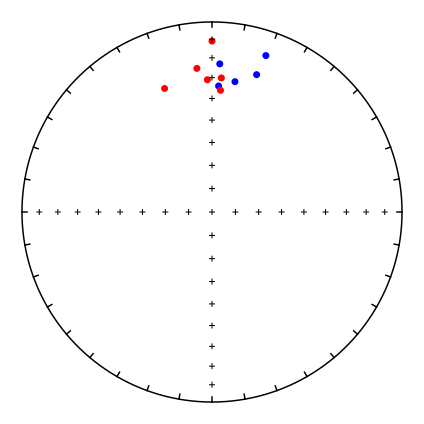

In [13]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Opdyke1961a_sites_Watchung['dir_dec'].tolist(), Opdyke1961a_sites_Watchung['dir_inc'].tolist(), color = 'blue', markersize = 50, label = 'Watchung lavas')
ipmag.plot_di(Opdyke1961a_sites_intrusions['dir_dec'].tolist(), Opdyke1961a_sites_intrusions['dir_inc'].tolist(), color = 'red', markersize = 50, label = 'intrusions')

# plt.legend(loc = 8)
plt.show()

In [14]:
Opdyke1961a_sites_Watchung_mean = ipmag.fisher_mean(Opdyke1961a_sites_Watchung['vgp_lon'].tolist(),Opdyke1961a_sites_Watchung['vgp_lat'].tolist())
Opdyke1961a_sites_Watchung_mean

{'dec': 83.45032798993499,
 'inc': 61.38566798109555,
 'n': 5,
 'r': 4.953427853737615,
 'k': 85.88824696770979,
 'alpha95': 8.302620064419607,
 'csd': 8.74013517669358}

In [15]:
Opdyke1961a_sites_intrusions_mean = ipmag.fisher_mean(Opdyke1961a_sites_intrusions['vgp_lon'].tolist(),Opdyke1961a_sites_intrusions['vgp_lat'].tolist())
Opdyke1961a_sites_intrusions_mean

{'dec': 112.95217883722498,
 'inc': 64.23203481931813,
 'n': 6,
 'r': 5.919416822018725,
 'k': 62.04768942175313,
 'alpha95': 8.571992006621759,
 'csd': 10.283056264896587}

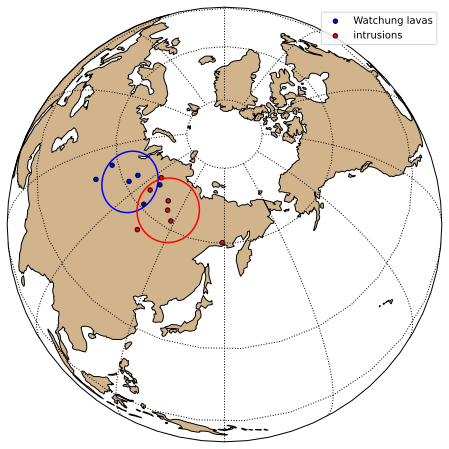

In [16]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Opdyke1961a_sites_Watchung['vgp_lon'].tolist(),Opdyke1961a_sites_Watchung['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis, Opdyke1961a_sites_intrusions['vgp_lon'].tolist(),Opdyke1961a_sites_intrusions['vgp_lat'].tolist(), color = 'red')

ipmag.plot_pole(map_axis, Opdyke1961a_sites_Watchung_mean['dec'], Opdyke1961a_sites_Watchung_mean['inc'], Opdyke1961a_sites_Watchung_mean['alpha95'], color = 'blue', label = 'Watchung lavas')
ipmag.plot_pole(map_axis, Opdyke1961a_sites_intrusions_mean['dec'], Opdyke1961a_sites_intrusions_mean['inc'], Opdyke1961a_sites_intrusions_mean['alpha95'], color = 'red', label = 'intrusions')

plt.legend()
plt.show()

## Irving (1961) Granby (Hampden) and Holyoke lavas in the Massachusetts

Irving and Banks (1961) sampled 5 sites from the Granby and Holyoke lava members of the Newark Group. Two sites are from lavas in the Granby Tuff, which becomes the "posterior (Hampden) sheet farther south". The interpretation here is that the Granby Tuff is similar in age with the Hampden lavas. The study also claimed that the Holyoke lavas are older than the Granby Tuff. However, they also say that the dip of the Granby is 10 degrees steeper than the Holyoke lavas, which is confusing in that if they experienced similar structural motion after emplacement one would expect the older Holyoke lavas to dip more steeply than the Granby. 

AF peak level 15 mT demagnetization were performed and tilt-corrected site mean directions are reported for the 5 sites. Like Opdyke (1961) above, we calculated the a95 of the sites, the $\theta$ reported in the table is 63 percentile instead of a95. 

The age of these units are assigned based on Jourdan (2009), which reports Ar-Ar dates on the Holyoke lavas to be 199.3 $\pm$ 1.2 Ma, and an upper Hampden unit to be 198.6 $\pm$ 2.0 and 199.8 $\pm$ 1.1 Ma. The ages are indistinguishable. Nevertheless, we might be able to combine the poles from these two lava groups and assign a rough age here. to be ~199 Ma.

Irving, E., & Banks, M. R. (1961). Paleomagnetic results from the Upper Triassic lavas of Massachusetts. Journal of Geophysical Research, 66(6), 1935-1939. doi: http://dx.doi.org/10.1029/JZ066i006p01935. 

Jourdan, F., Marzoli, A., Bertrand, H., Cirilli, S., Tanner, L. H., Kontak, D. J., ... & Bellieni, G. (2009). 40Ar/39Ar ages of CAMP in North America: implications for the Triassic–Jurassic boundary and the 40K decay constant bias. Lithos, 110(1-4), 167-180. doi: http://dx.doi.org/10.1016/j.lithos.2008.12.011. 

In [17]:
Irving1961a_sites = pd.read_csv('pmag_compiled/Irving1961a/Irving1961a_sites.txt', sep = '\t', header = 1)
Irving1961a_sites = ipmag.vgp_calc(Irving1961a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',)

Irving1961a_sites_Granby = Irving1961a_sites[Irving1961a_sites['location'] == 'Granby']
Irving1961a_sites_Holyoke = Irving1961a_sites[Irving1961a_sites['location'] == 'Holyoke']

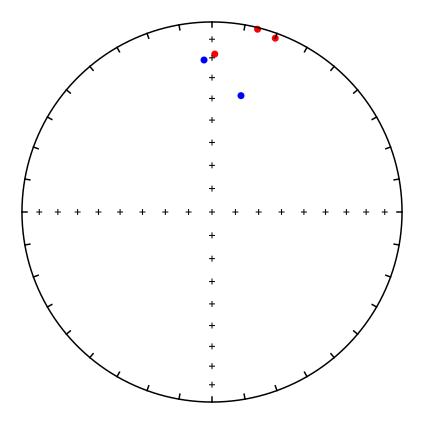

In [18]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Irving1961a_sites_Granby['dir_dec'].tolist(), Irving1961a_sites_Granby['dir_inc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(Irving1961a_sites_Holyoke['dir_dec'].tolist(), Irving1961a_sites_Holyoke['dir_inc'].tolist(), color = 'red',  markersize = 50)

# plt.legend(loc = 8)
plt.show()

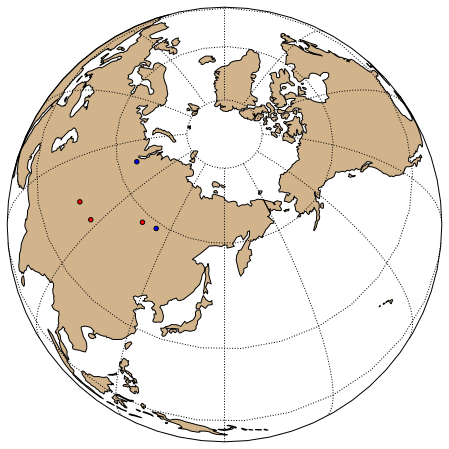

In [19]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Irving1961a_sites_Granby['vgp_lon'].tolist(),Irving1961a_sites_Granby['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis, Irving1961a_sites_Holyoke['vgp_lon'].tolist(),Irving1961a_sites_Holyoke['vgp_lat'].tolist(), color = 'red')

# plt.legend()
plt.show()

**these might be helpful to be treated as additional site level data to be averaged with other similar age site directions for a 199 Ma or 200 Ma pole**

## Beck (1965) diabase intrusions in Southeastern Pennsylvania in the Gettysburg-Newark basin

Beck in 1965 published paleomagnetic data on the diabase intrusions of the southeastern POennsylvania in an integration effort studying Triassic basin. A primary interest of this study is to test wehther the bending (arcuate shaped) of the Triassic Appalachian structure is caused by a later Paleozoic fold associated with the movement of a E-W trending fault. Given the degree of curvature of the structure, one would expect paleomagnetic directional curvature in pmag directions from rock units formed prior to the folding. 

The sampling sites were at regular intervals across the strike of the diabase body. Like Irving (1961) and Opdyke (1961) a peak field of 15 mT was used as optimum demagnetizing field for AF demagnetizing these rocks. 

**Beck in this paper argued that the data presented in Opdyke (1961) may have significant amount of unstable magnetization and rock samples may not have averaged out PSV.**

**Beck also used statistical methods proposed by Creer (1962) to assess the dispersion of the directions from these Pennsylvania diabase. He noted that the dispersion is too low than expected, interpreting that they may not average out PSV properly. However, he then referred to the similarity between these poles with those from Opdyke (1961) in New Jersey and Moenkopi formation sediments, suggestign that large scale correspondance in direction might suggest substantial PSV have been captured. And he argues that the PSV degree may vary through time, so Creer (1962)'s assumption of it being constant throughout geologic time might be incorrect. **

Beck attributed the linear distributions of paleomagnetic directions from sites in this study before structural corrections as a reflecting the tectonic rotations that are associated with the arcuate shape of the Appalachians. 

The Gettysbug-Newark basin is the largest of the Triassic basins of the eastern US. The prevailing dip in this belt of Triassic outcrop in Pennsylvania is toward N or NW. 

In [20]:
Beck1965a_sites = pd.read_csv('pmag_compiled/Beck1965a/Beck1965a_sites.txt', sep='\t', header = 1)
Beck1965a_sites = Beck1965a_sites[Beck1965a_sites['dir_alpha95'] < 15]
Beck1965a_sites = ipmag.vgp_calc(Beck1965a_sites,  tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_tc='dec_tc',
    inc_tc='inc_tc')

Beck1965a_sites_Birdsboro = Beck1965a_sites[Beck1965a_sites['location'] == 'Birdsboro']
Beck1965a_sites_Gettysburg = Beck1965a_sites[Beck1965a_sites['location'] == 'Gettysburg']
Beck1965a_sites_Yorkhaven = Beck1965a_sites[Beck1965a_sites['location'] == 'Yorkhaven']

**plot pre-tilt corrected directions**

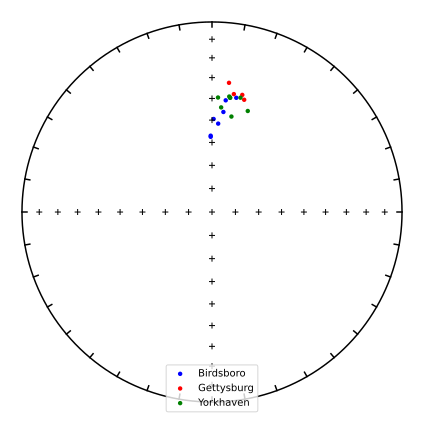

In [21]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Beck1965a_sites_Birdsboro['dir_dec'].tolist(), Beck1965a_sites_Birdsboro['dir_inc'].tolist(), color = 'blue', label = 'Birdsboro')
ipmag.plot_di(Beck1965a_sites_Gettysburg['dir_dec'].tolist(), Beck1965a_sites_Gettysburg['dir_inc'].tolist(), color = 'red', label = 'Gettysburg')
ipmag.plot_di(Beck1965a_sites_Yorkhaven['dir_dec'].tolist(), Beck1965a_sites_Yorkhaven['dir_inc'].tolist(), color = 'green', label = 'Yorkhaven')

plt.legend(loc = 8)
plt.show()

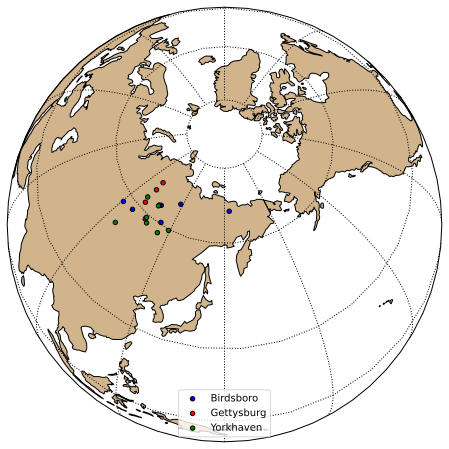

In [22]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Beck1965a_sites_Birdsboro['vgp_lon'].tolist(), Beck1965a_sites_Birdsboro['vgp_lat'].tolist(), color = 'blue', label = 'Birdsboro')
ipmag.plot_vgp(map_axis, Beck1965a_sites_Gettysburg['vgp_lon'].tolist(), Beck1965a_sites_Gettysburg['vgp_lat'].tolist(), color = 'red', label = 'Gettysburg')
ipmag.plot_vgp(map_axis, Beck1965a_sites_Yorkhaven['vgp_lon'].tolist(), Beck1965a_sites_Yorkhaven['vgp_lat'].tolist(), color = 'green', label = 'Yorkhaven')

plt.legend(loc = 8)
plt.show()

## Beck (1972) more diabase units in Pennsylvania (continued from 1965 study)

This is a following study after Beck (1965) in Southeastern Pennsylvania. One more intrusion of Quakerton is included here on top of more samples in the Birdsboro, Gettysburg, Yorkhaven. Again this study addressed the units in the region dips to the N to NW. The structural orientation data are presented in the data table together with the paleomagnetic direction already corrected. 

AF cleaning of peak field up to 15 mT was used. It is interesting that then Beck proposed to filter paleomagnetic data by a95 < 15. 
no site 49, 83 data in the table. 

Beck Jr, M. E. (1972). Paleomagnetism of Upper Triassic diabase from southeastern Pennsylvania: Further results. Journal of Geophysical Research, 77(29), 5673-5687. doi: https://doi.org/10.1029/JB077i029p05673.

In [23]:
Beck1972a_sites = pd.read_csv('pmag_compiled/Beck1972a/Beck1972a_sites.txt', sep='\t', header = 1)
Beck1972a_sites = Beck1972a_sites[Beck1972a_sites['dir_alpha95'].notnull()]
Beck1972a_sites = ipmag.vgp_calc(Beck1972a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')

Beck1972a_sites = Beck1972a_sites[Beck1972a_sites['dir_alpha95'] < 15]

Beck1972a_sites_Birdsboro = Beck1972a_sites[Beck1972a_sites['location'] == 'Birdsboro']
Beck1972a_sites_Gettysburg = Beck1972a_sites[Beck1972a_sites['location'] == 'Gettysburg']
Beck1972a_sites_Yorkhaven = Beck1972a_sites[Beck1972a_sites['location'] == 'Yorkhaven']
Beck1972a_sites_Quakerton = Beck1972a_sites[Beck1972a_sites['location'] == 'Quakerton']

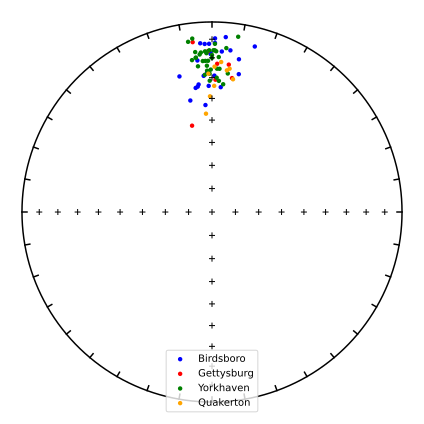

In [24]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Beck1972a_sites_Birdsboro['dir_dec'].tolist(), Beck1972a_sites_Birdsboro['dir_inc'].tolist(), color = 'blue', label = 'Birdsboro')
ipmag.plot_di(Beck1972a_sites_Gettysburg['dir_dec'].tolist(), Beck1972a_sites_Gettysburg['dir_inc'].tolist(), color = 'red', label = 'Gettysburg')
ipmag.plot_di(Beck1972a_sites_Yorkhaven['dir_dec'].tolist(), Beck1972a_sites_Yorkhaven['dir_inc'].tolist(), color = 'green', label = 'Yorkhaven')
ipmag.plot_di(Beck1972a_sites_Quakerton['dir_dec'].tolist(), Beck1972a_sites_Quakerton['dir_inc'].tolist(), color = 'orange', label = 'Quakerton')

plt.legend(loc = 8)
plt.show()

In [25]:
Beck1972a_sites_Birdsboro_mean = ipmag.fisher_mean(Beck1972a_sites_Birdsboro['vgp_lon'].tolist(), Beck1972a_sites_Birdsboro['vgp_lat'].tolist())
Beck1972a_sites_Gettysburg_mean = ipmag.fisher_mean(Beck1972a_sites_Gettysburg['vgp_lon'].tolist(), Beck1972a_sites_Gettysburg['vgp_lat'].tolist())
Beck1972a_sites_Yorkhaven_mean = ipmag.fisher_mean(Beck1972a_sites_Yorkhaven['vgp_lon'].tolist(), Beck1972a_sites_Yorkhaven['vgp_lat'].tolist())
Beck1972a_sites_Quakerton_mean = ipmag.fisher_mean(Beck1972a_sites_Quakerton['vgp_lon'].tolist(), Beck1972a_sites_Quakerton['vgp_lat'].tolist())

print(Beck1972a_sites_Birdsboro_mean)
print(Beck1972a_sites_Gettysburg_mean)
print(Beck1972a_sites_Yorkhaven_mean)
print(Beck1972a_sites_Quakerton_mean)

{'dec': 105.01255937154384, 'inc': 62.234168387719436, 'n': 25, 'r': 24.71662884879238, 'k': 84.69457775684299, 'alpha95': 3.1638452529310213, 'csd': 8.801510578382752}
{'dec': 103.16714654047259, 'inc': 64.8323029890329, 'n': 7, 'r': 6.8879623350111485, 'k': 53.55341884889373, 'alpha95': 8.323241903730958, 'csd': 11.068567507374615}
{'dec': 105.27509485231838, 'inc': 60.77033831092985, 'n': 37, 'r': 36.84650582366755, 'k': 234.53658542737188, 'alpha95': 1.540622865082054, 'csd': 5.289074932026319}
{'dec': 98.76996214029587, 'inc': 66.25252000847622, 'n': 9, 'r': 8.944464341821392, 'k': 144.0515924790394, 'alpha95': 4.304071584833856, 'csd': 6.748791126100324}


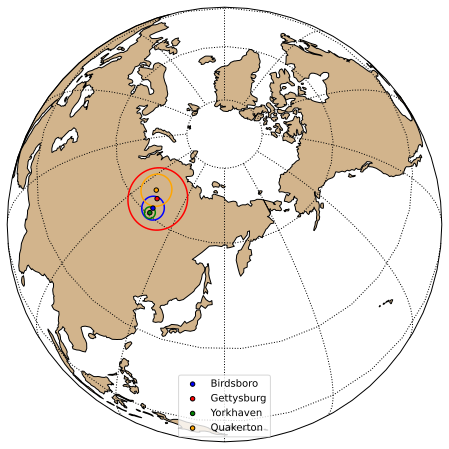

In [26]:
map_axis = ipmag.make_orthographic_map(150, 65)

# ipmag.plot_vgp(map_axis, Beck1972a_sites_Birdsboro['vgp_lon'].tolist(), Beck1972a_sites_Birdsboro['vgp_lat'].tolist(), 
#                color = 'blue', label = 'Birdsboro')
# ipmag.plot_vgp(map_axis, Beck1972a_sites_Gettysburg['vgp_lon'].tolist(), Beck1972a_sites_Gettysburg['vgp_lat'].tolist(), 
#                color = 'red', label = 'Gettysburg')
# ipmag.plot_vgp(map_axis, Beck1972a_sites_Yorkhaven['vgp_lon'].tolist(), Beck1972a_sites_Yorkhaven['vgp_lat'].tolist(), 
#                color = 'green', label = 'Yorkhaven')
# ipmag.plot_vgp(map_axis, Beck1972a_sites_Quakerton['vgp_lon'].tolist(), Beck1972a_sites_Quakerton['vgp_lat'].tolist(), 
#                color = 'orange', label = 'Quakerton')

ipmag.plot_pole(map_axis, Beck1972a_sites_Birdsboro_mean['dec'], Beck1972a_sites_Birdsboro_mean['inc'], 
                Beck1972a_sites_Birdsboro_mean['alpha95'], color = 'blue', label = 'Birdsboro')
ipmag.plot_pole(map_axis, Beck1972a_sites_Gettysburg_mean['dec'], Beck1972a_sites_Gettysburg_mean['inc'], 
                Beck1972a_sites_Gettysburg_mean['alpha95'], color = 'red', label = 'Gettysburg')
ipmag.plot_pole(map_axis, Beck1972a_sites_Yorkhaven_mean['dec'], Beck1972a_sites_Yorkhaven_mean['inc'], 
                Beck1972a_sites_Yorkhaven_mean['alpha95'], color = 'green', label = 'Yorkhaven')
ipmag.plot_pole(map_axis, Beck1972a_sites_Quakerton_mean['dec'], Beck1972a_sites_Quakerton_mean['inc'], 
                Beck1972a_sites_Quakerton_mean['alpha95'], color = 'orange', label = 'Quakerton')

plt.legend(loc = 8)
plt.show()

**Such well grouped site mean paleomagnetic directions/poles across the four intrusive units in Pennsylvania lay quite robust confidence for using this pole position to pair with geochronology**

## Combine Beck (1965) and Beck (1972) Southeastern Pennsylvania diabase intrusions

In [27]:
Southeastern_Penn_diabase_Birdsboro = pd.concat([Beck1965a_sites_Birdsboro, Beck1972a_sites_Birdsboro])
Southeastern_Penn_diabase_Gettysburg = pd.concat([Beck1965a_sites_Gettysburg, Beck1972a_sites_Gettysburg])
Southeastern_Penn_diabase_Yorkhaven = pd.concat([Beck1965a_sites_Yorkhaven, Beck1972a_sites_Yorkhaven])
Southeastern_Penn_diabase_Quakerton = Beck1972a_sites_Quakerton

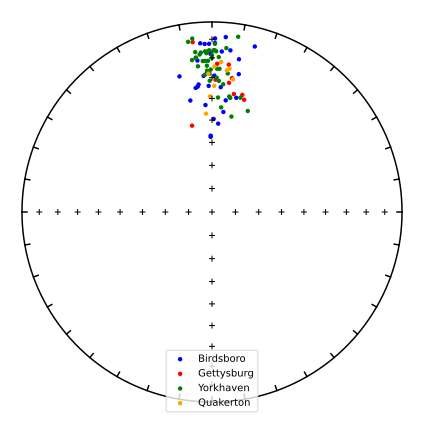

In [28]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Southeastern_Penn_diabase_Birdsboro['dir_dec'].tolist(), Southeastern_Penn_diabase_Birdsboro['dir_inc'].tolist(), 
              color = 'blue', label = 'Birdsboro')
ipmag.plot_di(Southeastern_Penn_diabase_Gettysburg['dir_dec'].tolist(), Southeastern_Penn_diabase_Gettysburg['dir_inc'].tolist(), 
              color = 'red', label = 'Gettysburg')
ipmag.plot_di(Southeastern_Penn_diabase_Yorkhaven['dir_dec'].tolist(), Southeastern_Penn_diabase_Yorkhaven['dir_inc'].tolist(), 
              color = 'green', label = 'Yorkhaven')
ipmag.plot_di(Southeastern_Penn_diabase_Quakerton['dir_dec'].tolist(), Southeastern_Penn_diabase_Quakerton['dir_inc'].tolist(), 
              color = 'orange', label = 'Quakerton')

plt.legend(loc = 8)
plt.show()

In [29]:
Southeastern_Penn_diabase_Birdsboro_mean = ipmag.fisher_mean(Southeastern_Penn_diabase_Birdsboro['vgp_lon'].tolist(), 
                                                             Southeastern_Penn_diabase_Birdsboro['vgp_lat'].tolist())
Southeastern_Penn_diabase_Gettysburg_mean = ipmag.fisher_mean(Southeastern_Penn_diabase_Gettysburg['vgp_lon'].tolist(), 
                                                              Southeastern_Penn_diabase_Gettysburg['vgp_lat'].tolist())
Southeastern_Penn_diabase_Yorkhaven_mean = ipmag.fisher_mean(Southeastern_Penn_diabase_Yorkhaven['vgp_lon'].tolist(), 
                                                             Southeastern_Penn_diabase_Yorkhaven['vgp_lat'].tolist())
Southeastern_Penn_diabase_Quakerton_mean = ipmag.fisher_mean(Southeastern_Penn_diabase_Quakerton['vgp_lon'].tolist(), 
                                                             Southeastern_Penn_diabase_Quakerton['vgp_lat'].tolist())

print(Southeastern_Penn_diabase_Birdsboro_mean)
print(Southeastern_Penn_diabase_Gettysburg_mean)
print(Southeastern_Penn_diabase_Yorkhaven_mean)
print(Southeastern_Penn_diabase_Quakerton_mean)

{'dec': 106.00831634595848, 'inc': 62.465063211235126, 'n': 32, 'r': 31.623310939157847, 'k': 82.29599216577766, 'alpha95': 2.817192550733021, 'csd': 8.928853063985189}
{'dec': 102.27025603537994, 'inc': 64.52927376369128, 'n': 11, 'r': 10.87675364283873, 'k': 81.13830080117397, 'alpha95': 5.099258172848229, 'csd': 8.992326447227596}
{'dec': 105.50916509139056, 'inc': 60.622020690596855, 'n': 45, 'r': 44.8108416931988, 'k': 232.60939867813198, 'alpha95': 1.3974261611291918, 'csd': 5.310939933337114}
{'dec': 98.76996214029587, 'inc': 66.25252000847622, 'n': 9, 'r': 8.944464341821392, 'k': 144.0515924790394, 'alpha95': 4.304071584833856, 'csd': 6.748791126100324}


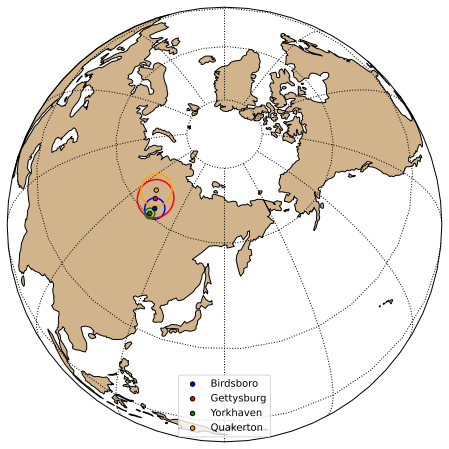

In [30]:
map_axis = ipmag.make_orthographic_map(150, 65)

# ipmag.plot_vgp(map_axis, Southeastern_Penn_diabase_Birdsboro['vgp_lon'].tolist(), Southeastern_Penn_diabase_Birdsboro['vgp_lat'].tolist(), 
#                color = 'blue', label = 'Birdsboro')
# ipmag.plot_vgp(map_axis, Southeastern_Penn_diabase_Gettysburg['vgp_lon'].tolist(), Southeastern_Penn_diabase_Gettysburg['vgp_lat'].tolist(), 
#                color = 'red', label = 'Gettysburg')
# ipmag.plot_vgp(map_axis, Southeastern_Penn_diabase_Yorkhaven['vgp_lon'].tolist(), Southeastern_Penn_diabase_Yorkhaven['vgp_lat'].tolist(), 
#                color = 'green', label = 'Yorkhaven')
# ipmag.plot_vgp(map_axis, Southeastern_Penn_diabase_Quakerton['vgp_lon'].tolist(), Southeastern_Penn_diabase_Quakerton['vgp_lat'].tolist(), 
#                color = 'orange', label = 'Quakerton')

ipmag.plot_pole(map_axis, Southeastern_Penn_diabase_Birdsboro_mean['dec'], Southeastern_Penn_diabase_Birdsboro_mean['inc'], 
                Southeastern_Penn_diabase_Birdsboro_mean['alpha95'], color = 'blue', label = 'Birdsboro')
ipmag.plot_pole(map_axis, Southeastern_Penn_diabase_Gettysburg_mean['dec'], Southeastern_Penn_diabase_Gettysburg_mean['inc'], 
                Southeastern_Penn_diabase_Gettysburg_mean['alpha95'], color = 'red', label = 'Gettysburg')
ipmag.plot_pole(map_axis, Southeastern_Penn_diabase_Yorkhaven_mean['dec'], Southeastern_Penn_diabase_Yorkhaven_mean['inc'], 
                Southeastern_Penn_diabase_Yorkhaven_mean['alpha95'], color = 'green', label = 'Yorkhaven')
ipmag.plot_pole(map_axis, Southeastern_Penn_diabase_Quakerton_mean['dec'], Southeastern_Penn_diabase_Quakerton_mean['inc'], 
                Southeastern_Penn_diabase_Quakerton_mean['alpha95'], color = 'orange', label = 'Quakerton')

plt.legend(loc = 8)
plt.show()

## deBoer (1967) Dikes from the basaltic dikes (diabase) in the Appalachians

This is one of the early paleomagnetic studies of the intrusives in the Appalachian area focusing on the Mesozoic paleomagnetic pole position of NA. The dikes are steeply inclined with no preferred dip directions, and field observations show they are almost symmetrically dipped on both sides. This leads to interpretation that minimal post formation tilting happened, although a rotations along the dike planes cannot be rejected. Nevertheless, that the dike orientations are quite distributed in a variety of directions lend some support that there hasn't been significant regional tilting. 

The dikes are "narrow" from meters to a hundred meters in wide, thus was inferred as "narrow dikes" by Smith (1979). They are basaltic, augite-laboradorite in composition. Magnetite and ilmenite reported as both in skeletal crystals to subhedral to anhedral groundmass. 

The provided data table in the publication already grouped the 80 dikes collected into locations, specifically county level location under state locations. Although the groped site means have relatively low a95 in most "sites", this grouping method is nevertheless not ideal. Here we will use the provided directions and see whether they are a good grouping anyways by comparing to other data developed of similar age in similar region.

**According to Smith (1976) which included personal communication with deBoer in 1975, the Connecticut state sites in this study (collected from Bridgeport and Higganum) do not agree with the later samples collected by Smith (1976), and that the disagreement in directions might be an issue with the AF cleaning procedure which might have erased excessive amount of TRM and making the direction analyses poor in resolution. Nevertheless, descriptions in the text in this study shows that a peak field of 70 mT was used on the specimens (because 15 mT demgnetization did not help with decreasing direction scatter), and the scatter decreased at 10-50 mT cleaning. In today's view, this is considered a better approach in that they seeked to performed higher level demagnetization and looked for directions after the direction vectors stop rotating. I consider the data here still to be valuable to this compilation.**

De Boer, J. (1967). Paleomagnetic‐tectonic study of Mesozoic dike swarms in the Appalachians. Journal of Geophysical Research, 72(8), 2237-2250. doi:10.1029/jz072i008p02237.

In [31]:
deBoer1967a_sites = pd.read_csv('pmag_compiled/deBoer1967a/deBoer1967a_sites.txt', sep = '\t', header = 1)
deBoer1967a_sites = ipmag.vgp_calc(deBoer1967a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
deBoer1967a_sites = deBoer1967a_sites[deBoer1967a_sites['dir_alpha95'] < 15]
deBoer1967a_sites

site                                           location  dir_dec  dir_inc  \
0     1                                           Piedmont      340       25   
1     2                                   Deep River basin      342       31   
2     3                                     Danville basin      333       32   
4     5  Bent Creek + Warren basin + Nelson County + Fa...      340       36   
5     6                                     Augusta County      347       37   
6     7                                   Gettysburg basin      352       40   
7     8                                       Newark basin      346       41   
8     9                                  Connecticut state      343       38   

   dir_k  dir_n_samples  dir_n_specimens  dir_n_total_specimens  \
0     37             14               21                     21   
1     26             26               48                     48   
2     31              8               15                     15   
4     44             22               37                     37   
5     65              7               13                     13   
6     47             12               24                     24   
7     61             10               17                     17   
8    107             16               39                     39   

   dir_tilt_correction  dir_alpha95  ...  result_type  age age_unit  \
0                    0            8  ...            i  200       Ma   
1                    0            7  ...            i  200       Ma   
2                    0           12  ...            i  200       Ma   
4                    0            6  ...            i  200       Ma   
5                    0            8  ...            i  200       Ma   
6                    0           10  ...            i  200       Ma   
7                    0           10  ...            i  200       Ma   
8                    0            7  ...            i  200       Ma   

                          group                citations paleolatitude  \
0                    Piedmont_Y  10.1029/jz072i008p02237     13.124268   
1        Hook_Deep_River_Butner  10.1029/jz072i008p02237     16.721861   
2                    Piedmont_Y  10.1029/jz072i008p02237     17.350615   
4                    Piedmont_Y  10.1029/jz072i008p02237     19.964629   
5                    Piedmont_Y  10.1029/jz072i008p02237     20.645256   
6  Gettysburg_Newark_York_Haven  10.1029/jz072i008p02237     22.760476   
7  Gettysburg_Newark_York_Haven  10.1029/jz072i008p02237     23.491856   
8                    Piedmont_Y  10.1029/jz072i008p02237     21.337745   

     vgp_lat     vgp_lon  vgp_lat_rev vgp_lon_rev  
0  62.679571  143.029768   -62.679571  323.029768  
1  66.684929  148.895794   -66.684929  328.895794  
2  59.433336  158.942005   -59.433336  338.942005  
4  65.307297  151.810359   -65.307297  331.810359  
5  69.321495  137.592675   -69.321495  317.592675  
6  71.477610  126.827479   -71.477610  306.827479  
7  69.316858  143.915493   -69.316858  323.915493  
8  65.262951  148.601941   -65.262951  328.601941  

[8 rows x 27 columns]

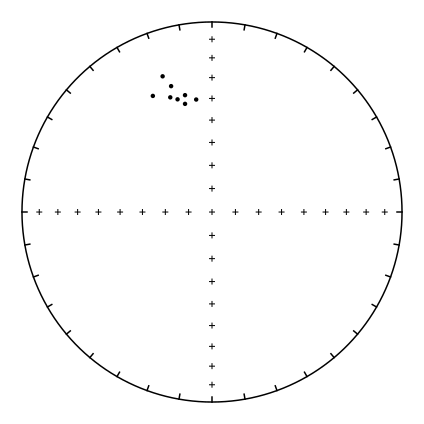

In [32]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(deBoer1967a_sites['dir_dec'].tolist(), deBoer1967a_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

In [33]:
deBoer1967a_sites_vgp_mean = ipmag.fisher_mean(deBoer1967a_sites['vgp_lon'].tolist(),deBoer1967a_sites['vgp_lat'].tolist())
deBoer1967a_sites_vgp_mean

{'dec': 146.04658551728636,
 'inc': 66.43813496679239,
 'n': 8,
 'r': 7.968280949587526,
 'k': 220.68756501131375,
 'alpha95': 3.736928679746198,
 'csd': 5.4525051877389625}

143.91549322730293 69.31685767312004


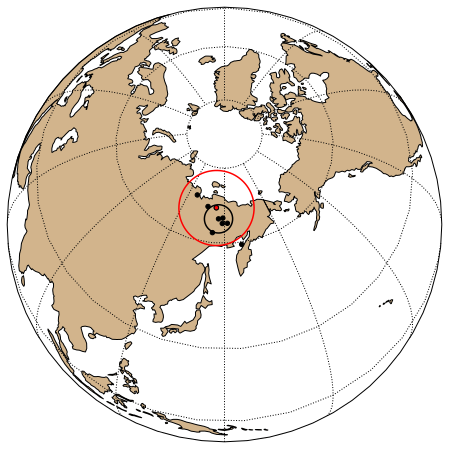

In [34]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,deBoer1967a_sites['vgp_lon'].tolist(),deBoer1967a_sites['vgp_lat'].tolist())
ipmag.plot_pole(map_axis,deBoer1967a_sites_vgp_mean['dec'],deBoer1967a_sites_vgp_mean['inc'], deBoer1967a_sites_vgp_mean['alpha95'])

for i in range(len(deBoer1967a_sites['vgp_lon'].tolist())):
    if deBoer1967a_sites['location'].tolist()[i] == 'Newark basin':
        print(deBoer1967a_sites['vgp_lon'].tolist()[i], deBoer1967a_sites['vgp_lat'].tolist()[i])
        ipmag.plot_pole(map_axis,deBoer1967a_sites['vgp_lon'].tolist()[i], deBoer1967a_sites['vgp_lat'].tolist()[i], 
                        deBoer1967a_sites['dir_alpha95'].tolist()[i], color = 'red')


plt.show()

Note this pole position is way too easterly when comparing to the pole position developed by Smith and Noltimier (1979) shown below. This may be attributed to the limited number of sites. However, considering a total of more than a hundered of samples were used and the site mean directions trend more easterly, this may also, very likely be interpreted as that the dikes in this study is distinct from the magmatism that emplaced those in Smith and Noltimier (1979) intrusives. In addition, the Newark basin one may be incorporated to the average directions for Smith and Noltimier (1979) compilation, since the pole position, considering the quite large a95, can be interpreted to be similar to that of the West Rock vgp. 

My current interpretation considering this tight cluster of 8 "sites" in this study which is more eaterly than those in the S & N (1979) and through comparison between these poles to the polar wander path by Gordon et al., 1984 and Irving and Irving 1982 as is shown in Kent & Irving (2010), that these dikes sampled in this study is likely of younger age than those from the S & N (1979). Unless a substantial structural corrections on all these dikes from all Appalachian area, which is unlikely given the field observations that the dips of the dikes are symmetric, the fact that these poles are far east than those from the Hartford Basin is likely indication of younger age. 

**The Ar/Ar dates of 173 Ma and 168 Ma reported by Sutter and Smith (1979) might be better age assignment for these dikes than those in S & N (1979).** 

## deBoer (1968) volcanics in the Central Appalachians (Connecticut Valley)

Paleomagnetic study similar to intrusives of Smith and Noltimier (1979); extrusives similar to Prevot (1989). 
Not site level data, just grouped data by location. No site location information, or good age constraints. All cited ages range from 190 Ma to 200 Ma.

The lack of site level data limit our ability to reproduce the grouping shown in Smith and Noltimier (1979). 

In [132]:
deBoer1968a_sites = pd.read_csv('pmag_compiled/deBoer1968a/deBoer1968a_sites.txt', sep = '\t', header = 1)
deBoer1968a_sites = deBoer1968a_sites[deBoer1968a_sites['dir_alpha95'] < 15]
deBoer1968a_sites

site   location  dir_dec  dir_inc  dir_k  dir_n_samples  dir_n_specimens  \
0     1    Talcott       18       12    185            111              111   
1     2    Holyoke       12       25    146            150              150   
2     3    Hampden        4       43    102            146              146   
3     4  West Rock        9       29    136             40               40   
4     5    Hampden        0       49     34             54               54   
5     6  Mt Carmel       10       26     32             67               67   
6     7   Cheshire        1       47     31             41               41   

   dir_n_total_specimens  dir_tilt_correction  dir_alpha95  ...  lithologies  \
0                    111                    0            4  ...       Basalt   
1                    150                    0            3  ...       Basalt   
2                    146                    0            4  ...       Basalt   
3                     40                    0            4  ...       Basalt   
4                     54                    0            7  ...       Basalt   
5                     67                    0            4  ...       Basalt   
6                     41                    0            4  ...       Basalt   

         method_codes result_quality result_type  age age_unit vgp_lon  \
0  LT-AF-Z:DE-BLANKET              g           i  200       Ma      78   
1  LT-AF-Z:DE-BLANKET              g           i  200       Ma      83   
2  LT-AF-Z:DE-BLANKET              g           i  200       Ma      92   
3  LT-AF-Z:DE-BLANKET              g           i  200       Ma      89   
4  LT-AF-Z:DE-BLANKET              g           i  200       Ma     106   
5  LT-AF-Z:DE-BLANKET              g           i  200       Ma      87   
6  LT-AF-Z:DE-BLANKET              g           i  200       Ma     103   

  vgp_lat                         group                citations  
0      51                      Hartford  10.1029/jz072i008p02237  
1      60             Deerfield_Holyoke  10.1029/jz072i008p02237  
2      73                      Hartford  10.1029/jz072i008p02237  
3      63                      Hartford  10.1029/jz072i008p02237  
4      79                      Hartford  10.1029/jz072i008p02237  
5      61                      Hartford  10.1029/jz072i008p02237  
6      76  Gettysburg_Newark_York_Haven  10.1029/jz072i008p02237  

[7 rows x 24 columns]

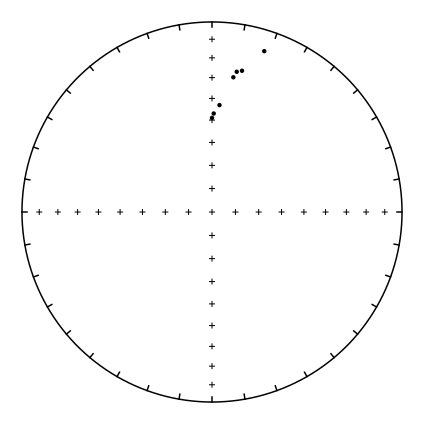

In [36]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(deBoer1968a_sites['dir_dec'].tolist(), deBoer1968a_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

In [37]:
deBoer1968a_sites_vgp_mean = ipmag.fisher_mean(deBoer1968a_sites['vgp_lon'].tolist(),deBoer1968a_sites['vgp_lat'].tolist())
deBoer1968a_sites_vgp_mean

{'dec': 87.763130886251,
 'inc': 66.37330667217505,
 'n': 7,
 'r': 6.894990136853106,
 'k': 57.13748994803305,
 'alpha95': 8.05340850926027,
 'csd': 10.715796067074482}

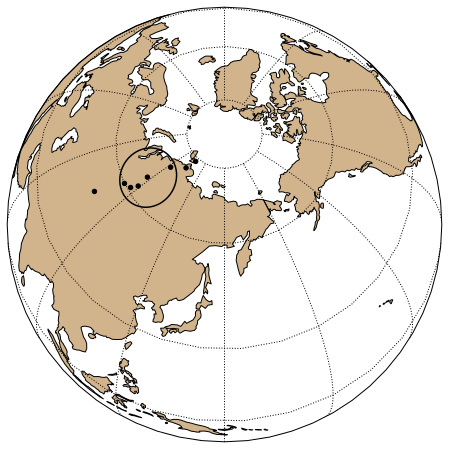

In [38]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,deBoer1968a_sites['vgp_lon'].tolist(),deBoer1968a_sites['vgp_lat'].tolist())
ipmag.plot_pole(map_axis,deBoer1968a_sites_vgp_mean['dec'],deBoer1968a_sites_vgp_mean['inc'], deBoer1968a_sites_vgp_mean['alpha95'])

plt.show()

## Rigotti (1976 thesis, 1978 publication using thesis data) Palisade diabase sills 

Inspired by interests in the secular variation and cooling effect on paleomagnetic directions of intrusive units over long period of time, Rigotti did this pilot research in sampling the Palisade sills in New Jersey. The sills is 1000 feet (300 meters) thick and was dated to be about 192 Ma according to Erickson and Kulp, 1961; Dallmeyer, 1975. Specifically, K-Ar ages reported by Dallmeyer (1975) show ages of 192 ± 9 for the upper chilled zone and 193 ± 9 Ma for the lower zone.  Outcropping along the Hudson River for about 50 miles, the sills intrudes the Newark Formation. Specifically, the uppermost Lockatung Formation and the basal lockatong Formation of the Newark Series. The sills are composed of tholeiitic diabase.

Standard paleomagnetic cores were collected from the sills and AF demagnetized up to 30 mT (a few up to 120 mT) and some were thermally demagnetized. Curie temperature of 550-580 degree C suggest dominant magnetic carrier of Fe-low Ti oxides. 

The structural correlation along paired with good resolution paleomagnetic data from Newark Formation is indication that the date of the sill might be younger than the 192 Ma. 

The appendix table included in this dissertation work is the sample level measurement data following AF demagnetization up to 30 mT. It is a large collection of data and only a mean pole position without concentration parameters are provided. lon = 74.5, lat = 97.6 

This mean pole position is very similar to those derived from the Newark basin, Hartford basin, and the Appalachians. 

If it turns out that re-compiling and analyzing these data will be of significant importance of refining the Monster Shift pole path, we will compile the sample files for these samples involved in the dissertation and make better use of these data. 

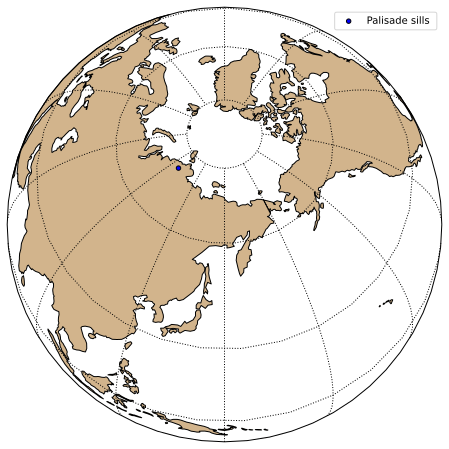

In [39]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, 97.6, 74.5, color = 'blue', label = 'Palisade sills ')

plt.legend()
plt.show()

## Smith (1976) diabase dikes and sills in Connecticut and Maryland

Up to this time there are quite a good amount of paleomagnetic data developed through the Pennsylvanian-Connecticut-Maryland area. The goal of this study was to examine the paleomagnetic pole positions relationships between those from different intrusive units. One argument made in the paper refers back to the PSV degree being too small compared to statistical expectations described in Beck (1965), and argue that the low dispersion might be caused by "homogenization" of magnetic directions during low-temperature oxidation of titanomagnetite to titanomaghemite over a prolonged period that erased a large amount of dispersion originally recorded in rocks through secular variation. 

The Buttress, Higganum, Fairhaven, Bridgeport, and Cross Rock dikes outcrop in central Connecticut, trending N10-20E. The Cross Rock dike trends E-W. The Bridgeport and Higganum are west and east of Hartford basin, but the Cross Rocka dn Fairhaven only within the basin。 The Buttress transects the basin and piedmont. 

AF cleaning with optimum field of 15 mT but up to 20 mT, and thermal demagnetization on 48 specimens with temperature up to 625 degree C were used for demagnetization and direction analyses. 

Data table provided structural orientations and tilt-corrected directional data. Some sites need correction while some don't. So in the compilation there is a 'dec_tc' and a 'inc_tc' column with corrected data and copied data for sites without correction. So should use the tc columns to calculate for poles. The dip_trend and dip columns are for the structural data and shows 0, 0 if there is no correction reported. Note that there are four sites with "estimated" structural data and the directions may be suspicious.

In [40]:
Smith1976a_sites = pd.read_csv('pmag_compiled/Smith1976a/Smith1976a_sites.txt', sep = '\t', header = 1)
Smith1976a_sites = Smith1976a_sites[Smith1976a_sites['dir_alpha95'] < 15]

# Smith1976a_sites = ipmag.vgp_calc(Smith1976a_sites, tilt_correction='no',
#     site_lon='lon',
#     site_lat='lat',
#     dec_is='dir_dec',
#     inc_is='dir_inc')

Smith1976a_sites = ipmag.vgp_calc(Smith1976a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')

Smith1976a_sites

site    location  dir_dec  dir_inc  dec_tc  inc_tc  dir_k  dir_n_samples  \
0    BD-1    Buttress      9.2     50.6     9.2    50.6    270              7   
1    BD-2    Buttress      0.3     36.0     0.3    36.0    470              8   
2    BD-3    Buttress      6.5     40.0     6.5    40.0    458              7   
3    BD-4    Buttress     26.2     51.6    26.2    51.6     46             14   
4    BD-5    Buttress      7.2     47.2    36.8    48.6     71              9   
..    ...         ...      ...      ...     ...     ...    ...            ...   
67  FD-10   Frederick      9.9     41.5   359.7    32.7    474             14   
68  FD-11   Frederick     16.7     38.4     3.6    20.1    196             17   
69   GS-1  Gettysburg     12.6     31.3     5.4    18.4    542              8   
70   GS-2  Gettysburg      8.6     33.0     1.6    18.9    699              7   
71   GS-3  Gettysburg     10.0     32.7     2.6    19.4   1116              8   

    dir_n_specimens  dir_n_total_specimens  ...  dir_dip  dip  note  \
0                 7                      7  ...        0    0   NaN   
1                 8                      8  ...        0    0   NaN   
2                 7                      7  ...        0    0   NaN   
3                14                     14  ...        0    0   NaN   
4                 9                      9  ...      115   25   NaN   
..              ...                    ...  ...      ...  ...   ...   
67               14                     14  ...      315   15   NaN   
68               17                     17  ...      335   25   NaN   
69                8                      8  ...      320   20   NaN   
70                7                      7  ...      320   20   NaN   
71                8                      8  ...      320   20   NaN   

                           group        citations paleolatitude    vgp_lat  \
0                       Hartford  10.1139/e76-063     31.329291  77.604632   
1                       Hartford  10.1139/e76-063     19.964629  68.629774   
2                       Hartford  10.1139/e76-063     22.760476  70.642451   
3                       Hartford  10.1139/e76-063     32.245491  67.262668   
4                       Hartford  10.1139/e76-063     28.366867  75.674686   
..                           ...              ...           ...        ...   
67                      Hartford  10.1139/e76-063     23.862808  72.122884   
68                      Hartford  10.1139/e76-063     21.618181  66.991306   
69  Gettysburg_Newark_York_Haven  10.1139/e76-063     16.909522  64.628330   
70  Gettysburg_Newark_York_Haven  10.1139/e76-063     17.988810  66.954937   
71  Gettysburg_Newark_York_Haven  10.1139/e76-063     17.796334  66.339590   

       vgp_lon vgp_lat_rev vgp_lon_rev  
0    67.459215  -77.604632  247.459215  
1   106.246169  -68.629774  286.246169  
2    88.663281  -70.642451  268.663281  
3    31.936882  -67.262668  211.936882  
4    80.610472  -75.674686  260.610472  
..         ...         ...         ...  
67   71.523141  -72.122884  251.523141  
68   59.634799  -66.991306  239.634799  
69   73.550591  -64.628330  253.550591  
70   81.445431  -66.954937  261.445431  
71   78.369911  -66.339590  258.369911  

[66 rows x 32 columns]

In [41]:
Smith1976a_sites = Smith1976a_sites.drop(Smith1976a_sites[Smith1976a_sites['site'] == 'BS-4'].index)
Smith1976a_sites = Smith1976a_sites.drop(Smith1976a_sites[Smith1976a_sites['site'] == 'BS-6'].index)
Smith1976a_sites = Smith1976a_sites.drop(Smith1976a_sites[Smith1976a_sites['site'] == 'HD-11'].index)
Smith1976a_sites = Smith1976a_sites.drop(Smith1976a_sites[Smith1976a_sites['site'] == 'CR-2'].index)
Smith1976a_sites = Smith1976a_sites.drop(Smith1976a_sites[Smith1976a_sites['site'] == 'FD-3'].index)

In [42]:
Smith1976a_sites_Buttress = Smith1976a_sites[Smith1976a_sites['location'] == 'Buttress']
Smith1976a_sites_Higganum = Smith1976a_sites[Smith1976a_sites['location'] == 'Higganum']
Smith1976a_sites_Bridgeport = Smith1976a_sites[Smith1976a_sites['location'] == 'Bridgeport']
Smith1976a_sites_Fairhaven = Smith1976a_sites[Smith1976a_sites['location'] == 'Fairhaven']
Smith1976a_sites_Cross_Rock = Smith1976a_sites[Smith1976a_sites['location'] == 'Cross Rock']
Smith1976a_sites_Boyds = Smith1976a_sites[Smith1976a_sites['location'] == 'Boyds']
Smith1976a_sites_Frederick = Smith1976a_sites[Smith1976a_sites['location'] == 'Frederick']
Smith1976a_sites_Gettysburg = Smith1976a_sites[Smith1976a_sites['location'] == 'Gettysburg']

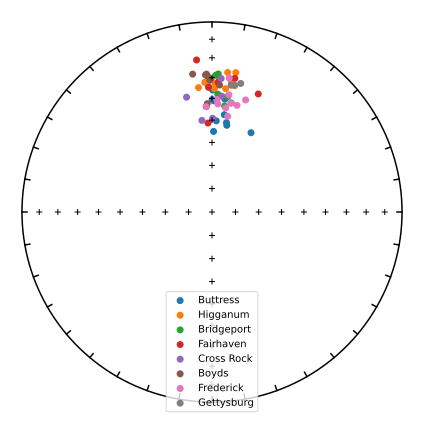

In [43]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1976a_sites_Buttress['dir_dec'].tolist(), Smith1976a_sites_Buttress['dir_inc'].tolist(), 
              color = 'C0', markersize = 50, label = 'Buttress')
ipmag.plot_di(Smith1976a_sites_Higganum['dir_dec'].tolist(), Smith1976a_sites_Higganum['dir_inc'].tolist(), 
              color = 'C1', markersize = 50, label = 'Higganum')
ipmag.plot_di(Smith1976a_sites_Bridgeport['dir_dec'].tolist(), Smith1976a_sites_Bridgeport['dir_inc'].tolist(), 
              color = 'C2', markersize = 50, label = 'Bridgeport')
ipmag.plot_di(Smith1976a_sites_Fairhaven['dir_dec'].tolist(), Smith1976a_sites_Fairhaven['dir_inc'].tolist(), 
              color = 'C3', markersize = 50, label = 'Fairhaven')
ipmag.plot_di(Smith1976a_sites_Cross_Rock['dir_dec'].tolist(), Smith1976a_sites_Cross_Rock['dir_inc'].tolist(), 
              color = 'C4', markersize = 50, label = 'Cross Rock')
ipmag.plot_di(Smith1976a_sites_Boyds['dir_dec'].tolist(), Smith1976a_sites_Boyds['dir_inc'].tolist(), 
              color = 'C5', markersize = 50, label = 'Boyds')
ipmag.plot_di(Smith1976a_sites_Frederick['dir_dec'].tolist(), Smith1976a_sites_Frederick['dir_inc'].tolist(),
              color = 'C6', markersize = 50, label = 'Frederick')
ipmag.plot_di(Smith1976a_sites_Gettysburg['dir_dec'].tolist(), Smith1976a_sites_Gettysburg['dir_inc'].tolist(), 
              color = 'C7', markersize = 50, label = 'Gettysburg')

plt.legend(loc = 8)
plt.show()

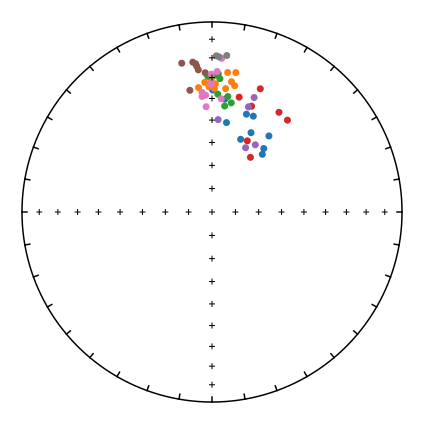

In [44]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1976a_sites_Buttress['dec_tc'].tolist(), Smith1976a_sites_Buttress['inc_tc'].tolist(), color = 'C0', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Higganum['dec_tc'].tolist(), Smith1976a_sites_Higganum['inc_tc'].tolist(), color = 'C1', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Bridgeport['dec_tc'].tolist(), Smith1976a_sites_Bridgeport['inc_tc'].tolist(), color = 'C2', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Fairhaven['dec_tc'].tolist(), Smith1976a_sites_Fairhaven['inc_tc'].tolist(), color = 'C3', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Cross_Rock['dec_tc'].tolist(), Smith1976a_sites_Cross_Rock['inc_tc'].tolist(), color = 'C4', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Boyds['dec_tc'].tolist(), Smith1976a_sites_Boyds['inc_tc'].tolist(), color = 'C5', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Frederick['dec_tc'].tolist(), Smith1976a_sites_Frederick['inc_tc'].tolist(), color = 'C6', markersize = 50)
ipmag.plot_di(Smith1976a_sites_Gettysburg['dec_tc'].tolist(), Smith1976a_sites_Gettysburg['inc_tc'].tolist(), color = 'C7', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [45]:
Smith1976a_sites_Buttress_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Buttress['vgp_lon'].tolist(), Smith1976a_sites_Buttress['vgp_lat'].tolist())
Smith1976a_sites_Higganum_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Higganum['vgp_lon'].tolist(), Smith1976a_sites_Higganum['vgp_lat'].tolist())
Smith1976a_sites_Bridgeport_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Bridgeport['vgp_lon'].tolist(), Smith1976a_sites_Bridgeport['vgp_lat'].tolist())
Smith1976a_sites_Fairhaven_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Fairhaven['vgp_lon'].tolist(), Smith1976a_sites_Fairhaven['vgp_lat'].tolist())
Smith1976a_sites_Cross_Rock_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Cross_Rock['vgp_lon'].tolist(), Smith1976a_sites_Cross_Rock['vgp_lat'].tolist())
Smith1976a_sites_Boyds_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Boyds['vgp_lon'].tolist(), Smith1976a_sites_Boyds['vgp_lat'].tolist())
Smith1976a_sites_Frederick_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Frederick['vgp_lon'].tolist(), Smith1976a_sites_Frederick['vgp_lat'].tolist())
Smith1976a_sites_Gettysburg_vgp_mean = ipmag.fisher_mean(Smith1976a_sites_Gettysburg['vgp_lon'].tolist(), Smith1976a_sites_Gettysburg['vgp_lat'].tolist())

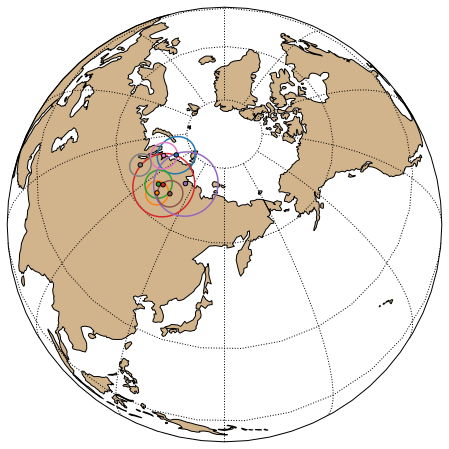

In [46]:
map_axis = ipmag.make_orthographic_map(150, 65)


ipmag.plot_pole(map_axis, Smith1976a_sites_Buttress_vgp_mean['dec'], Smith1976a_sites_Buttress_vgp_mean['inc'], 
                Smith1976a_sites_Buttress_vgp_mean['alpha95'], color = 'C0')
ipmag.plot_pole(map_axis, Smith1976a_sites_Higganum_vgp_mean['dec'], Smith1976a_sites_Higganum_vgp_mean['inc'], 
                Smith1976a_sites_Higganum_vgp_mean['alpha95'], color = 'C1')
ipmag.plot_pole(map_axis, Smith1976a_sites_Bridgeport_vgp_mean['dec'], Smith1976a_sites_Bridgeport_vgp_mean['inc'], 
                Smith1976a_sites_Bridgeport_vgp_mean['alpha95'], color = 'C2')
ipmag.plot_pole(map_axis, Smith1976a_sites_Fairhaven_vgp_mean['dec'], Smith1976a_sites_Fairhaven_vgp_mean['inc'], 
                Smith1976a_sites_Fairhaven_vgp_mean['alpha95'], color = 'C3')
ipmag.plot_pole(map_axis, Smith1976a_sites_Cross_Rock_vgp_mean['dec'], Smith1976a_sites_Cross_Rock_vgp_mean['inc'], 
                Smith1976a_sites_Cross_Rock_vgp_mean['alpha95'], color = 'C4')
ipmag.plot_pole(map_axis, Smith1976a_sites_Boyds_vgp_mean['dec'], Smith1976a_sites_Boyds_vgp_mean['inc'], 
                Smith1976a_sites_Boyds_vgp_mean['alpha95'], color = 'C5')
ipmag.plot_pole(map_axis, Smith1976a_sites_Frederick_vgp_mean['dec'], Smith1976a_sites_Frederick_vgp_mean['inc'], 
                Smith1976a_sites_Frederick_vgp_mean['alpha95'], color = 'C6')
ipmag.plot_pole(map_axis, Smith1976a_sites_Gettysburg_vgp_mean['dec'], Smith1976a_sites_Gettysburg_vgp_mean['inc'], 
                Smith1976a_sites_Gettysburg_vgp_mean['alpha95'], color = 'C7')

plt.show()

**It is odd that the tilt-corrected directions seem more scattered than before-tilting. Nevertheless, Higganum, Bridgeport, Federick, Gettysburg, and Boys are closely clustered and plot near the other 200 Ma poles. However, the tilt-corrected Buttress, Fairhaven, and Cross Rock plot away, in pole position that is shown in no other studies of time in this period. The non-tilt corrected poles are better clustered near the Higganum, Bridgeport, Federick, Gettysburg, and Boys poles. This can be interpreted to be due to the fact that the structural corrections were made on host rocks in the basins, and that the age of the intrusives predate the host rocks. Therefore, we favor the non-tilt-corrected directions here for calculating paleomagnetic poles.**

## Smith and Noltimier (1979) intrusive rocks from Hartford Basin

This study is focusing on similar area as the previous two but instead of developing data from volcanics, this focuses on the intrusives in Hartford Basin. 28 sites from Early Mesozoic Barndoor, East Rock, Mt. Carmel, West Rock intrusives. The data table in the paper also include the Barndoor intrusives from Connecticut besides the aforementioned ones from New York.

The Barndoor East rock, Mt Carmel, and West rock units are intrusive bodies that outcrop in the New Haven formation of western side Hartford Basin. Barndoors has max thickness of 300 km where the other two has about 30 km thickness. Aeromagnetic data suggest these untis are conformable with host Paleozoic host rock with a dip of 20-30 degrees to the east-sourtheast. Here the confidence of doing the tilt correction is addressed both with aeromagentic and field observation that the intrusives were emplaced before the rotation of host rock. The tilt correection brings some site directions better clusters but overall they have pretty tight grouping. 

A total of 33 sites from 4 intrusives were sampled AF cleaning up to 25 mT were used for majority of directional analyses, while some set of samples were further AF demagnetized up to 100 mT and thermally demagnetized up to 600 degree C for magnetic characteristics investigations. Selection criteria were applied to the results, one of them is worth noting here that they exclude sites that have **a95 > 10 degree** which is quite strict. However, it is nice that they provide all data including those with large uncertainties. So here we try to use criteria **a95 < 15**

Af demag suggest presence of MD or PSD grains with present day overprint; unblocking temperature around 500-600 degree c suggest Fe-Ti oxides as remanence carriers, and sharp decrease in magnetization after 450 step was interpreted to be indication of Fe-Ti oxides breakdown after this temperature. Opaque microscopy see Fe-Ti oxides, which supports rock magnetic interpretations.

This study also mentioned many early paleomagnetic studies from the Newark trend and they might be of interest for compilation work here. These data are considered to be associated with the time period when the Central Atlantic Ocean began to open. 

Smith, T. E., & Noltimier, H. C. (1979). Paleomagnetism of the Newark Trend igneous rocks of the north central Appalachians and the opening of the central Atlantic Ocean. American Journal of Science, 279(7), 778-807. doi: 10.2475/ajs.279.7.778. 

In [47]:
Smith1979a_sites = pd.read_csv('pmag_compiled/Smith1979a/Smith1979a_sites.txt', sep = '\t', header = 1)
Smith1979a_sites = Smith1979a_sites[Smith1979a_sites['dir_alpha95'] < 15]
Smith1979a_sites = ipmag.vgp_calc(Smith1979a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Smith1979a_sites

site   location  dir_dec  dir_inc  dir_k  dir_n_samples  dir_n_specimens  \
0    WR-1  West Rock     14.5     31.7     75              6                6   
1    WR-2  West Rock    354.0     19.1    354              8                8   
2    WR-3  West Rock    359.6     26.0    178              9                9   
3    WR-4  West Rock    358.6     27.0    131             10               10   
6    WR-7  West Rock    347.6     31.1     62              7                7   
7    WR-8  West Rock    356.4     31.8    806              8                8   
8    WR-9  West Rock    356.0     24.8    315             13               13   
11  WR-12  West Rock    344.9     38.4    134              9                9   
12   ER-1  East Rock      6.2     27.3    261             14               14   
13   ER-2  East Rock    354.7     28.0    205             12               12   
14   ER-3  East Rock    357.6     38.3    139              8                8   
15   ER-4  East Rock    358.0     28.3    226              9                9   
16   ER-5  East Rock    359.4     33.7    257              9                9   
17   ER-6  East Rock    359.1     34.5    284              9                9   
19   MC-2     Carmel    355.9     34.1    485             10               10   
20   MC-3     Carmel      4.6     24.5    126              9                9   
21   MC-4     Carmel      0.1     23.8    126             14               14   
22   BD-1   Barndoor      7.9     34.9    118             10               10   
23   BD-2   Barndoor      3.2     28.9    101             11               11   
24   BD-3   Barndoor     14.7     31.9    424             11               11   
25   BD-4   Barndoor     11.5     22.4     59              6                6   
26   BD-5   Barndoor    356.8     31.2     78              8                8   
27   BD-6   Barndoor      6.1     32.9     29              9                9   
28   BD-7   Barndoor    358.7     28.3    857              8                8   
29   BD-8   Barndoor     10.6     37.7     56              8                8   
30   BD-9   Barndoor      1.9     40.6    132              5                5   
31  BD-10   Barndoor    355.9     29.6     77              9                9   
32  BD-11   Barndoor      8.9     29.2    354              7                7   

    dir_n_total_specimens  dir_tilt_correction  dir_alpha95  ...  age_unit  \
0                       6                    0          7.8  ...        Ma   
1                       8                    0          2.9  ...        Ma   
2                       9                    0          3.9  ...        Ma   
3                      10                    0          4.2  ...        Ma   
6                       7                    0          7.7  ...        Ma   
7                       8                    0          1.9  ...        Ma   
8                      13                    0          2.3  ...        Ma   
11                      9                    0          4.5  ...        Ma   
12                     14                    0          2.5  ...        Ma   
13                     12                    0          3.0  ...        Ma   
14                      8                    0          4.7  ...        Ma   
15                      9                    0          3.4  ...        Ma   
16                      9                    0          3.2  ...        Ma   
17                      9                    0          3.1  ...        Ma   
19                     10                    0          2.2  ...        Ma   
20                      9                    0          4.6  ...        Ma   
21                     14                    0          3.6  ...        Ma   
22                     10                    0          4.5  ...        Ma   
23                     11                    0          4.6  ...        Ma   
24                     11                    0          2.2  ...        Ma   
25               

In [48]:
Smith1979a_sites_WR = Smith1979a_sites[Smith1979a_sites['location'] == 'West Rock']
Smith1979a_sites_ER = Smith1979a_sites[Smith1979a_sites['location'] == 'East Rock']
Smith1979a_sites_Carmel = Smith1979a_sites[Smith1979a_sites['location'] == 'Carmel']
Smith1979a_sites_Barndoor = Smith1979a_sites[Smith1979a_sites['location'] == 'Barndoor']

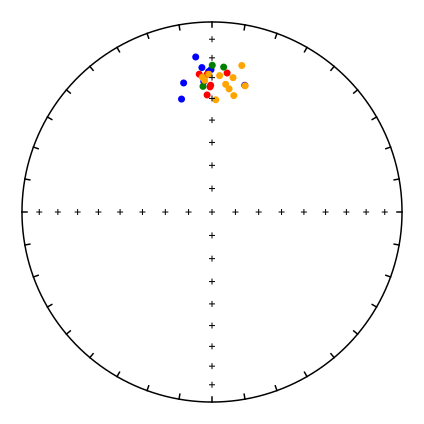

In [49]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1979a_sites_WR['dir_dec'].tolist(), Smith1979a_sites_WR['dir_inc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(Smith1979a_sites_ER['dir_dec'].tolist(), Smith1979a_sites_ER['dir_inc'].tolist(), color = 'red', markersize = 50)
ipmag.plot_di(Smith1979a_sites_Carmel['dir_dec'].tolist(), Smith1979a_sites_Carmel['dir_inc'].tolist(), color = 'green', markersize = 50)
ipmag.plot_di(Smith1979a_sites_Barndoor['dir_dec'].tolist(), Smith1979a_sites_Barndoor['dir_inc'].tolist(), color = 'orange', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [50]:
Smith1979a_sites_WR_vgp_mean = ipmag.fisher_mean(Smith1979a_sites_WR['vgp_lon'].tolist(),Smith1979a_sites_WR['vgp_lat'].tolist())
Smith1979a_sites_ER_vgp_mean = ipmag.fisher_mean(Smith1979a_sites_ER['vgp_lon'].tolist(),Smith1979a_sites_ER['vgp_lat'].tolist())
Smith1979a_sites_Carmel_vgp_mean = ipmag.fisher_mean(Smith1979a_sites_Carmel['vgp_lon'].tolist(),Smith1979a_sites_Carmel['vgp_lat'].tolist())
Smith1979a_sites_Barndoor_vgp_mean = ipmag.fisher_mean(Smith1979a_sites_Barndoor['vgp_lon'].tolist(),Smith1979a_sites_Barndoor['vgp_lat'].tolist())

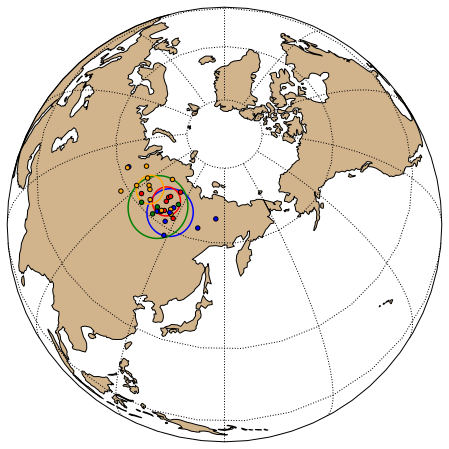

In [51]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Smith1979a_sites_WR['vgp_lon'].tolist(),Smith1979a_sites_WR['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis,Smith1979a_sites_ER['vgp_lon'].tolist(),Smith1979a_sites_ER['vgp_lat'].tolist(), color = 'red')
ipmag.plot_vgp(map_axis,Smith1979a_sites_Carmel['vgp_lon'].tolist(),Smith1979a_sites_Carmel['vgp_lat'].tolist(), color = 'green')
ipmag.plot_vgp(map_axis,Smith1979a_sites_Barndoor['vgp_lon'].tolist(),Smith1979a_sites_Barndoor['vgp_lat'].tolist(), color = 'orange')


ipmag.plot_pole(map_axis, Smith1979a_sites_WR_vgp_mean['dec'], Smith1979a_sites_WR_vgp_mean['inc'], 
                Smith1979a_sites_WR_vgp_mean['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, Smith1979a_sites_ER_vgp_mean['dec'], Smith1979a_sites_ER_vgp_mean['inc'], 
                Smith1979a_sites_ER_vgp_mean['alpha95'], color = 'red')
ipmag.plot_pole(map_axis, Smith1979a_sites_Carmel_vgp_mean['dec'], Smith1979a_sites_Carmel_vgp_mean['inc'], 
                Smith1979a_sites_Carmel_vgp_mean['alpha95'], color = 'green')
ipmag.plot_pole(map_axis, Smith1979a_sites_Barndoor_vgp_mean['dec'], Smith1979a_sites_Barndoor_vgp_mean['inc'], 
                Smith1979a_sites_Barndoor_vgp_mean['alpha95'], color = 'orange')
plt.show()

Above plots show the raw data from Smith (1979) showing that without structural corrections the pole from the intrusives is very close to those derived from the volcanics, see McIntosh1985 section and Prevot1989 section. Below we will show the structurally corrected directions and pole positions and see how this affect the data. 

In [52]:
Smith1979a_sites['dec_tc'] = [pmag.dotilt(Smith1979a_sites['dir_dec'].tolist()[i], Smith1979a_sites['dir_inc'].tolist()[i], 
                                          Smith1979a_sites['dir_dip'].tolist()[i],  Smith1979a_sites['dip'].tolist()[i])[0]
                                      for i in range(len(Smith1979a_sites['dir_dec']))]
Smith1979a_sites['inc_tc'] = [pmag.dotilt(Smith1979a_sites['dir_dec'].tolist()[i], Smith1979a_sites['dir_inc'].tolist()[i], 
                                          Smith1979a_sites['dir_dip'].tolist()[i], Smith1979a_sites['dip'].tolist()[i])[1] 
                                      for i in range(len(Smith1979a_sites['dir_dec']))]
# Smith1979a_sites
Smith1979a_sites_tilt_corrected = ipmag.vgp_calc(Smith1979a_sites, tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',
    dec_tc='dec_tc',
    inc_tc='inc_tc')

In [53]:
Smith1979a_sites_WR_tilt_corrected = Smith1979a_sites_tilt_corrected[Smith1979a_sites_tilt_corrected['location'] == 'West Rock']
Smith1979a_sites_ER_tilt_corrected = Smith1979a_sites_tilt_corrected[Smith1979a_sites_tilt_corrected['location'] == 'East Rock']
Smith1979a_sites_Carmel_tilt_corrected = Smith1979a_sites_tilt_corrected[Smith1979a_sites_tilt_corrected['location'] == 'Carmel']
Smith1979a_sites_Barndoor_tilt_corrected = Smith1979a_sites_tilt_corrected[Smith1979a_sites_tilt_corrected['location'] == 'Barndoor']

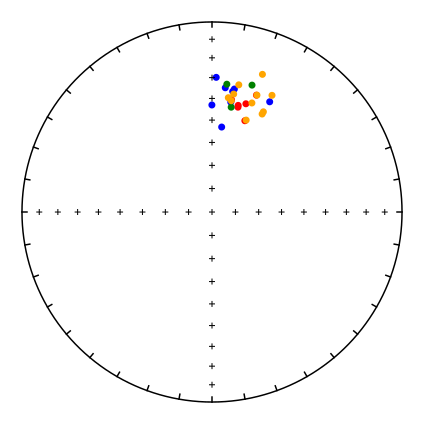

In [54]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1979a_sites_WR_tilt_corrected['dec_tc'].tolist(), Smith1979a_sites_WR_tilt_corrected['inc_tc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(Smith1979a_sites_ER_tilt_corrected['dec_tc'].tolist(), Smith1979a_sites_ER_tilt_corrected['inc_tc'].tolist(), color = 'red', markersize = 50)
ipmag.plot_di(Smith1979a_sites_Carmel_tilt_corrected['dec_tc'].tolist(), Smith1979a_sites_Carmel_tilt_corrected['inc_tc'].tolist(), color = 'green', markersize = 50)
ipmag.plot_di(Smith1979a_sites_Barndoor_tilt_corrected['dec_tc'].tolist(), Smith1979a_sites_Barndoor_tilt_corrected['inc_tc'].tolist(), color = 'orange', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [55]:
Smith1979a_sites_WR_vgp_mean_tc = ipmag.fisher_mean(Smith1979a_sites_WR_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_WR_tilt_corrected['vgp_lat'].tolist())
Smith1979a_sites_ER_vgp_mean_tc = ipmag.fisher_mean(Smith1979a_sites_ER_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_ER_tilt_corrected['vgp_lat'].tolist())
Smith1979a_sites_Carmel_vgp_mean_tc = ipmag.fisher_mean(Smith1979a_sites_Carmel_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_Carmel_tilt_corrected['vgp_lat'].tolist())
Smith1979a_sites_Barndoor_vgp_mean_tc = ipmag.fisher_mean(Smith1979a_sites_Barndoor_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_Barndoor_tilt_corrected['vgp_lat'].tolist())

print(Smith1979a_sites_WR_vgp_mean_tc)
print(Smith1979a_sites_ER_vgp_mean_tc)
print(Smith1979a_sites_Carmel_vgp_mean_tc)
print(Smith1979a_sites_Barndoor_vgp_mean_tc)

{'dec': 82.9565387167945, 'inc': 69.24453454429776, 'n': 8, 'r': 7.903117933120955, 'k': 72.25279378834179, 'alpha95': 6.560240814618096, 'csd': 9.529227526730713}
{'dec': 65.12385358567505, 'inc': 67.91988172095714, 'n': 6, 'r': 5.981172121478716, 'k': 265.56364246496065, 'alpha95': 4.119030276680549, 'csd': 4.970507237257479}
{'dec': 79.14542805434814, 'inc': 66.36981346134712, 'n': 3, 'r': 2.984935317075191, 'k': 132.76084269296837, 'alpha95': 10.741990698835188, 'csd': 7.029914105793582}
{'dec': 64.75567358852669, 'inc': 63.950171841544076, 'n': 11, 'r': 10.902458610236398, 'k': 102.52058151145499, 'alpha95': 4.530766349290571, 'csd': 7.99980661165628}


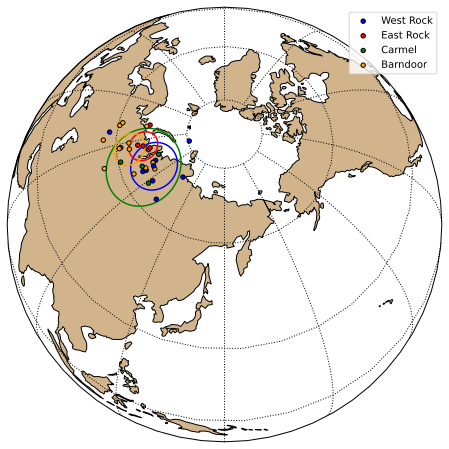

In [56]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Smith1979a_sites_WR_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_WR_tilt_corrected['vgp_lat'].tolist(), color = 'blue', label = 'West Rock')
ipmag.plot_vgp(map_axis,Smith1979a_sites_ER_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_ER_tilt_corrected['vgp_lat'].tolist(), color = 'red', label = 'East Rock')
ipmag.plot_vgp(map_axis,Smith1979a_sites_Carmel_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_Carmel_tilt_corrected['vgp_lat'].tolist(), color = 'green', label = 'Carmel')
ipmag.plot_vgp(map_axis,Smith1979a_sites_Barndoor_tilt_corrected['vgp_lon'].tolist(),Smith1979a_sites_Barndoor_tilt_corrected['vgp_lat'].tolist(), color = 'orange', label = 'Barndoor')


ipmag.plot_pole(map_axis, Smith1979a_sites_WR_vgp_mean_tc['dec'], Smith1979a_sites_WR_vgp_mean_tc['inc'], 
                Smith1979a_sites_WR_vgp_mean_tc['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, Smith1979a_sites_ER_vgp_mean_tc['dec'], Smith1979a_sites_ER_vgp_mean_tc['inc'], 
                Smith1979a_sites_ER_vgp_mean_tc['alpha95'], color = 'red')
ipmag.plot_pole(map_axis, Smith1979a_sites_Carmel_vgp_mean_tc['dec'], Smith1979a_sites_Carmel_vgp_mean_tc['inc'], 
                Smith1979a_sites_Carmel_vgp_mean_tc['alpha95'], color = 'green')
ipmag.plot_pole(map_axis, Smith1979a_sites_Barndoor_vgp_mean_tc['dec'], Smith1979a_sites_Barndoor_vgp_mean_tc['inc'], 
                Smith1979a_sites_Barndoor_vgp_mean_tc['alpha95'], color = 'orange')

plt.legend()
plt.show()

Although Smith and Noltimier in the discussion say that the Barndoor pole (orange color) is distinguishable from other pole positions, here after tilt correction and the 15 degree a95 screening, the mean pole position is not very far from the other locations, it is even indistinguishable with the pole from East Rock. I am comfortable here to group all above data in one and make them the intrusive pole from the Hartford Basin. 

Note that Sutter and Smith (1979) published two Ar/Ar date for this Barndoor dike which are about 173 Ma and 168 Ma. 

## McEnroe (2000) diabase dikes in the Massachusetts

This study cites no precise date on the units but claims that the NE trending dikes in the central Massachusetts are of Jurassic age. The dikes have three chemical types: Holden- high TiO2 quartz normative; Ware- low TiO2 quartz normative; Pelham-Loudville- high Fe2O3 quartz normative. 

The geologic description of these dikes are similar to those studies above. They are mostly all NE-SW trending quartz tholeiitic dikes and sills. Extending from Connecticut to New Hampshire. **They should also belong to the same group as those on the side of, but not within the Mesozoic Hartford and Deerfield basins. (Bridgeport and Higganum in Smith 1976)**

The study says the strata in the Deerfield Basin dip at low to moderate angles (10-20 degrees to the east). **However, they do not talk about any structural correction for the dikes in this study. Their argument is that although there is eastward tilting of Mesozoic units in the Hartford basin and deerfield basin, due to motion on the border fault, there is little evidence of regional tilting outside of the rift basins. Also no systematic variation in paleomagnetic directions is observed between dikes that outcrop on different sides of the basin. Therefore they argue that no systematic tilt correction is needed.** The dikes sampled in this study vary in thickness from less than 1m up to 55 m, and samples were taken from chilled margin to the interiors. Titanomagnetite and maghemite with ilmenite lamellae observed in diabase. In lab both AF (100 mT) and thermal (580) demagnetization were performed and principal component analyses were operated. 

The grouping of these dikes, especially the  Pelham and Loudville sets, was based on geochemical signatures. At the time, and very likely till now, there is no published radiometric data exists for any of the dikes in Massachusetts. 

**No precise location provided in the text but just a NW cornor of the Hartford basin. However, the pole positions for sites were calculated and thus we will use the PLon and PLat directly imported from the study instead of recalculating the pole position using the rather imprecise location. The site location may be improved by georeferencing the map.**

**We should consider prioritizing using this study's result as Hartford/Deerfield pole position since it. uses modern paleoamgnetic laboratory procedure. The only issue is the lack of geochronology data.**

McEnroe, S. A., & Brown, L. L. (2000). Palaeomagnetism, rock magnetism and geochemistry of Jurassic dykes and correlative redbeds, Massachusetts, USA. Geophysical Journal International, 143(1), 22-38. doi: http://dx.doi.org/10.1046/j.1365-246x.2000.00193.x. 

In [138]:
McEnroe2000a_sites = pd.read_csv('pmag_compiled/McEnroe2000a/McEnroe2000a_sites.txt', sep = '\t', header = 1)
McEnroe2000a_sites = McEnroe2000a_sites[McEnroe2000a_sites['dir_alpha95'] < 15]

McEnroe2000a_sites_Holden = McEnroe2000a_sites[McEnroe2000a_sites['location'] == 'Holden']
McEnroe2000a_sites_Pelham_Loudville = McEnroe2000a_sites[McEnroe2000a_sites['location'] == 'Pelham-Loudville']
McEnroe2000a_sites_Ware = McEnroe2000a_sites[McEnroe2000a_sites['location'] == 'Ware']

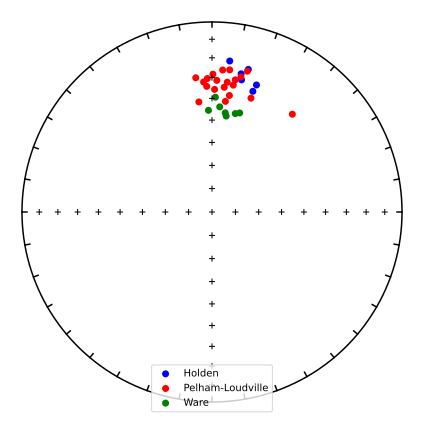

In [58]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(McEnroe2000a_sites_Holden['dir_dec'].tolist(), McEnroe2000a_sites_Holden['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Holden')
ipmag.plot_di(McEnroe2000a_sites_Pelham_Loudville['dir_dec'].tolist(), McEnroe2000a_sites_Pelham_Loudville['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'Pelham-Loudville')
ipmag.plot_di(McEnroe2000a_sites_Ware['dir_dec'].tolist(), McEnroe2000a_sites_Ware['dir_inc'].tolist(), 
              color = 'green', markersize = 50, label = 'Ware')

plt.legend(loc = 8)
plt.show()

In [59]:
McEnroe2000a_sites_Holden_vgp_mean = ipmag.fisher_mean(McEnroe2000a_sites_Holden['PLon'].tolist(),
                                                      McEnroe2000a_sites['PLat'].tolist())
McEnroe2000a_sites_Pelham_Loudville_vgp_mean = ipmag.fisher_mean(McEnroe2000a_sites_Pelham_Loudville['PLon'].tolist(),
                                                                 McEnroe2000a_sites_Pelham_Loudville['PLat'].tolist())
McEnroe2000a_sites_Ware_vgp_mean = ipmag.fisher_mean(McEnroe2000a_sites['PLon'].tolist(), 
                                                     McEnroe2000a_sites['PLat'].tolist())

print(McEnroe2000a_sites_Holden_vgp_mean)
print(McEnroe2000a_sites_Pelham_Loudville_vgp_mean)
print(McEnroe2000a_sites_Ware_vgp_mean)

{'dec': 80.19560707282663, 'inc': 60.34445754570096, 'n': 6, 'r': 5.981285497726204, 'k': 267.1724808306009, 'alpha95': 4.106565457366851, 'csd': 4.955519133620122}
{'dec': 94.16602544732947, 'inc': 65.01938665664433, 'n': 20, 'r': 19.677545547230903, 'k': 58.92305048615808, 'alpha95': 4.28751928425224, 'csd': 10.55218526786114}
{'dec': 89.82347305359193, 'inc': 66.02368269651923, 'n': 33, 'r': 32.51038343859634, 'k': 65.35726632338738, 'alpha95': 3.1155034447365026, 'csd': 10.019316124631144}


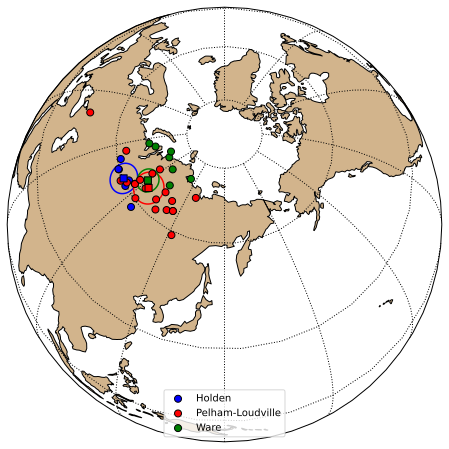

In [60]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, McEnroe2000a_sites_Holden['PLon'].tolist(), McEnroe2000a_sites_Holden['PLat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Holden')
ipmag.plot_vgp(map_axis, McEnroe2000a_sites_Pelham_Loudville['PLon'].tolist(), McEnroe2000a_sites_Pelham_Loudville['PLat'].tolist(), 
               color = 'red', markersize = 50, label = 'Pelham-Loudville')
ipmag.plot_vgp(map_axis, McEnroe2000a_sites_Ware['PLon'].tolist(), McEnroe2000a_sites_Ware['PLat'].tolist(), 
               color = 'green', markersize = 50, label = 'Ware')

ipmag.plot_pole(map_axis, McEnroe2000a_sites_Holden_vgp_mean['dec'], McEnroe2000a_sites_Holden_vgp_mean['inc'], 
                McEnroe2000a_sites_Holden_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, McEnroe2000a_sites_Pelham_Loudville_vgp_mean['dec'], McEnroe2000a_sites_Pelham_Loudville_vgp_mean['inc'], 
                McEnroe2000a_sites_Pelham_Loudville_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, McEnroe2000a_sites_Ware_vgp_mean['dec'], McEnroe2000a_sites_Ware_vgp_mean['inc'], 
                McEnroe2000a_sites_Ware_vgp_mean['alpha95'], color = 'green', marker = 's', markersize = 50)

plt.legend(loc = 8)
plt.show()

## Dooley (1982) diabase dikes in Piedmont, South Carolina

This is a study pairing paleomagnetic data and K-Ar geochronology data on diabase dikes in South Carolina. By the time, there had been several hundred diabase dikes intruding the Piedmont province of South Carolina mapped. The dikes are steeply dipping, unmetamorphosed, olivine normative tholeiites, average trending to the NW. They are commonly weathered, showing spheroidal boulders. The AF demagnetization spectrum of these dikes are very much like those Newark trend basalts (mixture of multidomain and single domain grains). It is odd that this study used AF or thermal cleaning instead of least-square analyses.

The K-Ar ages listed in the data table in this study range cluster near 190 to 200 Ma. Outliers show ages of 188 Ma, or 180 Ma. **Sutter (1985) reported Ar-Ar age to be averaging around 200 Ma. An average plateau age is 198.4 $\pm$ 2.1 Ma.** We will look into whether there are more recent dates on these dikes. 

The text discussed tilting but stated that it is complicated. Uplifting should have made a tilt to west, but erosion add to complications. They mentioned that a 10 degree to west tilt correction can bring the mean pole position in this study almost into coincidence with the 190 Ma pole from Irving and Irving (1982). 


There are more studies on the dikes in this area but the thesis and pulications are not available online. 
Watts, D., & NOLTIMIE. HC. (1974, January). PALEOMAGNETIC STUDY OF DIABASE DIKES IN INNER PIEDMONT OF N-CAROLINA AND GEORGIA. In TRANSACTIONS-AMERICAN GEOPHYSICAL UNION (Vol. 55, No. 7, pp. 675-675). 2000 FLORIDA AVE NW, WASHINGTON, DC 20009: AMER GEOPHYSICAL UNION.

Watts, D. R. (1975). A paleomagnetic study of four Mesozoic diabase dike swarms of the southern Appalachian Mountains (Doctoral dissertation, Ohio State University).

Bell, H., & DL, D. (1980). DIABASE DYKES IN THE HAILE-BREWER AREA, SOUTH CAROLINA, AND THEIR MAGNETIC PROPERTIES.

However, Dooley provide a combined mean pole with Watts (1975) and Bell (1980). 

Dooley, R. E., & Smith, W. A. (1982). Age and magnetism of diabase dykes and tilting of the Piedmont. Tectonophysics, 90(3-4), 283-307. doi: http://dx.doi.org/10.1016/0040-1951(82)90191-3.

In [61]:
Dooley1982a_sites = pd.read_csv('pmag_compiled/Dooley1982a/Dooley1982a_sites.txt', sep = '\t', header = 1)
Dooley1982a_sites = Dooley1982a_sites[Dooley1982a_sites['lon'].notnull()]
Dooley1982a_sites = Dooley1982a_sites[Dooley1982a_sites['dir_alpha95'] < 15]
Dooley1982a_sites = ipmag.vgp_calc(Dooley1982a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Dooley1982a_sites

site  location note  demag_level  dir_dec  dir_inc  dir_k  dir_n_samples  \
0      3  Piedmont  NaN           15      9.5      0.5  101.5            7.0   
1      4  Piedmont  NaN           25      8.9     34.6   25.1            6.0   
5      8  Piedmont  NaN           15     12.1     12.4   39.5            5.0   
6      9  Piedmont  NaN           20     40.8     35.8   71.6            6.0   
7     10  Piedmont  NaN           35      9.7     16.3   30.3            8.0   
9     12  Piedmont  NaN           15    350.4     35.7   54.0            7.0   
12    15  Piedmont  NaN           20    358.1     25.7   84.8            5.0   
13    17  Piedmont  NaN           20     31.4     26.9   52.7            5.0   
14    18  Piedmont  NaN           10      0.2     32.9   73.8            7.0   
17    21  Piedmont  NaN           25    358.4     31.5   54.8            7.0   
18    23  Piedmont  NaN           15    352.5     21.4   45.6            9.0   

    dir_n_specimens  dir_n_total_specimens  ...  result_type  age  age_unit  \
0               7.0                    7.0  ...            i  200        Ma   
1               6.0                    6.0  ...            i  200        Ma   
5               6.0                    6.0  ...            i  200        Ma   
6               6.0                    6.0  ...            i  200        Ma   
7               8.0                    8.0  ...            i  200        Ma   
9               7.0                    7.0  ...            i  200        Ma   
12              7.0                    7.0  ...            i  200        Ma   
13              7.0                    7.0  ...            i  200        Ma   
14             10.0                   10.0  ...            i  200        Ma   
17              8.0                    8.0  ...            i  200        Ma   
18              9.0                    9.0  ...            i  200        Ma   

          group                     citations paleolatitude    vgp_lat  \
0   Piedmont_NW  10.1016/0040-1951(82)90191-3      0.250005  54.807464   
1   Piedmont_NW  10.1016/0040-1951(82)90191-3     19.030691  72.629315   
5   Piedmont_NW  10.1016/0040-1951(82)90191-3      6.273456  59.915120   
6   Piedmont_NW  10.1016/0040-1951(82)90191-3     19.829880  51.228142   
7   Piedmont_NW  10.1016/0040-1951(82)90191-3      8.318289  62.529423   
9   Piedmont_NW  10.1016/0040-1951(82)90191-3     19.762675  73.155961   
12  Piedmont_NW  10.1016/0040-1951(82)90191-3     13.530062  68.860051   
13  Piedmont_NW  10.1016/0040-1951(82)90191-3     14.233681  55.101994   
14  Piedmont_NW  10.1016/0040-1951(82)90191-3     17.924553  73.323601   
17  Piedmont_NW  10.1016/0040-1951(82)90191-3     17.035085  72.277309   
18  Piedmont_NW  10.1016/0040-1951(82)90191-3     11.086518  65.893159   

       vgp_lon vgp_lat_rev vgp_lon_rev  
0    82.058869  -54.807464  262.058869  
1    69.367387  -72.629315  249.367387  
5    74.139081  -59.915120  254.139081  
6    19.519228  -51.228142  199.519228  
7    77.513067  -62.529423  257.513067  
9   131.394548  -73.155961  311.394548  
12  103.328001  -68.860051  283.328001  
13   36.228671  -55.101994  216.228671  
14   97.536868  -73.323601  277.536868  
17  103.231267  -72.277309  283.231267  
18  116.976863  -65.893159  296.976863  

[11 rows x 29 columns]

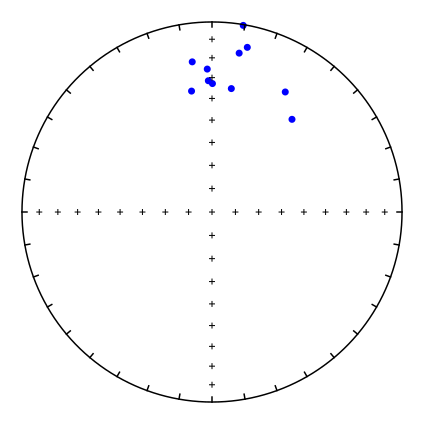

In [62]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Dooley1982a_sites['dir_dec'].tolist(), Dooley1982a_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [63]:
Dooley1982a_sites_vgp_mean = ipmag.fisher_mean(Dooley1982a_sites['vgp_lon'].tolist(),Dooley1982a_sites['vgp_lat'].tolist())
Dooley1982a_sites_vgp_mean

{'dec': 76.73591662104354,
 'inc': 68.1293741112031,
 'n': 11,
 'r': 10.599934055450712,
 'k': 24.995879145039293,
 'alpha95': 9.313624546468525,
 'csd': 16.201335322089594}

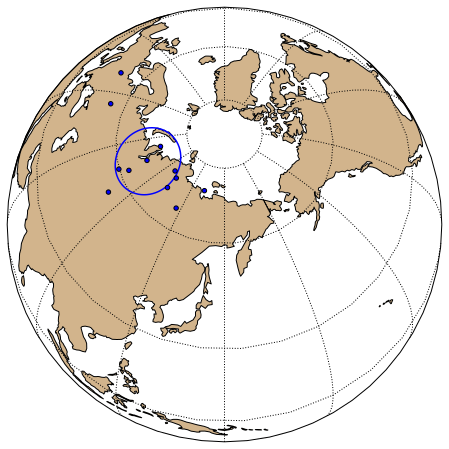

In [64]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Dooley1982a_sites['vgp_lon'].tolist(),Dooley1982a_sites['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_pole(map_axis, Dooley1982a_sites_vgp_mean['dec'], Dooley1982a_sites_vgp_mean['inc'], 
                Dooley1982a_sites_vgp_mean['alpha95'], color = 'blue')

plt.show()

## McIntosh (1985) basalt flows from Newark Basin

AF demagnetizations were performed on the Watchung basalts up to 30 mT. 

In [65]:
McIntosh1985a_sites = pd.read_csv('pmag_compiled/McIntosh1985a/McIntosh1985a_sites.txt', sep = '\t', header = 1)
McIntosh1985a_sites = McIntosh1985a_sites[McIntosh1985a_sites['dir_alpha95'] <= 15]
McIntosh1985a_sites = ipmag.vgp_calc(McIntosh1985a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
McIntosh1985a_sites['location'].unique()

array(['Orange Mountain', 'Preakness', 'Hook Mountain'], dtype=object)

In [66]:
McIntosh1985a_Orange_Mountain = McIntosh1985a_sites[McIntosh1985a_sites['location'] == 'Orange Mountain']
McIntosh1985a_Preakness = McIntosh1985a_sites[McIntosh1985a_sites['location'] == 'Preakness']
McIntosh1985a_Hook_Mountain = McIntosh1985a_sites[McIntosh1985a_sites['location'] == 'Hook Mountain']

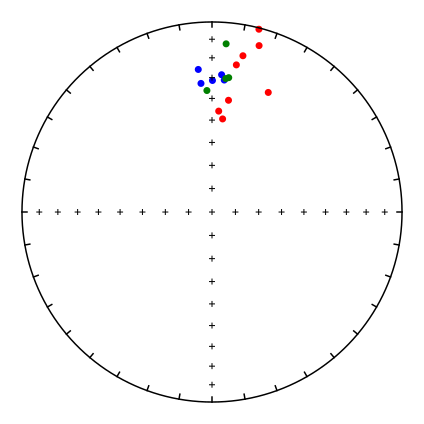

In [67]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(McIntosh1985a_Orange_Mountain['dir_dec'].tolist(), McIntosh1985a_Orange_Mountain['dir_inc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(McIntosh1985a_Preakness['dir_dec'].tolist(), McIntosh1985a_Preakness['dir_inc'].tolist(), color = 'red', markersize = 50)
ipmag.plot_di(McIntosh1985a_Hook_Mountain['dir_dec'].tolist(), McIntosh1985a_Hook_Mountain['dir_inc'].tolist(), color = 'green', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [68]:
McIntosh1985a_Orange_Mountain_vgp_mean = ipmag.fisher_mean(McIntosh1985a_Orange_Mountain['vgp_lon'].tolist(),McIntosh1985a_Orange_Mountain['vgp_lat'].tolist())
McIntosh1985a_Preakness_vgp_mean = ipmag.fisher_mean(McIntosh1985a_Preakness['vgp_lon'].tolist(),McIntosh1985a_Preakness['vgp_lat'].tolist())
McIntosh1985a_Hook_Mountain_vgp_mean = ipmag.fisher_mean(McIntosh1985a_Hook_Mountain['vgp_lon'].tolist(),McIntosh1985a_Hook_Mountain['vgp_lat'].tolist())

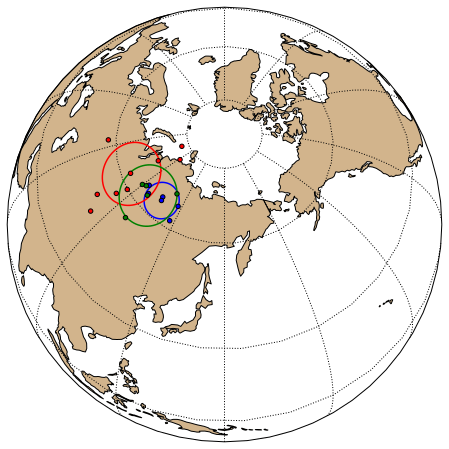

In [69]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,McIntosh1985a_Orange_Mountain['vgp_lon'].tolist(),McIntosh1985a_Orange_Mountain['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis,McIntosh1985a_Preakness['vgp_lon'].tolist(),McIntosh1985a_Preakness['vgp_lat'].tolist(), color = 'red')
ipmag.plot_vgp(map_axis,McIntosh1985a_Hook_Mountain['vgp_lon'].tolist(),McIntosh1985a_Hook_Mountain['vgp_lat'].tolist(), color = 'green')

ipmag.plot_pole(map_axis, McIntosh1985a_Orange_Mountain_vgp_mean['dec'], McIntosh1985a_Orange_Mountain_vgp_mean['inc'], 
                McIntosh1985a_Orange_Mountain_vgp_mean['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, McIntosh1985a_Preakness_vgp_mean['dec'], McIntosh1985a_Preakness_vgp_mean['inc'], 
                McIntosh1985a_Preakness_vgp_mean['alpha95'], color = 'red')
ipmag.plot_pole(map_axis, McIntosh1985a_Hook_Mountain_vgp_mean['dec'], McIntosh1985a_Hook_Mountain_vgp_mean['inc'], 
                McIntosh1985a_Hook_Mountain_vgp_mean['alpha95'], color = 'green')

plt.show()

## Smith (1987) diabase dikes in Piedmont, North Carolina

Smith (1987) investigated two suites of crosscutting diabase dikes of the North Carolina Piedmont. One suite is NW trending and the other N-S trending. The dikes crosscut one another. The structural relationships and areal distributions of the dikes suggest emplacements of two different stress regime representing different ages or phases. The dikes are commonly steeply dipping, "unmetamorphosed" and olivine normative. 

**The paper cited geochemical studies and concluded that the NW suite of dikes are similar to those NW trending diabase dikes in South Carolina. The N-S trending dikes are chemically similar to the diabase in Virginia.**

Paleomagnetic directions of the NW trending dikes are shallower than the N-S trending ones. **The NW dikes are found throughout the southern Appalachian Piedmont from Alabama to Virginia, while the N-S dikes crosscut the NW dikes and are unique to the souther Appalachians.** Based on this evidence Smith interpreted that **the NW suite is older than the N-S suite of dikes**. The text say there is no evidence for post emplacement tilting. 

**It is interesting that both the NW dikes and N-S dikes recorded reversed polarities, although normal polarities definitely dominate. However, it is worth noting that there are two sites, one normal and one reversed directions that is oddly away from the other sites. The reversed one may be interpreted to be antiparallel to the normal directions, but the normal one has issues. Smith excluded it from further analyses. **

Smith, W. A. (1987). Paleomagnetic results from a crosscutting system of northwest and north-south trending diabase dikes in the North Carolina Piedmont. Tectonophysics, 136(1-2), 137-150. doi: http://dx.doi.org/10.1016/0040-1951(87)90336-2. 

In [70]:
Smith1987a_sites = pd.read_csv('pmag_compiled/Smith1987a/Smith1987a_sites.txt', sep = '\t', header = 1)
Smith1987a_sites = Smith1987a_sites[Smith1987a_sites['dir_alpha95'].notnull()]
Smith1987a_sites = Smith1987a_sites[Smith1987a_sites['dir_alpha95'] < 15]
Smith1987a_sites = Smith1987a_sites[(Smith1987a_sites['dir_dec'] < 90) | (Smith1987a_sites['dir_dec'] > 270)]
Smith1987a_sites = ipmag.vgp_calc(Smith1987a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Smith1987a_sites_NW = Smith1987a_sites[Smith1987a_sites['note'] == 'NW trending']
Smith1987a_sites_NS = Smith1987a_sites[Smith1987a_sites['note'] == 'N-S trending']

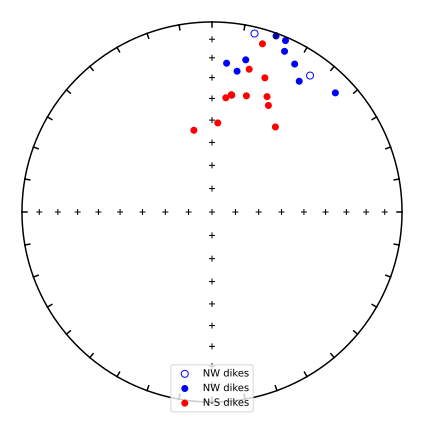

In [71]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1987a_sites_NW['dir_dec'].tolist(), Smith1987a_sites_NW['dir_inc'].tolist(), color = 'blue', markersize = 50, label = 'NW dikes')
ipmag.plot_di(Smith1987a_sites_NS['dir_dec'].tolist(), Smith1987a_sites_NS['dir_inc'].tolist(), color = 'red', markersize = 50, label = 'N-S dikes')

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.legend(loc = 8)
plt.show()

In [72]:
Smith1987a_sites_NW_vgp_mean = ipmag.fisher_mean(Smith1987a_sites_NW['vgp_lon'].tolist(),Smith1987a_sites_NW['vgp_lat'].tolist())
Smith1987a_sites_NS_vgp_mean = ipmag.fisher_mean(Smith1987a_sites_NS['vgp_lon'].tolist(),Smith1987a_sites_NS['vgp_lat'].tolist())
print(Smith1987a_sites_NW_vgp_mean)
print(Smith1987a_sites_NS_vgp_mean)

{'dec': 60.15349749711623, 'inc': 52.92417255949151, 'n': 11, 'r': 10.713680187305737, 'k': 34.92597981921067, 'alpha95': 7.834675745221414, 'csd': 13.705999748603011}
{'dec': 55.14250258267994, 'inc': 69.9008805749069, 'n': 12, 'r': 11.669899007982757, 'k': 33.323135240458164, 'alpha95': 7.630326922850625, 'csd': 14.031758163100568}


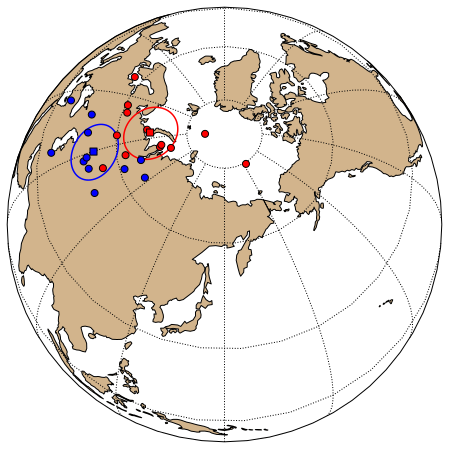

In [73]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Smith1987a_sites_NW['vgp_lon'].tolist(),Smith1987a_sites_NW['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Smith NW dikes')
ipmag.plot_vgp(map_axis,Smith1987a_sites_NS['vgp_lon'].tolist(),Smith1987a_sites_NS['vgp_lat'].tolist(), 
               color = 'red', markersize = 50, label = 'Smith N-S dikes')

ipmag.plot_pole(map_axis, Smith1987a_sites_NW_vgp_mean['dec'], Smith1987a_sites_NW_vgp_mean['inc'], 
                Smith1987a_sites_NW_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, Smith1987a_sites_NS_vgp_mean['dec'], Smith1987a_sites_NS_vgp_mean['inc'], 
                Smith1987a_sites_NS_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

## Combine the NW diabase dikes in Piedmont, North and South Carolina from Dooley (1982) and Smith (1987)

As suggested through chemical analyses that the NW dikes in N and S Carolina are similar in composition, we attempt to combine the paleomagnetic directions from Dooley (1982) and Smith (1987).

In [74]:
Piedmont_NW_sites = pd.concat([Dooley1982a_sites, Smith1987a_sites_NW])

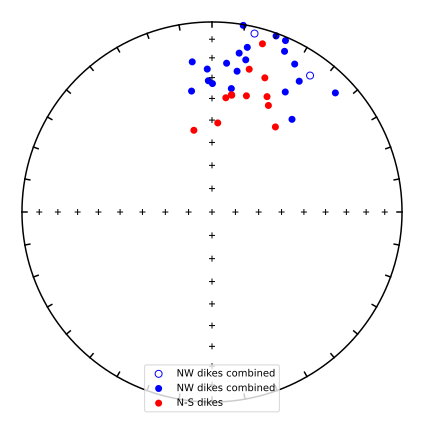

In [75]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Piedmont_NW_sites['dir_dec'].tolist(), Piedmont_NW_sites['dir_inc'].tolist(), color = 'blue', markersize = 50, label = 'NW dikes combined')
ipmag.plot_di(Smith1987a_sites_NS['dir_dec'].tolist(), Smith1987a_sites_NS['dir_inc'].tolist(), color = 'red', markersize = 50, label = 'N-S dikes')

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.legend(loc = 8)
plt.show()

In [76]:
Piedmont_NW_sites_di_block = ipmag.make_di_block(Piedmont_NW_sites['dir_dec'].tolist(), Piedmont_NW_sites['dir_inc'].tolist())
Smith1987a_sites_NS_di_block = ipmag.make_di_block(Smith1987a_sites_NS['dir_dec'].tolist(), Smith1987a_sites_NS['dir_inc'].tolist())

In [ ]:
ipmag.common_mean_bootstrap(Piedmont_NW_sites_di_block, Smith1987a_sites_NS_di_block)

In [ ]:
ipmag.common_mean_watson(Piedmont_NW_sites_di_block, Smith1987a_sites_NS_di_block)

**The combined NW dikes still do not share a common mean direction wiith the N-S dikes**

In [77]:
Piedmont_NW_sites_vgp_mean = ipmag.fisher_mean(Piedmont_NW_sites['vgp_lon'].tolist(),Piedmont_NW_sites['vgp_lat'].tolist())

print(Piedmont_NW_sites_vgp_mean)

{'dec': 66.43156956133674, 'inc': 60.72826313256136, 'n': 22, 'r': 21.075995444899608, 'k': 22.727160687772116, 'alpha95': 6.647198102586576, 'csd': 16.99074522036948}


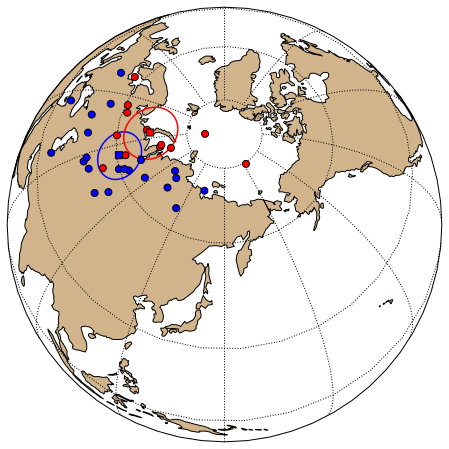

In [78]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Piedmont_NW_sites['vgp_lon'].tolist(),Piedmont_NW_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Smith NW dikes')
ipmag.plot_vgp(map_axis,Smith1987a_sites_NS['vgp_lon'].tolist(),Smith1987a_sites_NS['vgp_lat'].tolist(), 
               color = 'red', markersize = 50, label = 'Smith N-S dikes')

ipmag.plot_pole(map_axis, Piedmont_NW_sites_vgp_mean['dec'], Piedmont_NW_sites_vgp_mean['inc'], 
                Piedmont_NW_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, Smith1987a_sites_NS_vgp_mean['dec'], Smith1987a_sites_NS_vgp_mean['inc'], 
                Smith1987a_sites_NS_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

## Prevot (1989) Newark Supergroup extrusive volcanics

This study focuses on the Newwar Supergroup volcanics from the Deerfield, Hartford, and Newark basins. A total of 15 sites were reported. They describe that sites from the Talcott and Hampden basalts yield indistinguishable directions. In contrast, sites collected from the intervening Holyoke basalt yield significantly different directions characterized by a much shallower inclination and more easterly declination. 

We can see in the first equal area plot below showing all data from that study, that some of the site directions are not coherent with the otehrs, which are dominantly to the north and down. The exceptional ones are having more north-easterly and shallower up or down directions. This may be attributed to the viscosity of the samples from the site. Although the details of that viscosity measurement need to be further investigated. 

Given that this study uses AF demagnetization up to 80 mT and performs principal component analyses yielding quite well grouped directions (reasonable a95). The site level directional data should be of quite good quality. 

No tilt correction mentioned. 

It is worth noting that the geochronology data on these basalt flows are indirect and are ambiguous. Prevot (1989) referred to available data from the intrusives instead of the extrusive in the Hartford and Newark area. The Ar/Ar ages range from ~187 ± 3 Ma to 202 ± 1 Ma. This correlation between the volcanics and the intrusives is based on the paleomagnetic pole position similarity derived from the igneous units. 

Prévot, M., & McWilliams, M. (1989). Paleomagnetic correlation of Newark Supergroup volcanics. Geology, 17(11), 1007-1010. doi: 10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2.

In [79]:
Prevot1989a_sites = pd.read_csv('pmag_compiled/Prevot1989a/Prevot1989a_sites.txt', sep = '\t', header = 1)
Prevot1989a_sites = ipmag.vgp_calc(Prevot1989a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Prevot1989a_sites

site         location  dir_dec  dir_inc  dir_k  dir_n_samples  \
0      D  Deerfield basin     10.8     -6.0    258             10   
1    H1A   Hartford basin      2.8     30.6    325              5   
2    H1B   Hartford basin    358.3     33.6    275              8   
3    H2A   Hartford basin     18.5     -3.3    269              9   
4    H2B   Hartford basin     12.3     -6.8    739              5   
5    H2C   Hartford basin     29.0      5.4    700              5   
6    H3A   Hartford basin      6.0     29.6    165              8   
7    H3B   Hartford basin      1.5     32.0    191              9   
8    H3C   Hartford basin      4.8     30.4    741             10   
9    W1A     Newark basin      4.0     23.8    102              4   
10   W1B     Newark basin    354.0     26.9    222              9   
11  W2A1     Newark basin      3.1     -3.1    136              5   
12  W2A2     Newark basin     14.0     -4.4    266              5   
13   W3A     Newark basin      6.1     35.9    288              5   
14   W3B     Newark basin    359.4     34.4    366             10   

    dir_n_specimens  dir_n_total_specimens  dir_tilt_correction  dir_alpha95  \
0                10                     10                  100          2.8   
1                 5                      5                  100          3.5   
2                 8                      8                  100          3.0   
3                 9                      9                  100          2.8   
4                 5                      5                  100          2.3   
5                 5                      5                  100          2.4   
6                 8                      8                  100          3.9   
7                 9                      9                  100          3.6   
8                10                     10                  100          1.6   
9                 4                      4                  100          6.9   
10                9                      9                  100          3.1   
11                5                      5                  100          5.4   
12                5                      5                  100          3.8   
13                5                      5                  100          4.8   
14               10                     10                  100          2.4   

    ...  age_high  age_low age_unit     group  \
0   ...       194      185       Ma  Hartford   
1   ...       194      185       Ma  Hartford   
2   ...       194      185       Ma  Hartford   
3   ...       194      185       Ma  Hartford   
4   ...       194      185       Ma  Hartford   
5   ...       194      185       Ma  Hartford   
6   ...       194      185       Ma  Hartford   
7   ...       194      185       Ma  Hartford   
8   ...       194      185       Ma  Hartford   
9   ...       194      185       Ma  Hartford   
10  ...       194      185       Ma  Hartford   
11  ...       194      185       Ma  Hartford   
12  ...       194      185       Ma  Hartford   
13  ...       194      185       Ma  Hartford   
14  ...       194      185       Ma  Hartford   

                                          citations paleolatitude    vgp_lat  \
0   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     -3.008247  43.343324   
1   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     16.472905  64.453465   
2   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     18.376446  66.607416   
3   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     -1.651370  42.975774   
4   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     -3.412015  43.057669   
5   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2      2.706009  42.982402   
6   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     15.856642  63.248622   
7   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     17.350615  65.211432   
8   10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2     16.348959  64.361940   
9   10.1130/0091-7613(1989)017<10

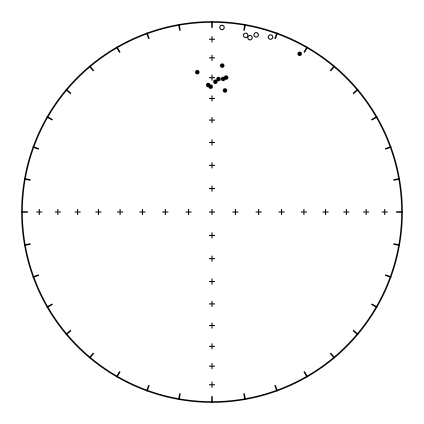

In [80]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Prevot1989a_sites['dir_dec'], Prevot1989a_sites['dir_inc'])

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [81]:
Prevot1989a_steep_sites = Prevot1989a_sites[Prevot1989a_sites['dir_inc'] >= 6]
Prevot1989a_shallow_sites = Prevot1989a_sites[Prevot1989a_sites['dir_inc'] < 6]

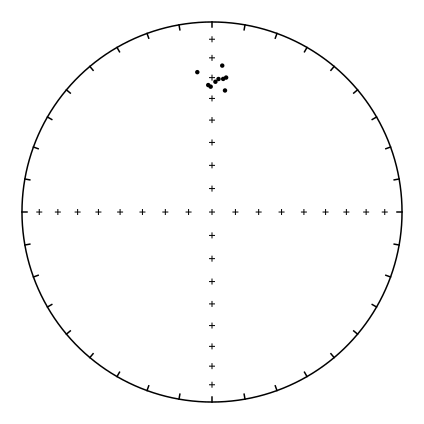

In [82]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Prevot1989a_steep_sites['dir_dec'].tolist(), Prevot1989a_steep_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

In [83]:
Prevot1989a_steep_sites_vgp_mean = ipmag.fisher_mean(Prevot1989a_steep_sites['vgp_lon'].tolist(),Prevot1989a_steep_sites['vgp_lat'].tolist())
Prevot1989a_steep_sites_vgp_mean

{'dec': 102.20583395348359,
 'inc': 65.27419283785504,
 'n': 9,
 'r': 8.975720143957863,
 'k': 329.4912451752735,
 'alpha95': 2.8405435570105917,
 'csd': 4.462344331913141}

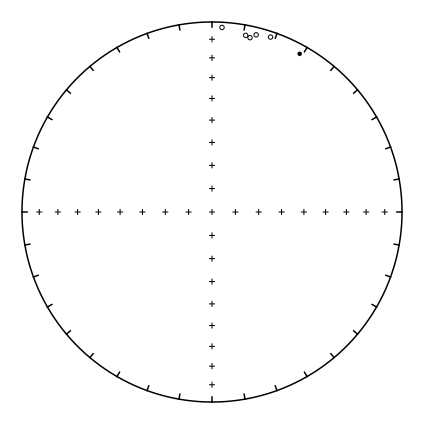

In [84]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Prevot1989a_shallow_sites['dir_dec'].tolist(), Prevot1989a_shallow_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

In [85]:
Prevot1989a_shallow_sites_vgp_mean = ipmag.fisher_mean(Prevot1989a_shallow_sites['vgp_lon'].tolist(),Prevot1989a_shallow_sites['vgp_lat'].tolist())
Prevot1989a_shallow_sites_vgp_mean

{'dec': 86.09065074615228,
 'inc': 44.66739941171945,
 'n': 6,
 'r': 5.942112766809408,
 'k': 86.37483127821348,
 'alpha95': 7.249442277107707,
 'csd': 8.715482051653545}

In [86]:
pmag.angle([102.20583395348359, 65.27419283785504], [86.09065074615228, 44.66739941171945])

array([22.43266858])

**Blackburns (2013) developed high-precision U-Pb 6-8 dates from the Palisade sill in the Orange Mountain lava in the Newark Basin, which is the oldest CAMP lavas in the Newark basin. The age of the sill is 201.520 $\pm$ 0.034 Ma. This is likey the upper bound for the paleomagnetic directions in the Newark Basin area.**

In addition, Prevot (1989) suggested that the Deerfield basalt yields a shallowly inclined direction typical of sites from the intermediate extrusives in the Newark and Hartford basins. Given that some site inclination displayed in multiple sites from different locations here are shalow---indicating a pole position farther from the NA continent, it is likely that these poles are of older age, about 201.520 Ma. The steeper directions that are dominant in number and are filtered for below might be of slightly younger age. However, the difference in mean pole position between the shallow and steep poles are about 22 degrees which is very high.

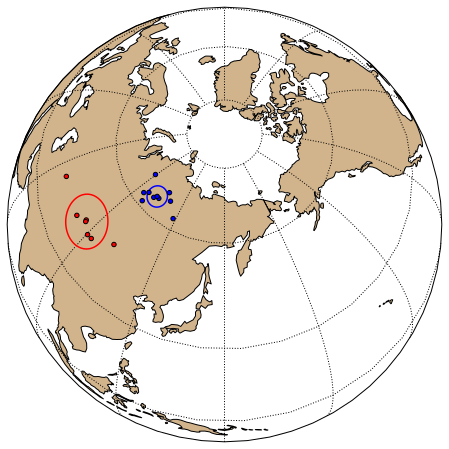

In [87]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Prevot1989a_steep_sites['vgp_lon'].tolist(),Prevot1989a_steep_sites['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_pole(map_axis, Prevot1989a_steep_sites_vgp_mean['dec'], Prevot1989a_steep_sites_vgp_mean['inc'], Prevot1989a_steep_sites_vgp_mean['alpha95'], color = 'blue')

ipmag.plot_vgp(map_axis,Prevot1989a_shallow_sites['vgp_lon'].tolist(),Prevot1989a_shallow_sites['vgp_lat'].tolist(), color = 'red')
ipmag.plot_pole(map_axis, Prevot1989a_shallow_sites_vgp_mean['dec'], Prevot1989a_shallow_sites_vgp_mean['inc'], Prevot1989a_shallow_sites_vgp_mean['alpha95'], color = 'red')

plt.show()

## Witte (1990) basalt flows in Newark Basin, New Jersey

The introduction of this more modern study in Newark basin starts off with Sutter (1988) that the Newark basalt extrusion was about ~200 Ma and a later hydrothermal event at ~175 Ma. This is suported by geochemical and field observations, and yielded an interpretation that the Talcott, Holyoke, Hampden Basalts were fed by the Firhaven, Buttress, and Bridgeport dikes (which Gordon (1984) categorized into N1 and N2 poles). Kodama (1983) and Ratcliffe (1988) also found that Palisade sill fed some of the basalt flows. The conclusion is that the associated intrusive rocks are similar in age instead of spanning a time of 20 myr. This is consistent with more modern geochronology data showing most of the igneous units in this region are around 200 Ma in age. Witte (1989) argue that the N2 pole from Fairhaven, Buttress, and Bridgeport are secondary. 

With a goal of investigating whether the direction N1 (Talcott, Holyoke, Hampden) direction is primary, this study sampled the red beds and basalt in the Newark basin. Here we are only considering the basalt units, from Orange Mountain and Preakness. They sampled top, mid, and bottom of orange Mountain and top and bottom of the Preakness Basalt. 

**They argue that the result of their interpreted ChRM is about 10 degree shallower than the McIntosh (1985) result and that is because of insufficient demagnetization of McIntosh and the 175 Ma common remagnetization across the basin. However, if this is correct and the age of 175 Ma is robust. The Newark basin can provide us with information of both 200 Ma polle position and 175 Ma pole position. But, just by looking at the directions from the basalt of this study and comparing them with those from McIntosh (1985) These sites can be considered to be combined with McIntosh (1985).**

**There is also issue about PSV. This study cites (Fedosh amd Smoot, 1988) that there are in total only 11 cooling units in the Orange Mountain, Preakness, and Hook Mountain.**

Witte, W. K., & Kent, D. V. (1990). The paleomagnetism of red beds and basalts of the Hettangian Extrusive Zone, Newark Basin, New Jersey. Journal of Geophysical Research: Solid Earth, 95(B11), 17533-17545.

In [88]:
Witte1990a_sites = pd.read_csv('pmag_compiled/Witte1990a/Witte1990a_sites.txt', sep = '\t', header = 1)
Witte1990a_sites = Witte1990a_sites[Witte1990a_sites['dir_alpha95'] < 15]
Witte1990a_sites = ipmag.vgp_calc(Witte1990a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Witte1990a_sites

site         location  dir_dec  dir_inc  dec_tc  inc_tc  dir_k  \
0  TOA  Orange Mountain      3.8     37.1   354.6    30.0    667   
1  TOB  Orange Mountain      3.2     27.8   357.0    21.5    241   
2  TOC  Orange Mountain     14.4     31.3     6.1    27.5    180   
3  TRB        Preakness     10.3     -3.9    11.8    -7.5    255   

   dir_n_samples  dir_n_specimens  dir_n_total_specimens  ...  age_unit  \
0              3                3                      3  ...        Ma   
1              4                4                      4  ...        Ma   
2              4                4                      4  ...        Ma   
3              4                4                      4  ...        Ma   

   dip_trend  dip                     group                citations  \
0        295   15  Orange_Mountain_Palisade  10.1029/jb095ib11p17533   
1        295   15  Orange_Mountain_Palisade  10.1029/jb095ib11p17533   
2        295   15  Orange_Mountain_Palisade  10.1029/jb095ib11p17533   
3        295   15                 Preakness  10.1029/jb095ib11p17533   

  paleolatitude    vgp_lat    vgp_lon vgp_lat_rev vgp_lon_rev  
0     20.713963  69.664699  95.475525  -69.664699  275.475525  
1     14.768327  63.822693  98.720906  -63.822693  278.720906  
2     16.909522  63.072536  74.047218  -63.072536  254.047218  
3     -1.952261  46.230385  90.757351  -46.230385  270.757351  

[4 rows x 31 columns]

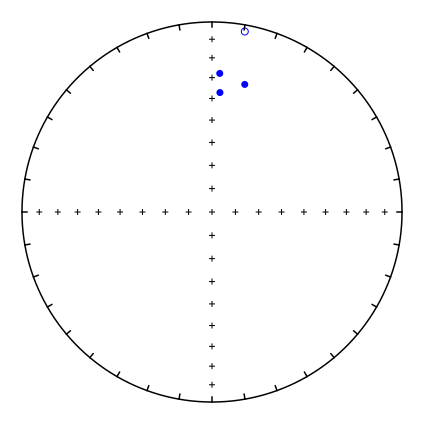

In [89]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Witte1990a_sites['dir_dec'].tolist(), Witte1990a_sites['dir_inc'].tolist(), 
              color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

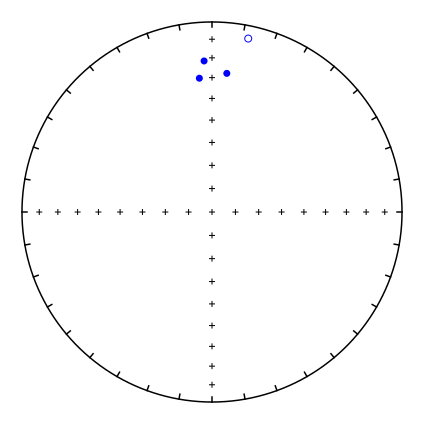

In [90]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Witte1990a_sites['dec_tc'].tolist(), Witte1990a_sites['inc_tc'].tolist(), 
              color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [91]:
Witte1990a_sites_vgp_mean = ipmag.fisher_mean(Witte1990a_sites['vgp_lon'].tolist(),
                                                      Witte1990a_sites['vgp_lat'].tolist())
Witte1990a_sites_vgp_mean

{'dec': 89.54156192094408,
 'inc': 61.03240678143352,
 'n': 4,
 'r': 3.941982429401494,
 'k': 51.70847329614387,
 'alpha95': 12.898399358495146,
 'csd': 11.264298775287038}

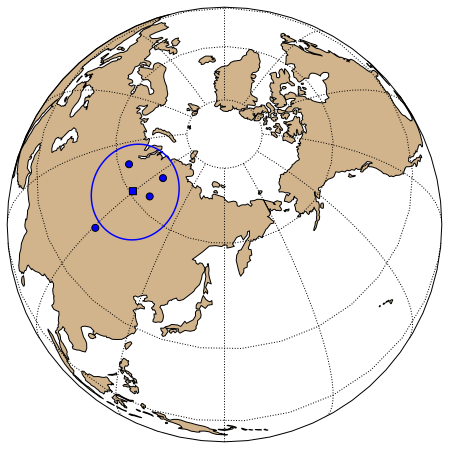

In [92]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Witte1990a_sites['vgp_lon'].tolist(), Witte1990a_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)

ipmag.plot_pole(map_axis, Witte1990a_sites_vgp_mean['dec'], Witte1990a_sites_vgp_mean['inc'], 
                Witte1990a_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

# plt.legend(loc = 8)
plt.show()

## Hozik (1992) diabase sills and dikes, and basaltic lava flows from Culpeper basin 

More paleomagnetic data from the Culpeper Basin south to the Gettysburg basin. Outcrops of sills, dikes and lava flows were sampled by a B.S. study of Carol A. Raymond in University of Georgia, and Hozik's own unpublished work. This tudy was a compilation work in review for the apparent polar wander path of Triassic and Jurassic time. A few more studies' data were also invluded in the synthesized data table, but many of them have no online copies and not well known or frequently cited y other studies. Most of them were annual meeting reports and abstracts and likely unpublished. The data from Culpeper basin from Raymond (1982) and Hozik however, have detailed site-level records in the data table here. 

The Culpeper basin is also a half-graben. The western border is bounded by a major normal fault system. The rocks have been divided into 7 seds formations, and three lava flows. A major sill is at the center of the basin from the N to S. and is intrusive into a Balls Bluff Formation. A series of dikes ocur as isolated intrusives into the Balls Bluff Formation too. The three lava flows are above the Catharpin Creek Formation and they are separated by seds. The lowest if the Mount Zion Church Basalt, about 140 m thick. It has at least two flow sheets. The middle flow is the Hickory Grove Basalt. This unit in the north is about 380 m thick and is of at least three flows. The top flow is the Sander Basalt. ranging from 140 m to 600 m, consisting at least 3 major flows. The chemistry of these basalt and diabase intrusions are high-TiO2 quartz-normative tholeiites, with some exceptions detailed in the text.

Both in-situ directions and tilt corrected directions are presented in the data table along with rather precise locations and statistics. It is worth noting that **the a95 stats provided in table are pre-tilt correction.**

Hozik, M. J. (1992). in the Culpeper, Newark, and Hartford/Deerfield basins. Eastern North American Mesozoic Magmatism, 268, 279. doi: http://dx.doi.org/10.1130/SPE268-p279. 

In [93]:
Hozik1992a_sites = pd.read_csv('pmag_compiled/Hozik1992a/Hozik1992a_sites.txt', sep = '\t', header = 1)
Hozik1992a_sites = Hozik1992a_sites[Hozik1992a_sites['dir_alpha95'] < 15]
Hozik1992a_sites = ipmag.vgp_calc(Hozik1992a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dec_tc',
    inc_is='inc_tc')
# Hozik1992a_sites

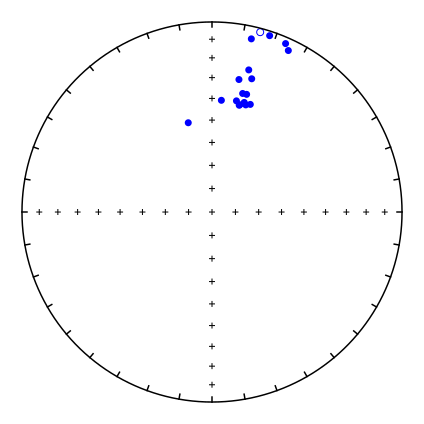

In [94]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Hozik1992a_sites['dir_dec'].tolist(), Hozik1992a_sites['dir_inc'].tolist(), 
              color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

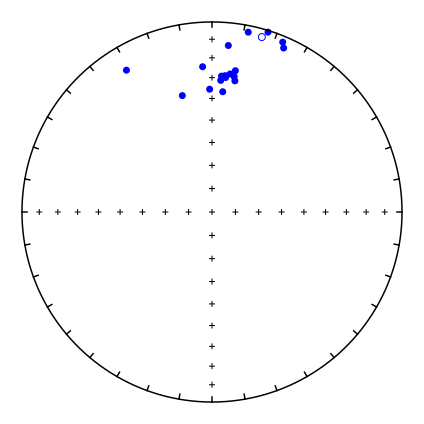

In [95]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Hozik1992a_sites['dec_tc'].tolist(), Hozik1992a_sites['inc_tc'].tolist(), 
              color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [96]:
Hozik1992a_sites_vgp_mean = ipmag.fisher_mean(Hozik1992a_sites['vgp_lon'].tolist(),
                                                      Hozik1992a_sites['vgp_lat'].tolist())
Hozik1992a_sites_vgp_mean

{'dec': 90.07667380394147,
 'inc': 62.2484213584474,
 'n': 19,
 'r': 18.451059548786343,
 'k': 32.790441950859446,
 'alpha95': 5.9500473673504475,
 'csd': 14.145274633861934}

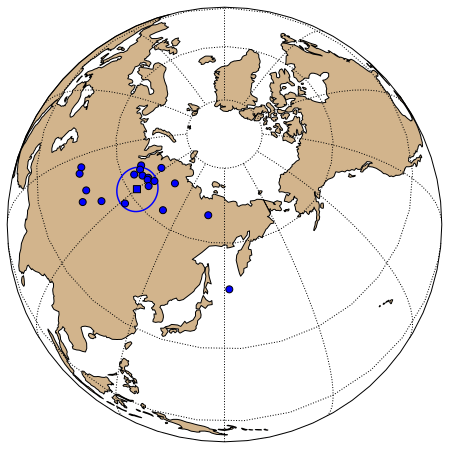

In [97]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Hozik1992a_sites['vgp_lon'].tolist(), Hozik1992a_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)

ipmag.plot_pole(map_axis, Hozik1992a_sites_vgp_mean['dec'], Hozik1992a_sites_vgp_mean['inc'], 
                Hozik1992a_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

# plt.legend(loc = 8)
plt.show()

## Kodama (1994) Sassamansville diabase in Newark basin, southeastern Pennsylvania

Continuing on Witte (1990)'s work, Kodama in this study sample the Sassamansville diabase and was further exploring the primary and secondaty magnetizations of these units and their ages. They argued that "A partial tilt correction may be the best geologic and paleomagnetic interpretation because it would minimize the amount of post-175 Ma tectonic activity required while bringing the Newark (B component) remagnetization paleopole into aleolatitudinal agreement with a paleopole derived from the rotation of European, South American, and African data into North American coordinates (Van der Voo, 1992)." The center of investigation is the N1 and N2 pole from Smith (1979) and Gordon (1984). 

The dikes are high-TiO2 quartz normative tholeiitic. There are field relationships and geophysical data (Ratcliffe 1988; Kodama 1983) that suggest connection between intrusive rocks and lava flows in the northern part of the Newark basin. Olsen (1989) suggested very short time period for the eruption of these igneous rocks. This is consistent with more recent geochronology data and that many LIP events are short lived, or pulsed. 

Modern paleomagnetic techniques were applied to the rocks. Progressive AF and thermal demagnetizations were carried out and pricipal component analyses with least-square best fit lines were used for directional data analyses. The site 10 in this study have samples from boulders that are out of place and yielded large a95 statistics. Thus it will not be included for further analyses. Rock magnetic results indicate Fe-Ti oxides as primary carrier of magnetizations. 

**The tricky part of this study comes with the failed baked contact test and a partial fold test. Note: no data on the width of the dikes were reported. The contact test was performed on the hornfels that is believed to be heated and magnetized during the dike intrusion. The hornfels site is 40 meters away from the site 6 dike. However, the paleomagnetic data from the hornfels is tightly clustered but away from the direction of th dike of site 6, whose direction is actually consistent with the secondary/remagnetization components from sediments in Passaic formation and from Witte (1990). See figure 6(B) Therefore, the authors of this study claimed that the dikes were remagnetized during this hydrothermal event after the emplacement together with the sediments, and the hornfels captured a maybe original magnetization.They also mentioned a second population of hornfels, with light gray color, which has similar direction as the diabase. It is the dark gray hornfels that have directions distinct from the diabase. However, it is boggling that why not all the hornfels suffered from the hydrothermal event. What is also interesting is that we don't see the hornfels direction in the only specimen orthogonal plots shown in figure 2.**

**Here we don't know how much tilt correction (unfolding) we should apply to these sites, although statistically at 65% unfolding the concentration parameter k for the site mean data is the largest. In text they did say that the mean direction before and after 65% unfolding is distinguishable. at 97.5% confidence level.**

*Based on Sutter (1988), the evidence for widespread hydrothermal event is based on argon closure ages for k-spar from granophyre rocks associated with diabase in the Newark and Culpeper basins.*

Kodama, K. P., & Mowery, A. (1994). Paleomagnetism of the Sassamansville diabase, Newark Basin, southeastern Pennsylvania: support for Middle Jurassic high-latitude paleopoles for North America. Geological Society of America Bulletin, 106(7), 952-961. doi: http://dx.doi.org/10.1130/0016-7606(1994)106<0952:POTSDN>2.3.CO;2. 

In [150]:
Kodama1994a_sites = pd.read_csv('pmag_compiled/Kodama1994a/Kodama1994a_sites.txt', sep = '\t', header = 1)
Kodama1994a_sites = Kodama1994a_sites[Kodama1994a_sites['dir_alpha95'] < 15]
Kodama1994a_sites = ipmag.vgp_calc(Kodama1994a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Kodama1994a_sites

site        location  dir_dec  dir_inc  dir_k  dir_n_samples  \
0     1  Sassamansville    352.7     43.6  152.5             10   
1     2  Sassamansville    341.3     44.3  354.1              9   
2     3  Sassamansville    338.1     40.4   14.0              9   
3     4  Sassamansville    359.5     49.6  318.6              9   
4     5  Sassamansville    284.9     33.3   27.1              8   
5     6  Sassamansville    353.4     36.3  801.5              9   
6     7  Sassamansville    350.7     65.6  121.5              8   
7     8  Sassamansville      6.0     48.1   82.8              8   
8     9  Sassamansville    335.2     60.3  105.9              5   

   dir_n_specimens  dir_n_total_specimens  dir_tilt_correction  dir_alpha95  \
0               10                     10                  NaN          3.6   
1                9                      9                  NaN          2.5   
2                9                      9                  NaN         12.5   
3                9                      9                  NaN          2.5   
4                8                      8                  NaN          9.5   
5                9                      9                  NaN          1.7   
6                8                      8                  NaN          4.5   
7                8                      8                  NaN          5.4   
8                5                      5                  NaN          6.1   

   ...  age_unit  dip_trend dip                         group  \
0  ...        Ma         20   7  Gettysburg_Newark_York_Haven   
1  ...        Ma          0   0  Gettysburg_Newark_York_Haven   
2  ...        Ma          0   0  Gettysburg_Newark_York_Haven   
3  ...        Ma        350  24  Gettysburg_Newark_York_Haven   
4  ...        Ma          0   0  Gettysburg_Newark_York_Haven   
5  ...        Ma        242  20  Gettysburg_Newark_York_Haven   
6  ...        Ma          5  27  Gettysburg_Newark_York_Haven   
7  ...        Ma        350  15  Gettysburg_Newark_York_Haven   
8  ...        Ma        356  20  Gettysburg_Newark_York_Haven   

                                         citations paleolatitude    vgp_lat  \
0  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     25.461154  73.912848   
1  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     26.009116  68.859062   
2  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     23.051371  64.714642   
3  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     30.434151  80.157851   
4  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     18.182177  22.835902   
5  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     20.167603  69.038717   
6  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     47.784420  80.019258   
7  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     29.129136  77.688505   
8  10.1130/0016-7606(1994)106<0952:potsdn>2.3.co;2     41.237589  71.252309   

      vgp_lon  vgp_lat_rev vgp_lon_rev  
0  128.916311   -73.912848  308.916311  
1  157.483602   -68.859062  337.483602  
2  157.922864   -64.714642  337.922864  
3  107.055739   -80.157851  287.055739  
4  199.415944   -22.835902   19.415944  
5  122.070266   -69.038717  302.070266  
6  245.693300   -80.019258   65.693300  
7   79.172233   -77.688505  259.172233  
8  205.455388   -71.252309   25.455388  

[9 rows x 29 columns]

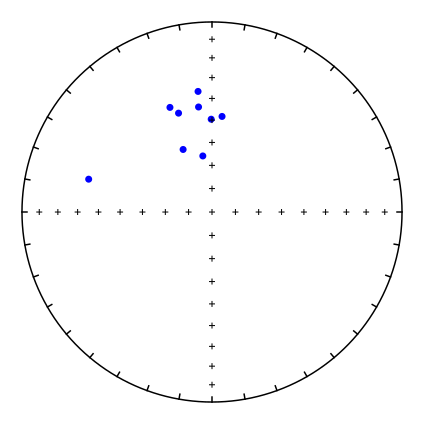

In [99]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Kodama1994a_sites['dir_dec'].tolist(), Kodama1994a_sites['dir_inc'].tolist(), 
              color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [151]:
Kodama1994a_sites_vgp_mean = ipmag.fisher_mean(Kodama1994a_sites['vgp_lon'].tolist(),
                                                      Kodama1994a_sites['vgp_lat'].tolist())
Kodama1994a_sites_vgp_mean

{'dec': 165.8637881386153,
 'inc': 73.28384469010547,
 'n': 9,
 'r': 8.367330444697465,
 'k': 12.64483162331796,
 'alpha95': 15.059634661825738,
 'csd': 22.778676850126548}

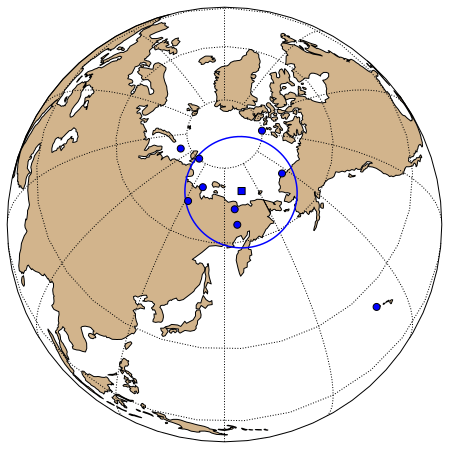

In [152]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Kodama1994a_sites['vgp_lon'].tolist(), Kodama1994a_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)

ipmag.plot_pole(map_axis, Kodama1994a_sites_vgp_mean['dec'], Kodama1994a_sites_vgp_mean['inc'], 
                Kodama1994a_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

# plt.legend(loc = 8)
plt.show()

## Opdyke (1966) White Mountain gabbros, monzonites, diorites in New Hampshire and Vermont 

The Moat volcanics which is an important pole used in Kent (2015) is geologically related to the White Mountain pluton. Specifically, VanFossen (1990) (below) says the Moat volcanics is intruded by the Conway granite of the White Mountain batholith. Opdyke happed to be sampling gabbros, monzonites, and diorites of the White Mountains. Although none of the samples is granite, they nevertheless provide insights into the paleomagnetic poles from White Mountain side. 

In the text authors stated that the White Mountain plutonic-volcanic series in New Hampshire and eastern Vermont is compsosed of a series of intrusives with associated extrusives. The intrusives range in composition from gabbro to granite. **The basic rocks are always the oldest; no major tectonic phenomena have taken place in the area since the emplacement of the series (can be argued for no structural correction) **

Specimens were AF demagnetized up to 50 mT, most specimen had up to 25 mT to remove the "unstable component". 

The result is interesting in terms that there are both polarities recorded in the rocks and that the normal directions are steeper than the reversed ones, which might imply that the normal rocks have a younger age than the reversed ones. (given that we roughly know how the pole path is). Grouping the sites by polarity, we see that the gabbros together with the extrusive basalt flow (one site) and the essexite are reversed and the monzonite and lamprophyre are normal. No rock type have both polarities. 

**It is interesting that this study provided reference through K-Ar, Rb-Sr and U-Pb age of the Conway granite that is about 180 Ma (Tilton 1957, Hurley 1960 --- both used Redstone Conway granite). Reflecting on the current data of the Moat Volcanics---at least 10 Myr older than 169 Ma. Surprisingly consistent.**

This paper also refers to a couple of studies from intrusive units in California about same time. 

Opdyke, N. D., & Wensink, H. (1966). Paleomagnetism of rocks from the White Mountain plutonic‐volcanic series in New Hampshire and Vermont. Journal of Geophysical Research, 71(12), 3045-3051. doi: http://dx.doi.org/10.1029/JZ071i012p03045. 

In [102]:
Opdyke1966a_sites = pd.read_csv('pmag_compiled/Opdyke1966a/Opdyke1966a_sites.txt', sep='\t', header = 1)
Opdyke1966a_sites = Opdyke1966a_sites[Opdyke1966a_sites['dir_alpha95'] < 15]
Opdyke1966a_sites = ipmag.vgp_calc(Opdyke1966a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Opdyke1966a_sites

site        location                               note  dir_dec  dir_inc  \
0     7  White Mountain                                NaN    161.0    -59.0   
1    11  White Mountain  Essexite is nepheline monzogabbro      1.0     65.5   
2     1  White Mountain                                NaN    200.0    -52.5   
3     2  White Mountain                                NaN    184.0    -55.0   
4     3  White Mountain                                NaN    191.0    -57.0   
5     6  White Mountain                                NaN    168.0    -57.5   
6     8  White Mountain                                NaN    165.5    -49.5   
7     A  White Mountain                                NaN    153.0    -52.0   
8     B  White Mountain                                NaN    146.0    -55.0   
9    12  White Mountain                                NaN      5.0     63.0   
10    4  White Mountain                                NaN      0.0     65.0   
11    5  White Mountain                                NaN      2.0     59.0   
12    9  White Mountain                                NaN    352.0     58.5   
13   10  White Mountain                                NaN    351.0     58.0   

    dir_k  dir_n_samples  dir_n_specimens  dir_n_total_specimens  \
0     162             12               12                     12   
1     135              8                8                      8   
2      93             12               12                     12   
3      47             12               12                     12   
4      26             11               11                     11   
5      34             12               12                     12   
6      52             12               12                     12   
7     384             12               12                     12   
8     308             12               12                     12   
9     581             10               10                     10   
10     54              6                6                      6   
11     65             11               11                     11   
12     62             12               12                     12   
13    150             12               12                     12   

    dir_tilt_correction  ...  result_type  age  age_unit       group  \
0                     0  ...            i  180        Ma  White_Moat   
1                     0  ...            i  180        Ma  White_Moat   
2                     0  ...            i  180        Ma  White_Moat   
3                     0  ...            i  180        Ma  White_Moat   
4                     0  ...            i  180        Ma  White_Moat   
5                     0  ...            i  180        Ma  White_Moat   
6                     0  ...            i  180        Ma  White_Moat   
7                     0  ...            i  180        Ma  White_Moat   
8                     0  ...            i  180        Ma  White_Moat   
9                     0  ...            i  180        Ma  White_Moat   
10                    0  ...            i  180        Ma  White_Moat   
11                    0  ...            i  180        Ma  White_Moat   
12                    0  ...            i  180        Ma  White_Moat   
13                    0  ...            i  180        Ma  White_Moat   

                  citations paleolatitude    vgp_lat     vgp_lon vgp_lat_rev  \
0   10.1029/jz071i012p03045    -39.765187 -75.277566    8.503392   75.277566   
1   10.1029/jz071i012p03045     47.652314  86.203195  298.706537  -86.203195   
2   10.1029/jz071i012p03045    -33.088776 -71.205531  226.117607   71.205531   
3   10.1029/jz071i012p03045    -35.529645 -81.381975  266.657718   81.381975   
4   10.1029/jz071i012p03045    -37.593842 -79.737312  230.859854   79.737312   
5   10.1029/jz071i012p03045    -38.126340 -79.244214  349.739429   79.244214   
6   10.1029/jz071i012p03045    -30.345764 -72.190369  333.477999   72.190369   
7   10.1029/jz071i012p03045    -32.618057 -66.281925    0.42

In [103]:
Opdyke1966a_sites_normal = Opdyke1966a_sites[Opdyke1966a_sites['vgp_lat'] >= 0]
Opdyke1966a_sites_reversed = Opdyke1966a_sites[Opdyke1966a_sites['vgp_lat'] < 0]

Opdyke1966a_sites_normal_mean = ipmag.fisher_mean(Opdyke1966a_sites_normal['vgp_lon'].tolist(), 
                                                  Opdyke1966a_sites_normal['vgp_lat'].tolist())
Opdyke1966a_sites_reversed_mean = ipmag.fisher_mean(Opdyke1966a_sites_reversed['vgp_lon_rev'].tolist(), 
                                                    Opdyke1966a_sites_reversed['vgp_lat_rev'].tolist())

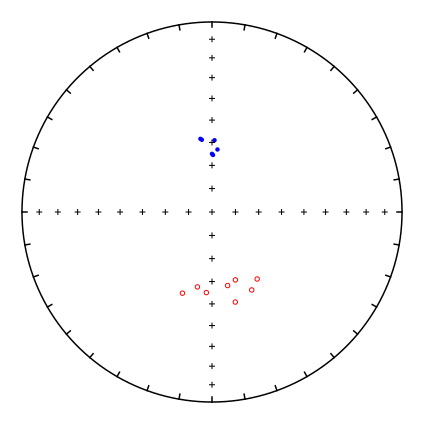

In [104]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Opdyke1966a_sites_normal['dir_dec'].tolist(), Opdyke1966a_sites_normal['dir_inc'].tolist(), color = 'blue')
ipmag.plot_di(Opdyke1966a_sites_reversed['dir_dec'].tolist(), Opdyke1966a_sites_reversed['dir_inc'].tolist(), color = 'red')

# plt.legend(loc = 8)
plt.show()

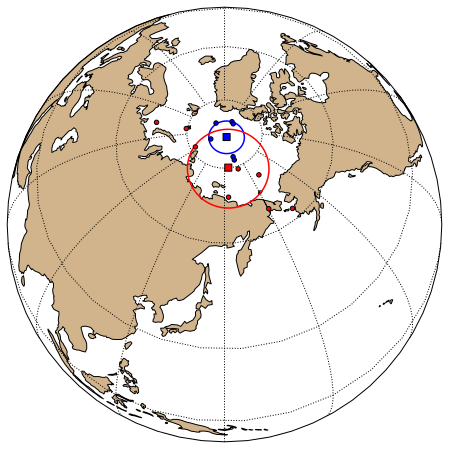

In [105]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Opdyke1966a_sites_normal['vgp_lon'].tolist(), Opdyke1966a_sites_normal['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis,Opdyke1966a_sites_reversed['vgp_lon_rev'].tolist(), Opdyke1966a_sites_reversed['vgp_lat_rev'].tolist(), color = 'red')

ipmag.plot_pole(map_axis, Opdyke1966a_sites_normal_mean['dec'], Opdyke1966a_sites_normal_mean['inc'], 
                Opdyke1966a_sites_normal_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, Opdyke1966a_sites_reversed_mean['dec'], Opdyke1966a_sites_reversed_mean['inc'], 
                Opdyke1966a_sites_reversed_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

In [ ]:
ipmag.reversal_test_bootstrap(Opdyke1966a_sites['dir_dec'].tolist(), Opdyke1966a_sites['dir_inc'].tolist())

In [ ]:
ipmag.reversal_test_MM1990(Opdyke1966a_sites['dir_dec'].tolist(), Opdyke1966a_sites['dir_inc'].tolist())

In [106]:
# combining both normal and reversedpoles?
White_Mountains_vgp_lon = list()
White_Mountains_vgp_lat = list()

White_Mountains_vgp_lon.extend(Opdyke1966a_sites_normal['vgp_lon'].tolist())
White_Mountains_vgp_lon.extend(Opdyke1966a_sites_reversed['vgp_lon_rev'].tolist())
White_Mountains_vgp_lat.extend(Opdyke1966a_sites_normal['vgp_lat'].tolist())
White_Mountains_vgp_lat.extend(Opdyke1966a_sites_reversed['vgp_lat_rev'].tolist())

White_Mountains_vgp_mean = ipmag.fisher_mean(White_Mountains_vgp_lon, White_Mountains_vgp_lat)

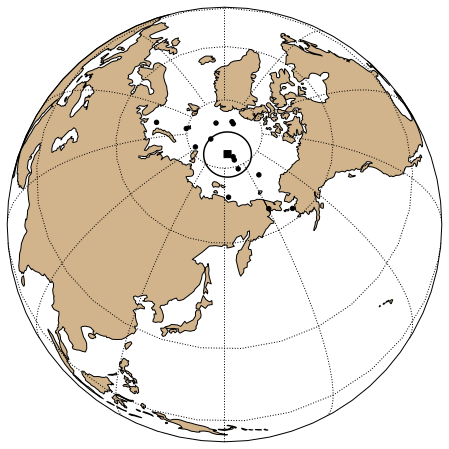

In [107]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,White_Mountains_vgp_lon, White_Mountains_vgp_lat, color = 'black')

ipmag.plot_pole(map_axis, White_Mountains_vgp_mean['dec'], White_Mountains_vgp_mean['inc'], 
                White_Mountains_vgp_mean['alpha95'], color = 'black', marker = 's', markersize = 50)
plt.show()

## VanFossen(1990) Plutons and Moat Volcanics

Both the plutons and Moat volcanics have dates around 169 Ma, and they both display a pole position that is indistinguishable with the spin axis. The volcanics show normal and reversed polarities and aid in the argument that the spin-axis pole is not a present day field overprint.

They sampled Conway granite from White Mountain batholith; a diorite plug and Albany quartz syenite from Mount Kearsag; in Belknap Mountains they sampled quartz syenite and quartz diorite from ring dikes, 
They sampled extrusive effusive Moat Volcanics pyroclastic quartz trachyte and comendite flows,ashflow tuffs and breccia.


The Conway granite is younger than the syenite from around Kearsag; the moat volcanics is reported to be intruded by the Conway granite which has been dated to be 168 ± 3 Ma, this is interpreted to be the minimum age of the Moat Volcanics. **A recent 54th Northeastern section GSA meeting abstract https://gsa.confex.com/gsa/2019NE/webprogram/Paper327960.html suggest that the age of the Moat volcanics is much older (~10 Myr) than 168 Ma. But no detailed result is presented on the online abstract.**


Van Fossen, M. C., & Kent, D. V. (1990). High‐latitude paleomagnetic poles from Middle Jurassic plutons and moat volcanics in New England and the controversy regarding Jurassic apparent polar wander for North America. Journal of Geophysical Research: Solid Earth, 95(B11), 17503-17516. doi:10.1029/JB095iB11p17503.

In [142]:
VanFossen1990a_sites = pd.read_csv('pmag_compiled/VanFossen1990a/VanFossen1990a_sites.txt', sep = '\t', header = 1)
VanFossen1990a_sites = VanFossen1990a_sites[VanFossen1990a_sites['dir_tilt_correction'] == 100] 
VanFossen1990a_sites

age age_unit   citations conglomerate_test contact_test country  \
0  182.3       Ma  This study                ND           ND  U.S.A.   

                                         description  dir_alpha95  dir_dec  \
0  Minimum age from intruding Conway Granite (168...          5.0    183.4   

   dir_inc  ...  geological_province_sections              lithologies  \
0    -55.5  ...                Moat Volcanics  Breccia : Tuff:Trachyte   

         location  lon_e                 method_codes  result_type  \
0  Moat Volcanics  288.9  DE-DI:LT-AF-Z:LT-T-Z:LP-DC4            i   

  pole_comp_name vgp_lon vgp_lat       group  
0              C    89.7    81.6  White_Moat  

[1 rows x 28 columns]

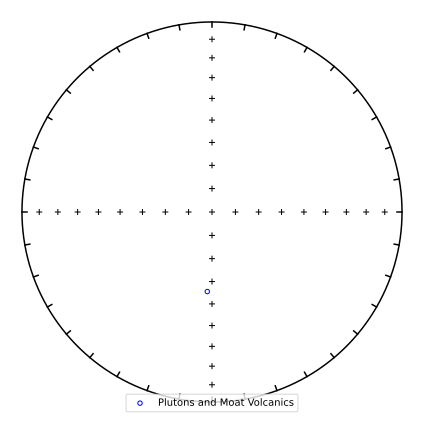

In [143]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(VanFossen1990a_sites['dir_dec'].tolist(), VanFossen1990a_sites['dir_inc'].tolist(), color = 'blue', label = 'Plutons and Moat Volcanics')

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

**Above is what is presented on MagIC database**

However, this publication is an early study and appears to be messy with today's judgement. Also often it is being taken in many recent compilation studies related to this APW takes the word for it and just uses the Cr component from the Moat volcanics, excluding all other directions from the plutons or other components from the volcanics. It is worth noting that Torsvik 2012 compilation too, just uses the Cr component. Here we will just use that pole.

What is also ambiguous is the age constraint for this unit. The authors of this paper present aan age without uncertainty quoting a personal communication with J. Creasy. However, to properly deploy a model setup for Bayesian analyses, we need some age uncertainty for this unit. There exsit an age for the plutonic rocks in the area of 169 ± 8 Ma, also a K-Ar age on biotite in pluton with age 168 ± 3 Ma (Foland et al., 1971). However, these uncertainties may not represent the age of the entire activity of plutonic activity during thsi period, as referred in this paper there are intrusive units of ages from 175 Ma to 160 Ma.

In [110]:
pole_means.loc['Moat_volcanics'] = pd.Series({'PoleName' : 'Moat Volcanics',
                                        'SLat' : 47.443,
                                        'SLon' : 44.08,
                                        'PLat' : 81.6,
                                        'PLon' : 89.7,
                                        'A95' : 5,
                                        'K' : round(140*140/7.4/7.4/9, 1),
                                        'N' : int(9),
                                        'PolarityZone' : 'Moat early reversed',
                                        'PmagRef' : 'Van-Fossen & Kent, 1990',
                                        'AgeNominal' : 169,
                                        'AgeLower' : 169-8,
                                        'AgeUpper' : 169+8,
                                        'AgeInfo' : 'Rb-Sr age fro mplutonic rocks associated with the Moat Volcanics',
                                        'AgeRef' : 'VanFossen & Kent, 1990',
                                        'Gaussian_2sigma': 8, 
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C0'})

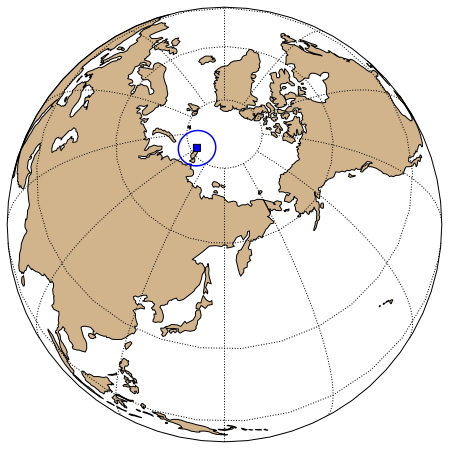

In [144]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_pole(map_axis, VanFossen1990a_sites['vgp_lon'].tolist()[0], VanFossen1990a_sites['vgp_lat'].tolist()[0], 5, color = 'blue', marker = 's', markersize = 50)
plt.show()

## Kent(2015) kimberlites in Triple B and Peddie

This study sampled kimberlites, a type of ultramafic rock sourced from great deapth in mantle. The significance of these samples is that the kimberlites have been dated to be around 150 Ma, which is middle between the stand still pole near 160 Ma and the 140 Ma pole after the Monster Shift. It can provide suppport for a constant, rapid shift rate.

Geochronology data acquired using U-Pb dating on perovskite, a Ca-Ti oxide mineral. 

The idea of the origin of the magnetization in this kimberlite is proposed to be not of TRM, but of ChRM by hydrothermal fluids circulating after the emplacement of kimberlite from great depth and precipitating out magnetite. 

Site Peddie and Triple B:
Paleomagnetism data acquired using the kimberlite resulted in tightly clustered directions, with both polarities from samples of different localities. Curie temperature of 575 indicate magnetite/titanomagnetitte to be dominant carriers. However, the very small A95 -- super tight cluster of ChRM directions makes it suspicious that the secular variation is properly averaged. The authors argue that the formation of magnetite is likely not at great-depth where kimberlite forms but at shallower depth during the late stage crystallization or thermochemical interaction between kimberlite and hydrothermal fluids. With these proposed schemes, it is likely that the duration of magnetite formation is long enough for secular variation averaging. 

The age constraint on this unit is 206Pb/238U date on perovskite from the groundmass of the kimberlite. 

Kent, D. V., B. A. Kjarsgaard, J. S. Gee,
G. Muttoni, and L. M. Heaman (2015), Tracking the Late Jurassic apparent (or true) polar shift in U-Pb-dated kimberlites from cratonic North America (Superior Province of Canada), Geochem. Geophys. Geosyst., 16, 983– 994, doi:10.1002/2015GC005734.

In [112]:
# importing sample level data from Kent 2015
Kent2015_samples = pd.read_csv('pmag_compiled/Kent2015a/Kent2015a_samples.txt', sep = '\t', header = 1)
Kent2015_samples['sample'].unique()

array(['JBBB01', 'JBBB02', 'JBBB03', 'JBBB04', 'JBBB05', 'JBBB06',
       'JBBB07', 'JBBB08', 'JBBB09', 'JBBB10', 'JBBB11', 'JBBB12',
       'JBBB13', 'JBBB14', 'JBBB15', 'JPED01', 'JPED02', 'JPED03a',
       'JPED03b', 'JPED04', 'JPED05', 'JPED06', 'JPED07', 'JPED08',
       'JPED09', 'JPED10', 'JPED11', 'JPED12', 'JPED13', 'JPED14',
       'JPED15', 'JPED16', 'JPED17', 'JPED18', 'JPED19', 'JPED31',
       'JPED32', 'JPED33', 'JPED34'], dtype=object)

In [113]:
Kent2015_samples = Kent2015_samples.drop(Kent2015_samples[Kent2015_samples['sample'] == 'JPED13'].index)
Kent2015_samples = ipmag.vgp_calc(Kent2015_samples, site_lon='lon', tilt_correction='no', site_lat='lat', dec_is = 'dir_dec', inc_is = 'dir_inc')

Kent2015_tripleB_samples = Kent2015_samples[Kent2015_samples['location'] == 'Triple B']
Kent2015_Peddie_samples = Kent2015_samples[Kent2015_samples['location'] == 'Peddie']
Kent2015_Nipissing_samples = Kent2015_samples[Kent2015_samples['location'] == 'Nipissing']

In [114]:
Kent2015_tripleB_mean = ipmag.fisher_mean(Kent2015_tripleB_samples['dir_dec'].tolist(), Kent2015_tripleB_samples['dir_inc'].tolist())
Kent2015_Peddie_mean = ipmag.fisher_mean(Kent2015_Peddie_samples['dir_dec'].tolist(), Kent2015_Peddie_samples['dir_inc'].tolist())
Kent2015_Nipissing_mean = ipmag.fisher_mean(Kent2015_Nipissing_samples['dir_dec'].tolist(), Kent2015_Nipissing_samples['dir_inc'].tolist())

In [115]:
print(Kent2015_tripleB_mean)
print(Kent2015_Peddie_mean)
print(Kent2015_Nipissing_mean)

{'dec': 162.2541558411837, 'inc': -65.40210462215336, 'n': 15, 'r': 14.913542605863027, 'k': 161.92946988224077, 'alpha95': 3.0139264176590097, 'csd': 6.365346825545106}
{'dec': 336.94411942483396, 'inc': 61.889878261211024, 'n': 19, 'r': 18.895316256709137, 'k': 171.94646880353815, 'alpha95': 2.5666824849756775, 'csd': 6.1771534244763275}
{'dec': 359.584287086439, 'inc': -55.13952128427369, 'n': 4, 'r': 3.9874134579401144, 'k': 238.34981726722646, 'alpha95': 5.963477304975023, 'csd': 5.24659579965618}


**Note the calculation for the triple B kimberlite pole shown above**

It is clear that the cited calculation results in the paper of Kent 2015 is wrong. They mistakened the k value, 161.9 for the mean declination for this site. The actual mean value is close, but nevertheless is different. It should be 162.3 for dec.

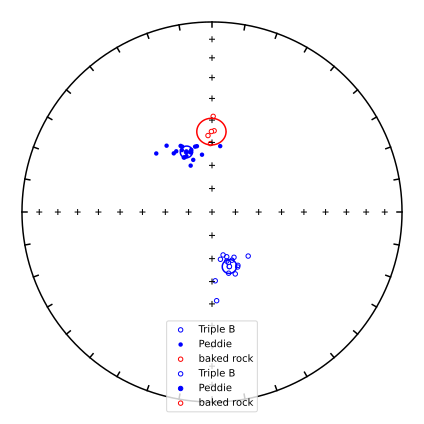

In [116]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Kent2015_tripleB_samples['dir_dec'].tolist(), Kent2015_tripleB_samples['dir_inc'].tolist(), color = 'blue', label = 'Triple B')
ipmag.plot_di(Kent2015_Peddie_samples['dir_dec'].tolist(), Kent2015_Peddie_samples['dir_inc'].tolist(), color = 'blue', label = 'Peddie')
ipmag.plot_di(Kent2015_Nipissing_samples['dir_dec'].tolist(), Kent2015_Nipissing_samples['dir_inc'].tolist(), color = 'red', label = 'baked rock')

ipmag.plot_di_mean(Kent2015_tripleB_mean['dec'], Kent2015_tripleB_mean['inc'], Kent2015_tripleB_mean['alpha95'], color = 'blue', label = 'Triple B')
ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')
ipmag.plot_di_mean(Kent2015_Nipissing_mean['dec'], Kent2015_Nipissing_mean['inc'], Kent2015_Nipissing_mean['alpha95'], color = 'red', label = 'baked rock')

plt.legend(loc = 8)
plt.show()

### Reversal test between triple B and peddie kimberlites

In [117]:
Kent2015_tripleB_peddie = pd.concat([Kent2015_tripleB_samples, Kent2015_Peddie_samples])

In [ ]:
ipmag.reversal_test_bootstrap(Kent2015_tripleB_peddie['dir_dec'].tolist(), Kent2015_tripleB_peddie['dir_inc'].tolist())

In [ ]:
ipmag.reversal_test_MM1990(Kent2015_tripleB_peddie['dir_dec'].tolist(), Kent2015_tripleB_peddie['dir_inc'].tolist())

**They barely passed the reversal test!**

However, one could attribute this issue to the fact that both polarites are so tightly constrained, the A95 ellipses are too small.

In [118]:
Kent2015_tripleB_VGP_mean = ipmag.fisher_mean(Kent2015_tripleB_samples['vgp_lon_rev'].tolist(), Kent2015_tripleB_samples['vgp_lat_rev'].tolist())
Kent2015_Peddie_VGP_mean = ipmag.fisher_mean(Kent2015_Peddie_samples['vgp_lon'].tolist(), Kent2015_Peddie_samples['vgp_lat'].tolist())

In [119]:
print(Kent2015_tripleB_VGP_mean)
print(Kent2015_Peddie_VGP_mean)

{'dec': 198.86072807078588, 'inc': 77.87241595817281, 'n': 15, 'r': 14.83741041781541, 'k': 86.10637786193183, 'alpha95': 4.144134900055902, 'csd': 8.72905758582506}
{'dec': 184.09004576198237, 'inc': 73.47453918272288, 'n': 19, 'r': 18.785047132895986, 'k': 83.73928779135551, 'alpha95': 3.689043605222943, 'csd': 8.85157161522252}


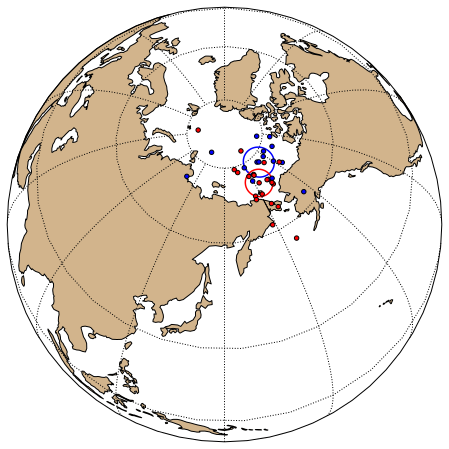

In [120]:
map_axis = ipmag.make_orthographic_map(150, 65)
ipmag.plot_vgp(map_axis, Kent2015_tripleB_samples['vgp_lon_rev'].tolist(), Kent2015_tripleB_samples['vgp_lat_rev'].tolist(), 
               color = 'blue', label = 'Triple B')
ipmag.plot_vgp(map_axis, Kent2015_Peddie_samples['vgp_lon'].tolist(), Kent2015_Peddie_samples['vgp_lat'].tolist(), 
               color = 'red', label = 'Peddie')

ipmag.plot_pole(map_axis, Kent2015_tripleB_VGP_mean['dec'], Kent2015_tripleB_VGP_mean['inc'], Kent2015_tripleB_VGP_mean['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, Kent2015_Peddie_VGP_mean['dec'], Kent2015_Peddie_VGP_mean['inc'], Kent2015_Peddie_VGP_mean['alpha95'], color = 'red')

plt.show()

In [ ]:
pole_means.loc['Triple_B_kimberlite'] = pd.Series({'PoleName' : 'Triple B kimberlites',
                                        'SLat' : 47.454,
                                        'SLon' : 360-79.762,
                                        'PLat' : round(Kent2015_tripleB_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_tripleB_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_tripleB_VGP_mean['alpha95'],1),
                                        'K' : round(Kent2015_tripleB_VGP_mean['k'],1),
                                        'N' : int(Kent2015_tripleB_VGP_mean['n']),
                                        'PolarityZone' : 'Triple B reversed',
                                        'PmagRef' : 'Kent et al., 2015',
                                        'AgeNominal' : 157.5,
                                        'AgeLower' : 157.5-1.2,
                                        'AgeUpper' : 157.5+1.2,
                                        'AgeInfo' : 'U-Pb date on perovskite from kimberlite yielding 157.5 $\pm$ 1.2 Ma)',
                                        'AgeRef' : 'Kent et al., 2015',
                                        'Gaussian_2sigma': 1.2,                                                   
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C2'})

In [ ]:
pole_means.loc['Peddie_kimberlite'] = pd.Series({'PoleName' : 'Peddie kimberlites',
                                        'SLat' : 47.443,
                                        'SLon' : 360-79.682,
                                        'PLat' : round(Kent2015_Peddie_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_Peddie_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_Peddie_VGP_mean['alpha95'],1),
                                        'K' : round(Kent2015_Peddie_VGP_mean['k'],1),
                                        'N' : int(Kent2015_Peddie_VGP_mean['n']),
                                        'PolarityZone' : 'Peddie normal',
                                        'PmagRef' : 'Kent et al., 2015',
                                        'AgeNominal' : 154.9,
                                        'AgeLower' : 154.9-1.1,
                                        'AgeUpper' : 154.9+1.1,
                                        'AgeInfo' : 'U-Pb date on perovskite from kimberlite yielding 154.9 $\pm$ 1.1 Ma)',
                                        'AgeRef' : 'Kent et al., 2015',
                                        'Gaussian_2sigma': 1.1, 
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C2'})

In [ ]:
Kent2010a_poles_200_140.loc['54'] = pd.Series({'Item' : 70,
                                        'PLat' : round(Kent2015_tripleB_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_tripleB_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_tripleB_VGP_mean['alpha95'],1), 
                                        'Age': 157.5, 
                                        'Continent': 'NAM', 
                                        'Pole ID': 'TB'})

In [ ]:
Kent2010a_poles_200_140.loc['55'] = pd.Series({'Item' : 71,
                                        'PLat' : round(Kent2015_Peddie_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_Peddie_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_Peddie_VGP_mean['alpha95'],1), 
                                        'Age': 154.9, 
                                        'Continent': 'NAM', 
                                        'Pole ID': 'Peddie'})

In [ ]:
Kent2010a_poles_200_140.sort_values(by = 'Age', ascending = True)
Kent2010a_poles_200_140.to_csv('pmag_compiled/compiled_Kent_2010_2015_poles.csv')

## VanFossen (1993) 146 Ma Ithaca kimberlite dikes from Central New York

This study has samples from 143 Ma serpentinized kimberlite dikes in central New York. Featuring high-unblocing temperature, high coercivity, and passes reversal and baked contact test. 

These dikes are centimeter up to 2 m wide dikes in Ithaca, New York. unblocking temperature around 500-575 degree C indicating Fe-Ti as dominant remanent carrier. low MDF around 20-30 mT. they record tight NW and down direction with one exception of SE and up.

The freshest, xenolith-free dikes have age of 142 ± 4 Ma (Basu et al., 1984), although others have used other methods to date these units and yielded similar results. 


In [121]:
VanFossen1993a_sites = pd.read_csv('pmag_compiled/VanFossen1993a/VanFossen1993a_sites.txt', sep = '\t', header = 1)
VanFossen1993a_sites = ipmag.vgp_calc(VanFossen1993a_sites, tilt_correction='no',
                                      site_lon='lon', site_lat='lat', dec_is='dir_dec', inc_is='dir_inc')

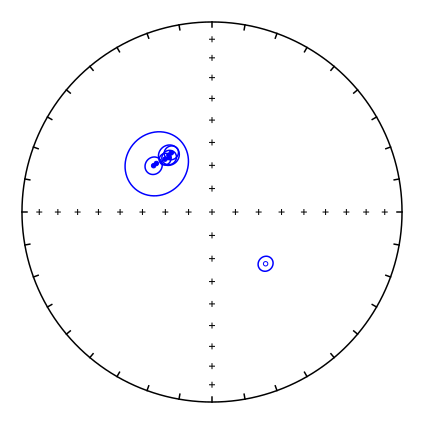

In [122]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(VanFossen1993a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(VanFossen1993a_sites['dir_dec'][i], VanFossen1993a_sites['dir_inc'][i], VanFossen1993a_sites['dir_alpha95'][i], color = 'blue')

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

# plt.legend(loc = 8)
plt.show()

In [123]:
Kent2015_tripleB_VGP_mean = ipmag.fisher_mean(Kent2015_tripleB_samples['vgp_lon_rev'].tolist(), Kent2015_tripleB_samples['vgp_lat_rev'].tolist())
Kent2015_Peddie_VGP_mean = ipmag.fisher_mean(Kent2015_Peddie_samples['vgp_lon'].tolist(), Kent2015_Peddie_samples['vgp_lat'].tolist())

In [124]:
VanFossen1993_vgp_lon = list()
VanFossen1993_vgp_lat = list()

VanFossen1993_vgp_lon.extend(VanFossen1993a_sites['vgp_lon_rev'].tolist()[:1])
VanFossen1993_vgp_lon.extend(VanFossen1993a_sites['vgp_lon'].tolist()[1:])
VanFossen1993_vgp_lat.extend(VanFossen1993a_sites['vgp_lat_rev'].tolist()[:1])
VanFossen1993_vgp_lat.extend(VanFossen1993a_sites['vgp_lat'].tolist()[1:])

VanFossen1993_vgp_mean = ipmag.fisher_mean(VanFossen1993_vgp_lon, VanFossen1993_vgp_lat)
VanFossen1993_vgp_mean

{'dec': 203.12175123870134,
 'inc': 58.08840826766953,
 'n': 7,
 'r': 6.976641639192904,
 'k': 256.8673396883749,
 'alpha95': 3.7735526027448736,
 'csd': 5.053945739969878}

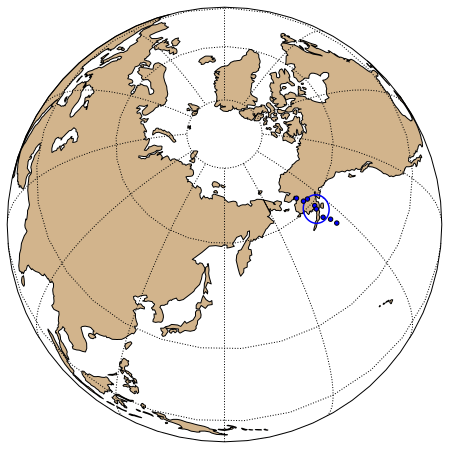

In [125]:
map_axis = ipmag.make_orthographic_map(150, 65)
ipmag.plot_vgp(map_axis, VanFossen1993_vgp_lon, VanFossen1993_vgp_lat, 
               color = 'blue', label = 'Ithaca kimberlite')
ipmag.plot_pole(map_axis, VanFossen1993_vgp_mean['dec'], VanFossen1993_vgp_mean['inc'], VanFossen1993_vgp_mean['alpha95'], color = 'blue')
# ipmag.plot_pole(map_axis, Kent2015_tripleB_VGP_mean['dec'], Kent2015_tripleB_VGP_mean['inc'], Kent2015_tripleB_VGP_mean['alpha95'], color = 'blue')
# ipmag.plot_pole(map_axis, Kent2015_Peddie_VGP_mean['dec'], Kent2015_Peddie_VGP_mean['inc'], Kent2015_Peddie_VGP_mean['alpha95'], color = 'red')

plt.show()

In [126]:
pole_means.loc['Ithaca kimberlites'] = pd.Series({'PoleName' : 'Ithaca kimberlites',
                                        'SLat' : 42.5,
                                        'SLon' : 283.5,
                                        'PLat' : round(VanFossen1993_vgp_mean['inc'],1),
                                        'PLon' : round(VanFossen1993_vgp_mean['dec'],1),
                                        'A95' : round(VanFossen1993_vgp_mean['alpha95'],1),
                                        'K' : round(VanFossen1993_vgp_mean['k'],1),
                                        'N' : int(VanFossen1993_vgp_mean['n']),
                                        'PolarityZone' : 'Ithaca normal and reversed',
                                        'PmagRef' : 'VanFossen & Kent, 1993',
                                        'AgeNominal' : 142,
                                        'AgeLower' : 142-4,
                                        'AgeUpper' : 142+4,
                                        'AgeInfo' : 'K-Ar date on kimberlite dikes yielding 142 $\pm$ 4 Ma)',
                                        'AgeRef' : 'Basu et al., 1984',
                                        'Gaussian_2sigma': 4, 
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C3'})

## Geochronological constraints

- Blakeburn (2013) This study is so far the most recent and precise high-precision CA-ID-TIMS study on CAMP volcanics. The location of study includes: Deep River, North Carolina; Culpeper, Virginia; Gettysburg, Pennsylvania; Newark, New Jersey; Fundy, Nova Scotia. 

    - The results can be interpreted to be suitable for the following units (mean $\pm$ 2$\sigma$):
        - Orange Mountain = Palisade sill = 201.520 $\pm$ 0.034 Ma
        - Preakness basalt = 201.274 $\pm$ 0.032 Ma
        - Hook Mountain Basalt = Deep River Basin = Butner diabase = 200.916 $\pm$ 0.064 Ma
        - North Mountain Basalt = 201.566 $\pm$ 0.031 Ma
        - Amelal sill = 201.564 $\pm$ 0.054 Ma
        - York Haven intrusions = 201.509 $\pm$ 0.035 Ma
        - Rapidan intrusive = 201.498 $\pm$ 0.033 Ma
        - Rossville intrusive = 201.305 $\pm$ 0.034 Ma
        - Butner intrusive = 200.916 $\pm$  0.064 Ma
        
        
- Jourdan (2009) This study uses high precision Ar-Ar dating for CAMP mineral separates. Different from Blackburn (2013) which used U-Pb on zircon crystals, they used sericite and plagioclase. 

    - Plateau ages for more basins in NA are availble in this study (mean $\pm$ 2$\sigma$):
        - Deerfield basin = Holyoke basalt = 199.3 $\pm$ 1.2 Ma
        - Hartford basin = 198.6 $\pm$ 2.0 Ma and 199.8 $\pm$ 1.1 Ma for two upper units. 
        - Fundy basin of North Mountain area have a few ages that agree with above. Howver, since tehre are 10 samples acquired and dated for this basin, and the age varies with locations, (specifically, there is one esceptionally young age at around 190 Ma which also has a good uncertainty rage). Are the data from above zircon may be considered to be more suitable for matching with the paleomagnetic data? It is nice that there are precise location provided in the data table, and we might even be able to match the geochron sample locations with paleomagnetic data locations and assigned individual units with age. 
        
        - The sericite ages from Deerfield and Hartford basins were interpreted as syn-emplacement hydrothermal activity within the basalt units. Can they be asociated with the so-called 175 Ma remagnetization event which should actually be dated to be much older? 
        

- Sutter (1979) did K-Ar and Ar-Ar dating on the Mt Carmel sill, Buttress dike, Fairhaven dikes, Cross Rock dike, Barndoor dike, and intrusions in Gettysburg area. The data is rough, but there are in general two populations of ages --- one similar to the Gettysburg_Newark_York_Haven basin age around 200 Ma, the other group with a much younger age around 170 Ma. 
    - we might consider to give the dikes in deBoer (1967) a different age with large uncertainty envelope, say 180 $\pm$ 10 Ma, to distinguish it from the Piedmont dikes sampled by Dooley and Smith in N and S Carolina. 
    - However, Jourdan (2009) summarized that the Higganum–Holden–Fairhaven dyke (feeder of the Talcott basalts), the Buttress–Ware dyke (feeder of Holyoke basalts) and the Bridgeport–Pelham dyke (feeder of Hampden basalts) are all part of Hartford basin intrusions. Relatively thick sills, e.g. the West Rock sill, can be geochemically correlated to the Talcott lava flows.

- Sutter (1985) This study conducted Ar-Ar dating on the NW and S-N trending diabase dikes and sills in Piedmont area (from Georgia to N Carolina). Although there are NW trending and S-N trending dikes in the region, and pmag and crosscutting relationships show that the N-S dikes are younger tha the NW dikes, the age difference between them are likely small, and probably within the uncertainty of the Ar dating method. 

    - The range is from 193 to 201 Ma and the mean of plateau age is 198.4 $\pm$ 2.1 Ma. 
    
    
- Conway granite and Moat Volcanics: new U-Pb age should be about 180 Ma, here we will put it as 180 $\pm$ 1 Ma.

## Geologic sections

- Fundy basin-North Mountain area:

    - This basin is the northernmost of the well-exposed Mesozoic rift basins of easter North America
    - The volcanics outcrop on the shores of bay in western Nova Scotia.
    - The North Mountain basalt is the part of CAMP here, They outcrop both on the north shore of Minas Basin, where it is frequently tectonized, and on the south side of the basin, and western coast of Noav Scotia where it is only slightly tilted and undisturbed. It also coveres the Grand Manan Island in the southern Bay of Fundy. 
    - The 400 m-thick basalt flow can be divided into three sections which can be matched with descriptions from Carmichael (1968) and Hodych (1980). 


- Hartford basin and Deerfield basin:

    - They are the northernmost on shore Mesozoic rift basins in eastern US. They are both half-grabens with major border fault on eastern margins. They generally dip up to 30 degrees to east. 
    - Hartford basin has three lava formations: Talcott basalt (one-four lava flows, 65-215 m, the Holyoke basalt (100m, 2 major flows with local segregation sheets), the Hampden baslt (60 m, 1 or 2 altered lava flows)
    - Feeder dolerite dikes crosscut the Hartford basin. Specifically, the Higgnam-Holden-Fairhaven dikes are considered to have fed Talcott basalts; Butress_Ware dikes fee Holyoke basalts; Bridgeport-Pelham dikes fed the Hampden lavas. The West rock sill can be geochemically correlated to the Talcott lava flows but the dikes and sills mentioned here failed to yield Ar-Ar age, acocording to Jourdan (2009). 
    - The Deerfield basin is much thinner and smaller than the Hartford basin. It includes only one lava flow. The base is a ~2000 m thick Arkose, and the uppermost portion is a lacustrine Fall River beds, the only basaltic flow is the Deerfield basalt taht is ~80 m thick whose chemical signature correlates to the Holyoke basalt of the Hartford basin. 

## Group paleomagnetic sites and pair with geochronologic constraints

**The grouping marks used here will be the "group" columns in the compilation data files**

Since the idea of Bayesian inversion analyses is that uncertainties of paleomagnetic data and geochronology of individual paleomagnetic poles can be accounted for, this method can eliminate the issue of smoothing pole progression paths of moving window average method. Therefore, one of the ways we can combine/group paleomagnetic data and pair them with geochronology data is to prioritize sites/units that we have precise geochronology data for, and group paleomagnetic data accordingly.

**Deerfield basin basalt and Holyoke lava flows (group name: Deerfield_Holyoke; age: 199.3 $\pm$ 1.2 Ma)**

- DuBois (1957) has 8 samples from 3 flows of Holyoke (here considered to have 3 flows, although in Jourdan (2009) which cited Philpotts (1996) that there are two major flows. However, they grouped all sites from the flows), Massachusetts, and 12 similar lava and sediments in Connecticut. Jourdan also cited McHone (1996) and reference therein that the Holyoke Basalt of the Hartford basin and Deerfield basalt are correlated. Since the location (although rough) and resultant paleomagnetic directional data from these two locations are very similar, we consider grouping these two sites in the *Deerfield_Holyoke_sites*

- Bowker (1960) PhD thesis on basalt in Hartford, Deerfield basins and North Mountain in Canada has 2 sites from Deerfield, and 1 site from Holyoke. 

- deBoer (1968) collected lava flows from Holyoke, Hampden lavas.

**Hartford basin basalt lava flows: Talcott, Hampden lavas (group name: Hartford; age: 198.6 $\pm$ 2.0 Ma)**

- Jourdan (2009) had two ages on sericite of plagioclase from Hampden upper unit lava flow. The age is very close to basalt lava flow age in Deerfield and associated Holyoke lava flow in the Hartford basin. However, the sericite formation is interpreted to be syn-emplacement with the basalt lava flows. Here the age chose is a slightly younger one with a relatively large uncertainty but statistically indistinguishable with the other date as well as the one from Deerfield basin. 

- Bowker (1960) PhD thesis on basalt in Hartford, Deerfield basins and North Mountain in Canada has 2 sites from Talcott, and 1 site from Hampden.

- deBoer (1968) collected intrusives from Hartford basin. 

- Smith (1976) collected intrusive dikes and sills from Culpeper basin, along Frederick dikes, Getysburg basin, and Hartford basin. Given the feeder associations summarized by Jourdan (2009), and the similarities between the pole positions, we assign all these intrusions to be Hartford basin age. 

- Smith (1979) reported more intrusives paleomagnetic data from Barndoor, West rock, East rock, Carmel. The tilt corrected pole positions are very similar to other Hartford basin poles. 

- McEnroe collected in Massachusetts diabase dikes and sills in NW corner of Hartford basin. The pole positions are similar to other Hartford basin poles. 

- Hozik (1992) collected diabase sills and dikes and basalt lavas from Culpeper basin south to Hartford but the pole positions are similar. 

**Orange Mountain (Watchung) lavas and Palisade sills (group name: Orange_Mountain_Palisade_sites, age: 201.520 $\pm$ 0.034 Ma)**

- Blackburn (2013) acquired U-Pb dates from zircons in the Palisade sill which is chemically indistinguishable with the lava flow in Orange Mountain 

- Opdyke (1961) have basalt paleomagnetic directions from lava flows in the area and applied tilt corrections on the directions. 

- McIntosh (1985) collected basalt flows from Orange Mountain 

- Witte (1990) Orange Mountain basalt
 
**Gettysburg, York Haven, Newark, Birdsboro diabase intrusions (group name: Gettysburg_Newark_York_Haven, age: 201.509 $\pm$ 0.035 Ma)

- Blackburn (2013) dated a sill from York Haven diabase intrusion to be 201.509 $\pm$ 0.035 Ma. 

- Beck (1965, 1972) extensively sampled diabase intrusions in Pennsylvania Gettysburg-Newark basins. The locations include Gettysburg, Newark, orkhaven, and Quakerton. Given the similartities in the resulted pole positions, we can assign the age of the thise poles to be the same. (See section 2.7)

- deBoer (1967) have data from Gettysburg basin and Newark basin 

- deBoer (1968) collected intrusives from Newark basin. 

- Smith (1976) collected intrusives in the Gettysburg rregion.

- Kodama (1994) collected diabase intrusions in Newark basin --- directions are weird

**Preakness basalt (group name: Preakness, age: (201.274 $\pm$ 0.032 Ma)**

- McIntosh (1985) collected basalt flows from Preakness basalt

- Witte (1990) Preakness basalt

**Hook Mountain, Deep River basin, Butner intrusion (group name: Hook_Deep_River_Butner, age: 200.916 $\pm$ 0.064 Ma)**

- Blackburn (2013) dated the Butner intrusion in Deep River basin to be 200.916 $\pm$ 0.064 Ma. It is geochemically similar to the Hook Mountain basalt. 

- deBoer (1967) have one site from Deep River basin. 

- McIntosh (1985) collected basalt flows from Hook Mountain

**Piedmont dikes (NW) throughout southern Appalachian from Goergia to S and N Carolina (group name: Piedmont_NW, age: 198.4 $\pm$ 2.1 Ma)**

- Dooley (1982) has diabase sites from Piedmont in South Carolina. tilting can be complicated in this case. 

- Smith (1987) collected diabase dikes in Piedmont North Carolina. The study claim that there is no evidence for measurable tilting in this area. 

**Piedmont dikes (NS) throughout southern Appalachian from Goergia to S and N Carolina (group name: Piedmont_NS, age: 198.4 $\pm$ 2.1 Ma)**

- Beacase the pole of combined NW dikes and NS dikes do no share a common mean and indeed the NS pole is younger, we will separate them out but assign the same age. 

**Piedmont dikes (Y) a younger episode of intrusion in the Appalachian area (group name: Piedmont_Y, age: 180 $\pm$ 10 Ma)**

- deBoer (1967) has dikes throughout southern Appalachian area. However, the issue is that the pole position from this study is so different from the Dooley 91982) and Smith (1987) poles which agree. They propose that there were at least three episodes of intrusive events in the region and what they sampled was of Jurassic in age instead of late Triassic-early Jurassic. A discussion is in section 2.8. We assign a broad age constraint on these dikes but with a mean younger than thoses provided for the dikes sampled by Dooley and Smith which are apparently closer to a 200 Ma age. 

**White Mountain granite snad Moat Volcanics (group name: White_Moat, age: 182.3 $\pm$ 1 Ma**

- Opdyke (1966) acquired pole positions from the White Mountain gabbros, monzonites, diorites, related to the Conway granite. Both normal and reversed polarites were found and they pass a reversal test. The pole positions are very close. the Moat volcancis mean pole looks even older than the White Mountain mean pole. 

- We use the average C component from VanFosen (1990) for Moat volcanics mean pole and use Opdyke mean pole (both normal and reversed) for White Mountain Mean pole. 

**Tripple B and Peddie kimberlites as is in Kent (2015)**

- They can be treated as VGPs with their own ages. 

**Ithaca kimberlite as is in VanFossen (1993)**

- They can be treated as VGPs with their own ages. 

**group name: North_Mountain** 

In [153]:
# combine all sites from Deerfield basin and Holyoke basalt and assign age of 199.3 pm 1.2 Ma
Deerfield_Holyoke_sites = pd.concat([DuBois1957a_sites, Bowker1960a_sites, Irving1961a_sites, deBoer1968a_sites, 
                                     Prevot1989a_sites])
Deerfield_Holyoke_sites = Deerfield_Holyoke_sites[Deerfield_Holyoke_sites['group'] == 'Deerfield_Holyoke']

Hartford_sites = pd.concat([Bowker1960a_sites, Irving1961a_sites, deBoer1968a_sites, Smith1976a_sites, 
                            Smith1979a_sites_tilt_corrected, McEnroe2000a_sites, Prevot1989a_sites, Hozik1992a_sites])
Hartford_sites = Hartford_sites[Hartford_sites['group'] == 'Hartford']

Orange_Mountain_Palisade_sites = pd.concat([Opdyke1961a_sites, McIntosh1985a_sites, Witte1990a_sites, ])
Orange_Mountain_Palisade_sites = Orange_Mountain_Palisade_sites[Orange_Mountain_Palisade_sites['group'] == 'Orange_Mountain_Palisade']

Gettysburg_Newark_York_Haven_sites = pd.concat([Beck1965a_sites, Beck1972a_sites, deBoer1967a_sites, deBoer1968a_sites, 
                                                Smith1976a_sites, Prevot1989a_sites])
Gettysburg_Newark_York_Haven_sites = Gettysburg_Newark_York_Haven_sites[Gettysburg_Newark_York_Haven_sites['group'] == 'Gettysburg_Newark_York_Haven']

Preakness_sites = pd.concat([McIntosh1985a_sites, Witte1990a_sites])
Preakness_sites = Preakness_sites[Preakness_sites['group'] == 'Preakness']

Hook_Deep_River_Butner_sites = pd.concat([deBoer1967a_sites, McIntosh1985a_sites])
Hook_Deep_River_Butner_sites = Hook_Deep_River_Butner_sites[Hook_Deep_River_Butner_sites['group'] == 'Hook_Deep_River_Butner']

Piedmont_NW_sites = pd.concat([Dooley1982a_sites, Smith1987a_sites_NW])
Piedmont_NW_sites = Piedmont_NW_sites[Piedmont_NW_sites['group'] == 'Piedmont_NW']

Piedmont_NS_sites = pd.concat([Dooley1982a_sites, Smith1987a_sites_NS])
Piedmont_NS_sites = Piedmont_NS_sites[Piedmont_NS_sites['group'] == 'Piedmont_NS']

Piedmont_Y_sites = deBoer1967a_sites
Piedmont_Y_sites = Piedmont_Y_sites[Piedmont_Y_sites['group'] == 'Piedmont_Y']

White_Moat_sites = pd.concat([Opdyke1966a_sites, VanFossen1990a_sites])
White_Moat_sites = White_Moat_sites[White_Moat_sites['group'] == 'White_Moat']

TripleB_sites = Kent2015_tripleB_samples
Peddie_sites = Kent2015_Peddie_samples

Ithaca_sites = VanFossen1993a_sites
Ithaca_sites = Ithaca_sites[Ithaca_sites['group'] == 'Ithaca']

In [154]:
Deerfield_Holyoke_vgp_mean = ipmag.fisher_mean(Deerfield_Holyoke_sites.vgp_lon.tolist(), Deerfield_Holyoke_sites.vgp_lat.tolist())

Hartford_vgp_mean = ipmag.fisher_mean(Hartford_sites.vgp_lon.tolist(), Hartford_sites.vgp_lat.tolist())

Orange_Mountain_Palisade_vgp_mean = ipmag.fisher_mean(Orange_Mountain_Palisade_sites.vgp_lon.tolist(), Orange_Mountain_Palisade_sites.vgp_lat.tolist())

Gettysburg_Newark_York_Haven_vgp_mean = ipmag.fisher_mean(Gettysburg_Newark_York_Haven_sites.vgp_lon.tolist(), Gettysburg_Newark_York_Haven_sites.vgp_lat.tolist())

Preakness_vgp_mean = ipmag.fisher_mean(Preakness_sites.vgp_lon.tolist(), Preakness_sites.vgp_lat.tolist())

Hook_Deep_River_Butner_vgp_mean = ipmag.fisher_mean(Hook_Deep_River_Butner_sites.vgp_lon.tolist(), Hook_Deep_River_Butner_sites.vgp_lat.tolist())

Piedmont_NW_vgp_mean = ipmag.fisher_mean(Piedmont_NW_sites.vgp_lon.tolist(), Piedmont_NW_sites.vgp_lat.tolist())

Piedmont_NS_vgp_mean = ipmag.fisher_mean(Piedmont_NS_sites.vgp_lon.tolist(), Piedmont_NS_sites.vgp_lat.tolist())

Piedmont_Y_vgp_mean = ipmag.fisher_mean(Piedmont_Y_sites.vgp_lon.tolist(), Piedmont_Y_sites.vgp_lat.tolist())

White_Moat_vgp_mean = ipmag.fisher_mean(White_Moat_sites.vgp_lon.tolist(), White_Moat_sites.vgp_lat.tolist())

TripleB_VGP_mean = Kent2015_tripleB_VGP_mean 

Peddie_VGP_mean = Kent2015_Peddie_VGP_mean

Ithaca_vgp_mean = VanFossen1993_vgp_mean

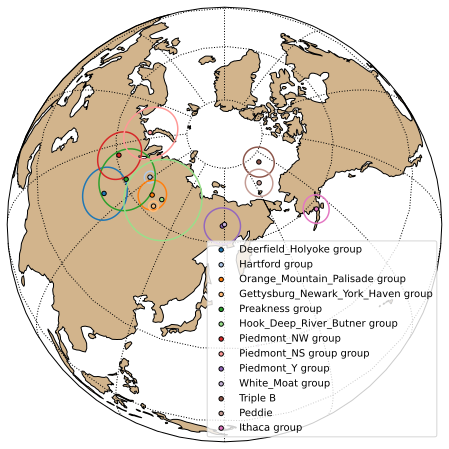

In [159]:
map_axis = ipmag.make_orthographic_map(150, 65)
# ipmag.plot_vgp(map_axis, Deerfield_Holyoke_sites.vgp_lon.tolist(), Deerfield_Holyoke_sites.vgp_lat.tolist(), 
#                color = '#1F77B4', label = 'Deerfield_Holyoke group')
# ipmag.plot_vgp(map_axis, Hartford_sites.vgp_lon.tolist(), Hartford_sites.vgp_lat.tolist(), 
#                color = '#AEC7E8', label = 'Hartford group')
# ipmag.plot_vgp(map_axis, Orange_Mountain_Palisade_sites.vgp_lon.tolist(), Orange_Mountain_Palisade_sites.vgp_lat.tolist(), 
#                color = '#FF7F0E', label = 'Orange_Mountain_Palisade group')
# ipmag.plot_vgp(map_axis, Gettysburg_Newark_York_Haven_sites.vgp_lon.tolist(), Gettysburg_Newark_York_Haven_sites.vgp_lat.tolist(), 
#                color = '#FFBB78', label = 'Gettysburg_Newark_York_Haven group')
# ipmag.plot_vgp(map_axis, Preakness_sites.vgp_lon.tolist(), Preakness_sites.vgp_lat.tolist(), 
#                color = '#2CA02C', label = 'Preakness group')
# ipmag.plot_vgp(map_axis, Hook_Deep_River_Butner_sites.vgp_lon.tolist(), Hook_Deep_River_Butner_sites.vgp_lat.tolist(), 
#                color = '#98DF8A', label = 'Hook_Deep_River_Butner group')
# ipmag.plot_vgp(map_axis, Piedmont_NW_sites.vgp_lon.tolist(), Piedmont_NW_sites.vgp_lat.tolist(), 
#                color = '#D62728', label = 'Piedmont_NW group')
# ipmag.plot_vgp(map_axis, Piedmont_NS_sites.vgp_lon.tolist(), Piedmont_NS_sites.vgp_lat.tolist(), 
#                color = '#FF9896', label = 'Piedmont_NS group group')
# ipmag.plot_vgp(map_axis, Piedmont_Y_sites.vgp_lon.tolist(), Piedmont_Y_sites.vgp_lat.tolist(), 
#                color = '#9467BD', label = 'Piedmont_Y group')
# ipmag.plot_vgp(map_axis, White_Moat_sites.vgp_lon.tolist(), White_Moat_sites.vgp_lat.tolist(), 
#                color = '#C5B0D5', label = 'White_Moa groupt')
# ipmag.plot_vgp(map_axis, TripleB_sites['vgp_lon_rev'].tolist(), TripleB_sites['vgp_lat_rev'].tolist(), 
#                color = '#8C564B', label = 'Triple B')
# ipmag.plot_vgp(map_axis, Peddie_sites['vgp_lon'].tolist(), Peddie_sites['vgp_lat'].tolist(), 
#                color = '#C49C94', label = 'Peddie')
# ipmag.plot_vgp(map_axis, Ithaca_sites.vgp_lon.tolist(), Ithaca_sites.vgp_lat.tolist(), 
#                color = '#E377C2', label = 'Ithaca group')


ipmag.plot_pole(map_axis, Deerfield_Holyoke_vgp_mean['dec'], Deerfield_Holyoke_vgp_mean['inc'], Deerfield_Holyoke_vgp_mean['alpha95'], 
                color = '#1F77B4', label = 'Deerfield_Holyoke group')

ipmag.plot_pole(map_axis, Hartford_vgp_mean['dec'], Hartford_vgp_mean['inc'], Hartford_vgp_mean['alpha95'], 
                color = '#AEC7E8', label = 'Hartford group')

ipmag.plot_pole(map_axis, Orange_Mountain_Palisade_vgp_mean['dec'], Orange_Mountain_Palisade_vgp_mean['inc'], Orange_Mountain_Palisade_vgp_mean['alpha95'], 
                color = '#FF7F0E', label = 'Orange_Mountain_Palisade group')

ipmag.plot_pole(map_axis, Gettysburg_Newark_York_Haven_vgp_mean['dec'], Gettysburg_Newark_York_Haven_vgp_mean['inc'], Gettysburg_Newark_York_Haven_vgp_mean['alpha95'], 
                color = '#FFBB78', label = 'Gettysburg_Newark_York_Haven group')

ipmag.plot_pole(map_axis, Preakness_vgp_mean['dec'], Preakness_vgp_mean['inc'], Preakness_vgp_mean['alpha95'], 
                color = '#2CA02C', label = 'Preakness group')

ipmag.plot_pole(map_axis, Hook_Deep_River_Butner_vgp_mean['dec'], Hook_Deep_River_Butner_vgp_mean['inc'], Hook_Deep_River_Butner_vgp_mean['alpha95'], 
                color = '#98DF8A', label = 'Hook_Deep_River_Butner group')

ipmag.plot_pole(map_axis, Piedmont_NW_vgp_mean['dec'], Piedmont_NW_vgp_mean['inc'], Piedmont_NW_vgp_mean['alpha95'], 
                color = '#D62728', label = 'Piedmont_NW group')

ipmag.plot_pole(map_axis, Piedmont_NS_vgp_mean['dec'], Piedmont_NS_vgp_mean['inc'], Piedmont_NS_vgp_mean['alpha95'], 
                color = '#FF9896', label = 'Piedmont_NS group group')

ipmag.plot_pole(map_axis, Piedmont_Y_vgp_mean['dec'], Piedmont_Y_vgp_mean['inc'], Piedmont_Y_vgp_mean['alpha95'], 
                color = '#9467BD', label = 'Piedmont_Y group')

ipmag.plot_pole(map_axis, White_Moat_vgp_mean['dec'], White_Moat_vgp_mean['inc'], White_Moat_vgp_mean['alpha95'], 
                color = '#C5B0D5', label = 'White_Moat group')

ipmag.plot_pole(map_axis, TripleB_VGP_mean['dec'], TripleB_VGP_mean['inc'], TripleB_VGP_mean['alpha95'], 
                color = '#8C564B', label = 'Triple B')

ipmag.plot_pole(map_axis, Peddie_VGP_mean['dec'], Peddie_VGP_mean['inc'], Peddie_VGP_mean['alpha95'], 
                color = '#C49C94', label = 'Peddie')

ipmag.plot_pole(map_axis, Ithaca_vgp_mean['dec'], Ithaca_vgp_mean['inc'], Ithaca_vgp_mean['alpha95'], 
                color = '#E377C2', label = 'Ithaca group')

plt.legend(loc = 4)
plt.show()

In [161]:
White_Moat_sites

site        location                               note  dir_dec  dir_inc  \
0     7  White Mountain                                NaN    161.0    -59.0   
1    11  White Mountain  Essexite is nepheline monzogabbro      1.0     65.5   
2     1  White Mountain                                NaN    200.0    -52.5   
3     2  White Mountain                                NaN    184.0    -55.0   
4     3  White Mountain                                NaN    191.0    -57.0   
5     6  White Mountain                                NaN    168.0    -57.5   
6     8  White Mountain                                NaN    165.5    -49.5   
7     A  White Mountain                                NaN    153.0    -52.0   
8     B  White Mountain                                NaN    146.0    -55.0   
9    12  White Mountain                                NaN      5.0     63.0   
10    4  White Mountain                                NaN      0.0     65.0   
11    5  White Mountain                                NaN      2.0     59.0   
12    9  White Mountain                                NaN    352.0     58.5   
13   10  White Mountain                                NaN    351.0     58.0   
0   NaN  Moat Volcanics                                NaN    183.4    -55.5   

    dir_k  dir_n_samples  dir_n_specimens  dir_n_total_specimens  \
0   162.0           12.0             12.0                   12.0   
1   135.0            8.0              8.0                    8.0   
2    93.0           12.0             12.0                   12.0   
3    47.0           12.0             12.0                   12.0   
4    26.0           11.0             11.0                   11.0   
5    34.0           12.0             12.0                   12.0   
6    52.0           12.0             12.0                   12.0   
7   384.0           12.0             12.0                   12.0   
8   308.0           12.0             12.0                   12.0   
9   581.0           10.0             10.0                   10.0   
10   54.0            6.0              6.0                    6.0   
11   65.0           11.0             11.0                   11.0   
12   62.0           12.0             12.0                   12.0   
13  150.0           12.0             12.0                   12.0   
0    56.0           60.0              NaN                    NaN   

    dir_tilt_correction  ...  contact_test  country  \
0                     0  ...           NaN      NaN   
1                     0  ...           NaN      NaN   
2                     0  ...           NaN      NaN   
3                     0  ...           NaN      NaN   
4                     0  ...           NaN      NaN   
5                     0  ...           NaN      NaN   
6                     0  ...           NaN      NaN   
7                     0  ...           NaN      NaN   
8                     0  ...           NaN      NaN   
9                     0  ...           NaN      NaN   
10                    0  ...           NaN      NaN   
11                    0  ...           NaN      NaN   
12                    0  ...           NaN      NaN   
13                    0  ...           NaN      NaN   
0                   100  ...            ND   U.S.A.   

                                          description dir_k_ratio dir_n_sites  \
0                                                 NaN         NaN         NaN   
1                                                 NaN         NaN         NaN   
2                                                 NaN         NaN         NaN   
3                                                 NaN         NaN         NaN   
4                                                 NaN         NaN         NaN   
5                                                 NaN         NaN         NaN   
6                                                 NaN         NaN         NaN   
7                                                 NaN         NaN         NaN   
8                      

# North American Monster Shift records (Canada)

## Bowker in Cox and Doell (1960) lava flows from Nova Scotia (Canada)

In similar area Bowker studied lava flows from Nova Scotia and through a letter to Doell reported a mean pole position from the lava flows (PLon = 75.5, PLat = 77, N = 12, k = 14, a95 = 11.5 ). 

While this can be an addition to what we have from Carmichael, it is worth mentioning that in text of Carmichael (1968) this pole was investigated and was interpreted to be from samples collected from the lower section of the lava flows, based on the longitude of the pole. 

Cox, A., & Doell, R. R. (1960). Review of paleomagnetism. Geological Society of America Bulletin, 71(6), 645-768. doi: http://dx.doi.org/10.1130/0016-7606(1960)71[645:ROP]2.0.CO;2. 

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_pole(map_axis,104 , 73, 5, color = 'blue', markersize = 50, label = 'Carmichael (1968) basalt flows')
ipmag.plot_pole(map_axis, 75.7 ,77, 11.5, color = 'red', markersize = 50, label = 'Bowker (1960) basalt flows')

plt.legend(loc = 8)
plt.show()

## Larochelle (1963) diabase dikes and sills from Ellef Ringnes Island (Canada)

This early publication in Nature in 1963 proposes using paleomagnetic information to date rocks. 10 sites from the Ellef Ringnes Island in Canada were AF cleaned up to 30 mT. The precise locations of the sites can be better constrained if map georeferenced.

The age of the unit can be constrained stratigraphically in that they intrude the Deer Bay Formation (Lowermost Cretaceous) (considered then). Their upper age is constrained by the fact that they do no intrude any Tertiary sediments. 

It is interesting that the directions after AF demagnetizations are more scattered than before. However, given that the NRMs are already very closely clustered, the peak AF field was only 30 mT, and that the field direction is very much like a present day field, caution on further examination of the data. This is often the issue with NA Triassic-Cretaceous-ish age rocks in that distinguishing a direction from the present day field is challenging.

It is also worth mentioning that technically there are only 2 samples for each site. And the VGPs are actually very scattered. Evenchick (2015) has some geochronology data for this island but if there are no more avilable paleomagnetic poles on the similar units this pole might not be a priority that we want to use. 

Larochelle, A., & Black, R. F. (1963). An application of palaeomagnetism in estimating the age of rocks. Nature, 198(4887), 1260-1262. doi: http://dx.doi.org/10.1038/1981260a0. 

In [ ]:
Larochelle1963a_sites = pd.read_csv('pmag_compiled/Larochelle1963a/Larochelle1963a_sites.txt', sep = '\t', header = 1)
Larochelle1963a_sites = Larochelle1963a_sites[Larochelle1963a_sites['dir_alpha95'] < 15]
Larochelle1963a_sites = ipmag.vgp_calc(Larochelle1963a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Larochelle1963a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Larochelle1963a_sites['dir_dec'].tolist(), Larochelle1963a_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
Larochelle1963a_sites_mean = ipmag.fisher_mean(Larochelle1963a_sites['vgp_lon'].tolist(), Larochelle1963a_sites['vgp_lat'].tolist())
Larochelle1963a_sites_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Larochelle1963a_sites['vgp_lon'].tolist(), Larochelle1963a_sites['vgp_lat'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_pole(map_axis, Larochelle1963a_sites_mean['dec'], Larochelle1963a_sites_mean['inc'], Larochelle1963a_sites_mean['alpha95'], color = 'blue', markersize = 50)
plt.show()

## Robertson (1967) dacite lava flows in Manicouagan and Mouchalagan lakes area, Quebec, Canada

W.A. Robertson collected dacite material from the twin lakes area in Quebec to investigate their origin and age. The materials form a circular feature, in places more than 700 ft thick, and **almost horizontal** (can be used to argue no structural correction needed). The dacite can be divided into a lower fine-grained, inclusion-rich part, and an upper coarser-grained, less-common-inclusion part. K-Ar age cited in this paper is 225 $\pm$ 30 Ma from fine-grained andesite on west shore of Manicouagan lake. 

Paleomagnetic demagnetization used thermal cleaning, included in the table are NRM, 300 cleaning and 350 cleaning. It is quite common that after 350 step the site mean directions are even better clustered than the 300 step, which made Robertson to pick 350 to calculate the mean directions-pole positions. We will do this here too. Polished thin sections identified only magnetite as the magnetic mineral seen in significant amounts. Magnetite-ilmenite intergrowths also observed. 

**Each site locations can be refined by georeferencing the map**

Robertson, W. A. (1967). Manicouagan, Quebec, paleomagnetic results. Canadian Journal of Earth Sciences, 4(4), 641-649. doi: http://dx.doi.org/10.1139/e67-041. 

In [ ]:
Robertson1967a_sites = pd.read_csv('pmag_compiled/Robertson1967a/Robertson1967a_sites.txt', sep = '\t', header = 1)
Robertson1967a_sites = Robertson1967a_sites[Robertson1967a_sites['dir_alpha95'] < 15]
Robertson1967a_sites = ipmag.vgp_calc(Robertson1967a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Robertson1967a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Robertson1967a_sites['dir_dec'].tolist(), Robertson1967a_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
Robertson1967a_sites_vgp_mean = ipmag.fisher_mean(Robertson1967a_sites['vgp_lon'].tolist(), Robertson1967a_sites['vgp_lat'].tolist())
Robertson1967a_sites_vgp_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Robertson1967a_sites['vgp_lon'].tolist(), Robertson1967a_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)
ipmag.plot_pole(map_axis,Robertson1967a_sites_vgp_mean['dec'],Robertson1967a_sites_vgp_mean['inc'], 
                Robertson1967a_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

plt.show()

## Currie (1969) volcanics rocks (ring dike and volcanoclastics) from Mistastin Lake, Labrador, Canada

This is another location where volcanic rocks have been identified to be ~200 Myr old and of paleomagnetic interest for pole position. The volcanic rocks were never clearly categorized in the text as to whether they are extrusive or intrusive. But based on the description, they may be extrusive lava flows, andesite in cpomposition. 

In the arcuate belt of narrow volcanic rock outcrop around the northern, western and southern sides of the lake are ring dikes about 30 m wide, believed to follow a ring fault in Precambrian rocks. **In the margin are vesicular volcanic breccia, grading abruptly inward to dense, black, aphanitic andesite.** There is also a lobate/elliptical area of flat lying volcanic rock up to 800 m diameter that is fed by the composite dike. **Flat-lying feature may be the reason for no structural correction.** basal unit is a sequence of vesicular, brick red, volcanic breccia with aphanitic matrix, sampled as unit 1. Vesicular black andesite overlies the breccia, this is unit 2, and dense black andesite caps almost all unit 1 and 2. **Field observations of crosscutting relationships suggest the volcanics rocks are of simiar age.** The andesite are very fine-grained, with fine-grained magnetite. 

Paleomagnetic protocol is AF cleaning of 25 mT standard peak field for directional analyses. The fact that all sites across this 100 km area have good within site and across site agreement lend support for minimal structural error and high stability of magnetization. The reported directions for site 4, 5, and 7 are "adjusted", since the authors claimed that one sample in each of these sites have oddly steep direction that is away from other samples within site that agree well with each other. We here use the adjusted site level data. 

**It is also very. interesting as the author pointed out that the sites have reversed directions. This is different from all sites from the Nova Scotia region, where rocks all record normal directions. However, note that the rocks in Manicouagan lake area have both polarities.** 


**It is very important to note that the Mistastin Lake has had intensive studies about it being an impact crater structure, which might suggest that Currie (1969) had this misinterpretation of this as ring dike. The impact melt rock has been dated to be much younger than 200 Ma, about 40 Ma. This might indicate this tight and stable remanence in the volcanics here is a much younger field. Indeed, the pole position and tight clustering poles are away from the Manicouagan lake pole. This might be a young overprint pole...**

**The site location uses a general location of the Mistastin Lake, but could be improved by georeferencing map.**

**Herve (2015) with a rock magnetic and paleomagnetic study showed this is an impact melt rock that formed during an impact ~35 Ma, We will therefore not invlude this data into our compilation for Monster Shift.**

Currie, K. L., & Larochelle, A. (1969). A paleomagnetic study of volcanic rocks from Mistastin Lake, Labrador, Canada. Earth and Planetary Science Letters, 6(4), 309-315. doi: http://dx.doi.org/10.1016/0012-821X(69)90173-3. 

In [ ]:
Currie1969a_sites = pd.read_csv('pmag_compiled/Currie1969a/Currie1969a_sites.txt', sep = '\t', header = 1)
Currie1969a_sites = Currie1969a_sites[Currie1969a_sites['dir_alpha95'] < 15]
Currie1969a_sites = ipmag.vgp_calc(Currie1969a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Currie1969a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Currie1969a_sites['dir_dec'].tolist(), Currie1969a_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
Currie1969a_sites_vgp_mean = ipmag.fisher_mean(Currie1969a_sites['vgp_lon_rev'].tolist(), Currie1969a_sites['vgp_lat_rev'].tolist())
Currie1969a_sites_vgp_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Currie1969a_sites['vgp_lon_rev'].tolist(), Currie1969a_sites['vgp_lat_rev'].tolist(), 
               color = 'blue', markersize = 50)
ipmag.plot_pole(map_axis,Currie1969a_sites_vgp_mean['dec'],Currie1969a_sites_vgp_mean['inc'], 
                Currie1969a_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

plt.show()

## Larochelle (1966) diabase dikes in Nova Scotia (Canada)

Larochelle in 1966 sampled two sites from a 110 km long NE-trending diabase dike in Nova Scotia. At the time a K-Ar age was produced on this dike and gave an age of 197 $\pm$ 32 Ma. Precise location needs to be georeferenced from the map in the study. **This is the Shelburn dike, dated to be about 190 Ma.**

An AF cleaning with peak field 35 mT was used on most of the samples and no tilt correction was mentioned in the text. The magnetic stability was supported by the pilot specimens that were demagnetized up to 60 mT. Note that in the data table of this study there are sample mean, site mean, and site-mean all provided. However, there is no reason to calculate and use the a95 of only 2 sites. **We should use the sample level or site level data here.**

Given there are only two sites we might be able to combine the poles with those from other studies based on geochronological constraints.

Larochelle, A., & Wanless, R. K. (1966). The paleomagnetism of a Triassic diabase dike in Nova Scotia. Journal of Geophysical Research, 71(20), 4949-4953. doi: http://dx.doi.org/10.1029/JZ071i020p04949. 

In [ ]:
Larochelle1966a_sites = pd.read_csv('pmag_compiled/Larochelle1966a/Larochelle1966a_sites.txt', sep = '\t', header = 1)
Larochelle1966a_sites = ipmag.vgp_calc(Larochelle1966a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Larochelle1966a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Larochelle1966a_sites['dir_dec'], Larochelle1966a_sites['dir_inc'], color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Larochelle1966a_sites['vgp_lon'],Larochelle1966a_sites['vgp_lat'], color = 'blue', markersize = 50)

plt.show()

## Carmichael (1968) basalt lava flows from North Mountain

This paleomagnetic study is focused on the extrusive basalt lava flows in North Mountain and Grand Manan island near Nova Scotia. It can be a good company with the one above by Larochelle (1966) which studied the diabase dikes in Nova Scotia. Unfortunately there are no site level data here but only a site mean result ater AF cleaning (20 mT). Although the a95 is small for North Mountain lava, in text the aurhtor mentioned that there are two groups of directions, specifically, the lower-stratigraphy flows have a slightly more easterly direction than the upper-stratigraphy flows. And the collected samples may not properly average our secular variation. The Grand Manan lavas have fwer sites (8) and high a95 (16.5) bu the overall pole position is quite similar to that of the North Mountain lavas. 

**The text briefly mentioned that the directions are corrected for dips already.**

Petrographic work see Fe-Ti oxides, K-Ar whole rock age from four samples have a mean of 200 $\pm$ 10 Ma. There is also a positive conglomerate test n NRM. 

Hayatsu (1979) had an age of 191 Ma for North Mountain Basalt. 

Carmichael, C. M., & Palmer, H. C. (1968). Paleomagnetism of the Late Triassic, North Mountain Basalt of Nova Scotia. Journal of Geophysical Research, 73(8), 2811-2822. doi: http://dx.doi.org/10.1029/JB073i008p02811. 

In [ ]:
Carmichael1968a_site_mean = pd.read_csv('pmag_compiled/Carmichael1968a/Carmichael1968a_site_means.txt', sep='\t', header = 1)
Carmichael1968a_site_mean

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
    
ipmag.plot_di_mean(Carmichael1968a_site_mean['dir_dec'][0], Carmichael1968a_site_mean['dir_inc'][0], 
                   Carmichael1968a_site_mean['dir_alpha95'][0], color = 'blue', markersize = 50, label = 'North Mountain')

ipmag.plot_di_mean(Carmichael1968a_site_mean['dir_dec'][1], Carmichael1968a_site_mean['dir_inc'][1], 
                   Carmichael1968a_site_mean['dir_alpha95'][1], color = 'red', markersize = 50, label = 'Grand Manan')

plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)


ipmag.plot_pole(map_axis, Carmichael1968a_site_mean['PLon'][0], Carmichael1968a_site_mean['PLat'][0], 
                   Carmichael1968a_site_mean['dir_alpha95'][0], color = 'blue', markersize = 50, label = 'North Mountain')

ipmag.plot_pole(map_axis, Carmichael1968a_site_mean['PLon'][1], Carmichael1968a_site_mean['PLat'][1], 
                   Carmichael1968a_site_mean['dir_alpha95'][1], color = 'red', markersize = 50, label = 'Grand Manan')

plt.show()

## Seguin (1981) diabase dikes in New Brunswick near Nova Scotia

There are four places in Nova Scotia vicinity that have had paleomagnetic interests: New Brunswick, Prince edward Island, Cape Breton Island, and New Foundland. 

In this study the unit investigated is the northeasterly trending Caraquet dike system. Three widely separated localities in New Brunswick. The dikes can be easily traced in aeromagnetic maps, and have width from 5 to 60 m. The diabase dikes are mostly fine-grained with no evidence of metamorphism. The average strike is NE with **dips vertical to subvertical.** Locally they can be offset and form up to three or more closely spaced dikes (offshoot). Width of dike sampled for paleomagnetic study varied from 5 to 20 m. 

The diabase are ophitic to subophitic. Magnetite and titanomagnetite are probably the most abundant oxides, magnetite in skeletal form. There sizes are big, titanomagnetite reportedly 10-30 $\mu$m. 
Both AF (up to 40 mT) and thermal demagnetization (up tp 550 degree C) were used. No best fit line, just cleaning. 

The authors of this study suggested that the samples from "T" sites might be at least 20 Ma younger than the N and C sites based on the paleomagnetic pole positions. However, note that there are only 2 sites from T. Looking at the site direction figure below, the total of all sites might not even be sufficient to average out PSV.

**The locations can be refined b georeferencing the map**

The study hinted that further study on this area was in progress. There might be potentially more data on this region by similar authors. 

Poole (1968) in Wanless (1972) had three samples from the Caraquet dikes K-Ar age of 167 $\pm$ 28, 180$\pm$ 31, and 180 Ma. 

Hodych (1988) reported Caraquet dike in New Brunswick to be 191 $\pm$ 2 Ma (K-Ar).

WANLESS, R. K., STEVENS, R. D., LACHANCE, G. R., and DELABIO, R. N. 1972. Age determinations and geological studies, K-Ar isotopic ages. Report 10. Geological Survey of Canada Paper 71-2, pp. 72-73.

Seguin, M. K., Rao, K. V., Venugopal, D. V., & Gahe, E. (1981). Paleomagnetism of parts of the Late Triassic diabase dike system associated with the trans-New Brunswick aeromagnetic lineament. Canadian Journal of Earth Sciences, 18(12), 1776-1787. doi: http://dx.doi.org/10.1139/e81-165.

In [ ]:
Seguin1981a_sites = pd.read_csv('pmag_compiled/Seguin1981a/Seguin1981a_sites.txt', sep = '\t', header = 1)
Seguin1981a_sites = Seguin1981a_sites[Seguin1981a_sites['dir_alpha95'] < 15]
Seguin1981a_sites = ipmag.vgp_calc(Seguin1981a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')

Seguin1981a_sites_C = Seguin1981a_sites[Seguin1981a_sites['location'] == 'Caraquet']
Seguin1981a_sites_N = Seguin1981a_sites[Seguin1981a_sites['location'] == 'North Lake']
Seguin1981a_sites_T = Seguin1981a_sites[Seguin1981a_sites['location'] == 'Trans-Canada highway']

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Seguin1981a_sites_C['dir_dec'].tolist(), Seguin1981a_sites_C['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Caraquet')
ipmag.plot_di(Seguin1981a_sites_N['dir_dec'].tolist(), Seguin1981a_sites_N['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'North Lake')
ipmag.plot_di(Seguin1981a_sites_T['dir_dec'].tolist(), Seguin1981a_sites_T['dir_inc'].tolist(), 
              color = 'green', markersize = 50, label = 'Trans-Canada highway')

# plt.legend(loc = 8)
plt.show()

In [ ]:
# use all to calculate VGP mean
Seguin1981a_sites_vgp_mean = ipmag.fisher_mean(Seguin1981a_sites['vgp_lon'].tolist(), Seguin1981a_sites['vgp_lat'].tolist())
Seguin1981a_sites_vgp_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Seguin1981a_sites['vgp_lon'].tolist(),Seguin1981a_sites['vgp_lat'].tolist(), color = 'black', markersize = 50)
ipmag.plot_pole(map_axis, Seguin1981a_sites_vgp_mean['dec'], Seguin1981a_sites_vgp_mean['inc'], 
                Seguin1981a_sites_vgp_mean['alpha95'], marker = 's', markersize = 50)
plt.show()

## Hodych (1988) basalt lava flows from North Mountain and diabase dikes in Caraquet and Avalon

As geochronologic, and paleomagnetic evidence point to temporal correlations between basalt lfows in North Mountain and the intrusions in forms of dike and sills in vicinity, this tudy carries out K-Ar dating as well as paleomagnetic experiments to test hypothesis taht the Shelburn dike was a feeder to the North Mountain Basalt (Aumento 1966), their relations to the Avalon dike, and the Caraquet dike. The main feature that leads to this interest is that they are close and the dikes are parallel. 

**This is study is also important in addressing the question left over by Seguin (1981) that there is a second intrusion likely 20 Ma younger in the Caraquet dike. Hodych (1988) argued this interpretation is likely incorrect, since there is no evidence of heating, reversible thermalmagnetic curves, and paleomagnetic directions from Caraquet in this study agrees with others, and that there are only two sites in Seguin from Caraquett.**

Both stepwise AF (up to 80 mT) and thermal demagnetizations (up to 680 degree C) were performed on sister rock specimens. Although the result mean directions are similar, thermally demagnetized site results are better clustered than AF. But they are still considered as cleaning, which means no least square fit was used. The authors chose to use the thermal demag data only to calculate directions. Vector plots were used for each specimen to help determine its characteristic remanence direction. Magnetic mineralogy analyses show titanomagnetite-ilmenite as dominant oxides. Sizes of magnetite and titanomagnetite are often about or finer than 10 micron. **They briefly mentioned in text an inconclusive fold test from North Mountain flows. But refer to the Carmichael (1968)'s positive conglomerate test for support of primary magnetization. Also single component unblocking between 400 and 580.**

The result paleoamgnetic directions are tilt corrected for the North Mountain flows. We back calculated k from a95 data provided. **It is interesting that this study tilt corrected the directions, which makes the directions more easterly than the directions in Carmichael (1968) and Seguin (1981). Carmichael (1968) briefly mentioned that the directions are tilt-corrected, Seguin (1981) did not talk about tilt correctio, although they agree on a northerly direction.**

K-Ar whole rock dating showed that the Shelburn dike has an K-Ar age of 193.2 $\pm$ 1.6 Ma, in agreement with Larochelle and Wanless (1966) (197 $\pm$ 32 Ma). The Avalon dike has an age of 188.9 $\pm$ 3.0 Ma, the Caraquet dike has an age of 190.6 $\pm$ 2.4 Ma. 

This study also discussed the pole positions from Canadian and American igneous rocks during this similar time period and show that they are within uncertainties indisginguishable. This can be a support for our further combination of directions from multiple studies. This study also suggests that the Shelburne, Avalon, Caraquet dikes and North Mountain flows are probably related and were likely emplaced as Hettangian precursors to Atlantic sea-floor opening/spreading. 

Hodych, J. P., & Hayatsu, A. (1988). Paleomagnetism and K–Ar isochron dates of Early Jurassic basaltic flows and dikes of Atlantic Canada. Canadian Journal of Earth Sciences, 25(12), 1972-1989. doi: http://dx.doi.org/10.1139/e88-185. 

In [ ]:
Hodych1988a_sites = pd.read_csv('pmag_compiled/Hodych1988a/Hodych1988a_sites.txt', sep='\t', header = 1)
Hodych1988a_sites = Hodych1988a_sites[Hodych1988a_sites['dir_alpha95'].notnull()]
Hodych1988a_sites = Hodych1988a_sites[Hodych1988a_sites['dir_alpha95'] < 15 ]
Hodych1988a_sites = ipmag.vgp_calc(Hodych1988a_sites,   tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
                                   
Hodych1988a_sites_North_Mt = Hodych1988a_sites[Hodych1988a_sites['location'] == 'North Mountain']
Hodych1988a_sites_Caraquet = Hodych1988a_sites[Hodych1988a_sites['location'] == 'Caraquet']
Hodych1988a_sites_Avalon = Hodych1988a_sites[Hodych1988a_sites['location'] == 'Avalon']

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
    
ipmag.plot_di(Hodych1988a_sites_North_Mt['dir_dec'].tolist(), Hodych1988a_sites_North_Mt['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'North Mountain basalt flow')
ipmag.plot_di(Hodych1988a_sites_Caraquet['dir_dec'].tolist(), Hodych1988a_sites_Caraquet['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'Caraquet dike')
ipmag.plot_di(Hodych1988a_sites_Avalon['dir_dec'].tolist(), Hodych1988a_sites_Avalon['dir_inc'].tolist(), 
              color = 'green', markersize = 50, label = 'Avalon dike')

plt.legend(loc = 8)
plt.show()

In [ ]:
Hodych1988a_sites_vgp_mean = ipmag.fisher_mean(Hodych1988a_sites['vgp_lon'].tolist(), Hodych1988a_sites['vgp_lat'].tolist())
Hodych1988a_sites_vgp_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)


ipmag.plot_vgp(map_axis, Hodych1988a_sites['vgp_lon'].tolist(), Hodych1988a_sites['vgp_lat'].tolist(), 
               color = 'black', markersize = 50, label = 'North Mountain')

ipmag.plot_pole(map_axis, Hodych1988a_sites_vgp_mean['dec'], Hodych1988a_sites_vgp_mean['inc'], 
                   Hodych1988a_sites_vgp_mean['alpha95'], color = 'black', marker = 's', markersize = 50)

plt.show()

## Hodych (1980) diabase dike and sill in Newfoundland in vicinity of Nova Scotia

As is mentioned in the section above, Newfoundland is another place where outcrops of diabase intrusions are found in the Nova Scotia general region. Hodych in this study sampled three sites of diabase intrusions in Newfoundland peninsula and used two NE trending body for paleomagnetic study and K-Ar dating, and one other boulder for just dating. The results have quite large uncertainty ranges, but in general is around 200 Ma, in agreement with other geochron results in the area. 

**It is interesting that they call the site 1 diabase intrusion a sill, although clearly on map and from other studies in same region they are called dikes.** Site 2 is a dike, 0.5 m wide and 30 m long. **The text mentioned that site one sill is northerly striking and steeply dipping with no precise statistics of the structural orientation. Site 2 however, has a rough orientation measured to be ~50 strike and ~ 80 dip.** We will explore how tilt correcting the site 2 will change the pole positions. **Nevertheless, the fact that structural corrections are needed is obvious.**

Paleomagnetic directions wer acquired through AF demagnetization up to 50 mT, but only 30 mT level data wer reported in data table. The authors refer to Larochelle (1966) for comparison with the diabase dikes in that study from Shelburne dikes. **Note that both Larochelle (1966) and this study prefer to use sample mean for final calculation. Indeed each study had only two sites which is not sufficient for calculating site mean, we would prefer to have site mean directions instead of sample mean directions. We may explore whether we could combine the sites from them and perform site mean directions from all diabase dikes.**

A brief summary of geochron data on diabase dike and basalts related is included in the paper. **This study dated the diabase dike ans sill (site 1 and 2) to be 201.1 $\pm$ 2.6 Ma, however, the boulder sample (out of place, might be weathered) yielded an age of 190 Ma, which the author marked should be used with caveat. The paper also cite Hayatsu (1979) which reported 190.9 $\pm$ 2.4 Ma and 190.6 $\pm$ 1.5 Ma for the North Mountain basalt and West Rock diabase sill and Buttress diabase dike in Connecticut**, suggesting temporal association among these activities. 

Hodych, J. P., & Hayatsu, A. (1980). K–Ar isochron age and paleomagnetism of diabase along the trans-Avalon aeromagnetic lineament—evidence of Late Triassic rifting in Newfoundland. Canadian Journal of Earth Sciences, 17(4), 491-499. doi: http://dx.doi.org/10.1139/e80-045. 

In [ ]:
Hodych1980a_sites = pd.read_csv('pmag_compiled/Hodych1980a/Hodych1980a_sites.txt', sep = '\t', header = 1)
Hodych1980a_sites = ipmag.vgp_calc(Hodych1980a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Hodych1980a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Hodych1980a_sites['dir_dec'], Hodych1980a_sites['dir_inc'], color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Hodych1980a_sites['vgp_lon'],Hodych1980a_sites['vgp_lat'], color = 'blue', markersize = 50)

plt.show()

**attempting to do tilt correction on the dike for site 2**

In [ ]:
Newfoundland_az = 50 + 90
Newfoundland_dip = -20
site_2_dec_tc, site_2_inc_tc = pmag.dotilt(Hodych1980a_sites['dir_dec'][1], Hodych1980a_sites['dir_inc'][1], Newfoundland_az, Newfoundland_dip)

site_2_PLon_tc, site_2_PLat_tc, _, _ = pmag.dia_vgp(site_2_dec_tc, site_2_inc_tc, Hodych1980a_sites['dir_alpha95'][1], 47.18, -52.87)

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Hodych1980a_sites['dir_dec'], Hodych1980a_sites['dir_inc'], color = 'blue', markersize = 50, label = 'site pre tc')
ipmag.plot_di(site_2_dec_tc, site_2_inc_tc, color = 'red', markersize = 50, label = 'site 2 tc')

plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Hodych1980a_sites['vgp_lon'],Hodych1980a_sites['vgp_lat'], 
               color = 'blue', markersize = 50, label = 'poles pre tc')
ipmag.plot_vgp(map_axis,site_2_PLon_tc,site_2_PLat_tc, 
               color = 'red', markersize = 50, label = 'poles after tc')

plt.show()

## Larochelle (1968) Monteregian Hills alkaline complex

This study sampled intrusive rocks of the alkaline complex in Monteregian Hills. An initial study in 1962 first published paleomagnetic results but the publication is nowhere to find, and in this 1968 paper claims that there were a variety of experimental errors in the 1962 study and the data were superseded by those in this one. Therefore we start the compilation of rocks in the Monteregian Hills from this study. 

Larochelle does not talk about the rock composition or texture of the cores collected for paleomagnetic research. A study by Eby (1984) focused on the geology and geochronology, and stated that "The wide variety of rocks in the various intrusions can be divided into three distinct groups on the basis of their silica saturation: (1) Moderately to strongly undersaturated rocks. This group consists of the Oka carbonatite and associated jacupirangites, okaites, ijolites, and urtites and the essexites, nepheline-bearing diorites, foyaites, and tinguaites at Mounts Royal, Johnson, Yamaska, Shefford. and Brome. (2) Slightly undersaturated to critically saturated rocks. This group consists of pyroxenites, gabbros, diorites, and pulaskites, which are the major lithologies for all the Monteregian intrusions except Oka and Mount Megantic. (3) Oversaturated rocks. This group consists of the nordmarkite at
Mount Shefford and the central granite at Mount Megantic." Further examination is need to figure out the exact rock units here and with a combination of work through georeferencing the maps. 

No specific rock type description was found in the Larochelle text. Age of the rock need to be paired with geochron. A curent available one is by Eby (1984) which uses Rb-Sr and determined ages ranging from ~120 Ma to 140 Ma. That study also described a variety of rock types that need to be paired with the paleomagnetic sites here. 

Foland (1986) gives Ar-Ar age across different centers in Monteregian area and concluded that they all cluster around 124 Ma. Specifically, that uses an age of 124 $\pm$ 1 Ma. 

Paleomagnetic directions were acquired using typically 20 mT but some 25 mT AF cleaning on specimens and through picking optimum directions. The statistics reported did not include k or R or a95, but instead a factor of angular standard deviation, calculated by : $$\sqrt{2(N-R)/(N-1)}$$. Here we back track the value of R and calculate k and a95. 

Larochelle, A. (1968). Paleomagnetism of the Monteregian Hills: new results. Journal of Geophysical Research, 73(10), 3239-3246. doi: http://dx.doi.org/10.1029/JB073i010p03239. 

In [ ]:
Larochelle1968a_sites = pd.read_csv('pmag_compiled/Larochelle1968a/Larochelle1968a_sites.txt', sep='\t', header = 1)
Larochelle1968a_sites = Larochelle1968a_sites[Larochelle1968a_sites['dir_alpha95'].notnull()]
Larochelle1968a_sites = Larochelle1968a_sites[Larochelle1968a_sites['dir_n_samples'] > 2]
Larochelle1968a_sites = Larochelle1968a_sites[Larochelle1968a_sites['dir_alpha95'] < 15]
Larochelle1968a_sites = ipmag.vgp_calc(Larochelle1968a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Larochelle1968a_sites['dir_dec'].tolist(), Larochelle1968a_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
Larochelle1968a_sites_normal = Larochelle1968a_sites[Larochelle1968a_sites['vgp_lat'] > 0]
Larochelle1968a_sites_reversed = Larochelle1968a_sites[Larochelle1968a_sites['vgp_lat'] < 0]

In [ ]:
Larochelle1968a_sites_reversed_mean = ipmag.fisher_mean(Larochelle1968a_sites_reversed['vgp_lon_rev'].tolist(), 
                                                        Larochelle1968a_sites_reversed['vgp_lat_rev'].tolist())
Larochelle1968a_sites_reversed_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Larochelle1968a_sites_normal['vgp_lon'].tolist(),Larochelle1968a_sites_normal['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)
ipmag.plot_vgp(map_axis,Larochelle1968a_sites_reversed['vgp_lon_rev'].tolist(),Larochelle1968a_sites_reversed['vgp_lat_rev'].tolist(), 
               color = 'red', markersize = 50)

ipmag.plot_pole(map_axis, Larochelle1968a_sites_reversed_mean['dec'], Larochelle1968a_sites_reversed_mean['inc'], 
                Larochelle1968a_sites_reversed_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

## Larochelle (1969) Monteregian Hills alkaline complex further results

As is implied by the title of this research, Larochelle reported more paleomagnetic data from new samples drilled from the Monteregian Hills. Again the statistics were calculated based on the standard angular error. No structural information discussed.

Larochelle, A. (1969). Paleomagnetism of the Monteregian Hills: Further new results. Journal of Geophysical Research, 74(10), 2570-2575. doi: http://dx.doi.org/10.1029/JB074i010p02570. 

In [ ]:
Larochelle1969a_sites = pd.read_csv('pmag_compiled/Larochelle1969a/Larochelle1969a_sites.txt', sep='\t', header = 1)
Larochelle1969a_sites = Larochelle1969a_sites[Larochelle1969a_sites['dir_alpha95'].notnull()]
Larochelle1969a_sites = Larochelle1969a_sites[Larochelle1969a_sites['dir_n_samples'] > 2]
Larochelle1969a_sites = Larochelle1969a_sites[Larochelle1969a_sites['dir_alpha95'] < 15]

Larochelle1969a_sites = ipmag.vgp_calc(Larochelle1969a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Larochelle1969a_sites['dir_dec'].tolist(), Larochelle1969a_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
Larochelle1969a_sites_normal = Larochelle1969a_sites[Larochelle1969a_sites['vgp_lat'] > 0]
Larochelle1969a_sites_reversed = Larochelle1969a_sites[Larochelle1969a_sites['vgp_lat'] < 0]

In [ ]:
Larochelle1969a_sites_reversed_mean = ipmag.fisher_mean(Larochelle1969a_sites_reversed['vgp_lon_rev'].tolist(), 
                                                        Larochelle1969a_sites_reversed['vgp_lat_rev'].tolist())
Larochelle1969a_sites_reversed_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Larochelle1969a_sites_normal['vgp_lon'].tolist(),Larochelle1969a_sites_normal['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)
ipmag.plot_vgp(map_axis,Larochelle1969a_sites_reversed['vgp_lon_rev'].tolist(),Larochelle1969a_sites_reversed['vgp_lat_rev'].tolist(), 
               color = 'red', markersize = 50)

ipmag.plot_pole(map_axis, Larochelle1969a_sites_reversed_mean['dec'], Larochelle1969a_sites_reversed_mean['inc'], 
                Larochelle1969a_sites_reversed_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

## Combine Larochelle (1968) and (1969) Monteregian Hills

Since Eby (1984) yielded two clusters of ages from the Monteregian Hills, around 118 and 136 Ma, we might as well try to explore whether that is associated with the dual polarities recorded in the rocks. 

Thus we will combine separately the normal and reversed directions from the Monteregian Hills.

In [ ]:
Monteregian_normal = pd.concat([Larochelle1968a_sites_normal, Larochelle1969a_sites_normal])
Monteregian_reversed = pd.concat([Larochelle1968a_sites_reversed, Larochelle1969a_sites_reversed])

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Monteregian_normal['dir_dec'].tolist(), Monteregian_normal['dir_inc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(Monteregian_reversed['dir_dec'].tolist(), Monteregian_reversed['dir_inc'].tolist(), color = 'red', markersize = 50)


# plt.legend(loc = 8)
plt.show()

In [ ]:
Monteregian_normal_mean = ipmag.fisher_mean(Monteregian_normal['vgp_lon'].tolist(), 
                                                        Monteregian_normal['vgp_lat'].tolist())
Monteregian_reversed_mean = ipmag.fisher_mean(Monteregian_reversed['vgp_lon_rev'].tolist(), 
                                                        Monteregian_reversed['vgp_lat_rev'].tolist())
print(Monteregian_normal_mean)
print(Monteregian_reversed_mean)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Monteregian_normal['vgp_lon'].tolist(),Monteregian_normal['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)
ipmag.plot_vgp(map_axis,Monteregian_reversed['vgp_lon_rev'].tolist(),Monteregian_reversed['vgp_lat_rev'].tolist(), 
               color = 'red', markersize = 50)

ipmag.plot_pole(map_axis, Monteregian_normal_mean['dec'], Monteregian_normal_mean['inc'], 
                Monteregian_normal_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, Monteregian_reversed_mean['dec'], Monteregian_reversed_mean['inc'], 
                Monteregian_reversed_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

**The normal and reversed polarities certainly share a common mean, which makes it difficult to argue in terms of the Rb-Sr geochron results. The data might suggest that 1: a standstill happened for a span of ~20 Myr, 2: or the rocks recorded both polarities during a short reversal period.**

## Larochelle (1967) basalt/andesite/dolerite intrusions in Manicouagan and Mouchalagan lakes area, Quebec, Canada

Same year as Robertson (1967) (above), Larochelle also sampled rocks from the same region near the twin lakes. **It is distinctively different between the two studies that they assigned different geology to the units. Robertson called them lava flows of dacite, while Larochelle called non of the units extrusive, but are basalt/andesite/diorite intrusive sills.** Larochelle also have more detailed maps. We think for the intrusive sills that Larochelle referred to as "basalt", "andesite" should be used as a more proper name. 

Sites 1-5 are fine-grained andesite sills at the base, intruding the highly altered basement rocks. Sites 2,3,6,9,11,12 include the diorite subhorizontal sheet sill overlying the andesite sills. Site 4 and 7 sampled diorite sheet that intrudes the second diorite sheets. The  Precambrian basement rocks are cut by numerour dikes, including one andesite-diorite in composition but displays glass mesostasis. Site 8 and 10 sampled this material. Magnetite is dominant carrier in most lithologies. 

Reported in the data table of this study are NRM and AF cleaning results based on 10 mT and 20 mT AF. The 20 mT cleaning results are much better clustered and so directional data at this level are included in the compilation. 

**Currrent site location used the same as the general location for Robertson (1967). They can be better refined through georeferencing the map.**

**We dropped site 11 which have an odd direction that is 90 degrees away from others**

Larochelle, A., & Currie, K. L. (1967). Paleomagnetic study of igneous rocks from the Manicouagan structure, Quebec. Journal of Geophysical Research, 72(16), 4163-4169. doi: http://dx.doi.org/10.1029/JZ072i016p04163. 

In [ ]:
Larochelle1967b_sites = pd.read_csv('pmag_compiled/Larochelle1967a/Larochelle1967a_sites.txt', sep = '\t', header = 1)
Larochelle1967b_sites = Larochelle1967b_sites[Larochelle1967b_sites['dir_alpha95'].notnull()]
Larochelle1967b_sites = Larochelle1967b_sites[Larochelle1967b_sites['dir_alpha95'] < 15]
Larochelle1967b_sites = Larochelle1967b_sites.drop(Larochelle1967b_sites[Larochelle1967b_sites['site'] == 11].index)
Larochelle1967b_sites = ipmag.vgp_calc(Larochelle1967b_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Larochelle1967b_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Larochelle1967b_sites['dir_dec'].tolist(), Larochelle1967b_sites['dir_inc'].tolist(), color = 'blue', markersize = 50)

# plt.legend(loc = 8)
plt.show()

In [ ]:
Larochelle1967b_sites_vgp_mean = ipmag.fisher_mean(Larochelle1967b_sites['vgp_lon'].tolist(), Larochelle1967b_sites['vgp_lat'].tolist())
Larochelle1967b_sites_vgp_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Larochelle1967b_sites['vgp_lon'].tolist(), Larochelle1967b_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50)
ipmag.plot_pole(map_axis,Larochelle1967b_sites_vgp_mean['dec'],Larochelle1967b_sites_vgp_mean['inc'], 
                Larochelle1967b_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

plt.show()

## Combine Manicouagan lake area data from Robertson (1967) and Larochelle 91967)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Robertson1967a_sites['vgp_lon'].tolist(), Robertson1967a_sites['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Robertson 1967')
ipmag.plot_pole(map_axis,Robertson1967a_sites_vgp_mean['dec'],Robertson1967a_sites_vgp_mean['inc'], 
                Robertson1967a_sites_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)

ipmag.plot_vgp(map_axis, Larochelle1967b_sites['vgp_lon'].tolist(), Larochelle1967b_sites['vgp_lat'].tolist(), 
               color = 'red', markersize = 50, label = 'Larochelle 1967')
ipmag.plot_pole(map_axis,Larochelle1967b_sites_vgp_mean['dec'],Larochelle1967b_sites_vgp_mean['inc'], 
                Larochelle1967b_sites_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.legend(loc = 8)
plt.show()

In [ ]:
Manicouagan_sites = pd.concat([Robertson1967a_sites, Larochelle1967b_sites])
Manicouagan_sites_vgp_mean = ipmag.fisher_mean(Manicouagan_sites['vgp_lon'].tolist(), Manicouagan_sites['vgp_lat'].tolist())
Manicouagan_sites_vgp_mean

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, Manicouagan_sites['vgp_lon'].tolist(), Manicouagan_sites['vgp_lat'].tolist(), 
               color = 'green', markersize = 50, label = 'Combined Manicouagan poles')

ipmag.plot_pole(map_axis,Manicouagan_sites_vgp_mean['dec'],Manicouagan_sites_vgp_mean['inc'], 
                Manicouagan_sites_vgp_mean['alpha95'], color = 'green', marker = 's', markersize = 50)

plt.legend(loc = 8)
plt.show()

## Larochelle (1971) Anticosti dikes in Anticosti Island, Quebec

This is a paleomagnetism study of 2 dikes from Anticosti Island Quebec. The original paper is not available online or Berkeley library. However there is a data repo in the MagIC database, inclding only a mean direction from the 2 dikes (11 samples). According to the MagIC file, up to 25 mT AF cleaning was done, and certainly blanket demag with no least-square fit was performed. 

Because there are only two dikes studied in this work, there is not sufficient data for k or a95 statistical analyses on site level. However, in the MagIC file there is a dp and dm record included, which we can use to back out an a95 number, which may be used for defining a pole position, but statistically this a95 have little significance in representing the uncertainties for the paleomagnetic pole position of the time period these dikes were emplaced. 

The age range (172-195 Ma) is provided in the MagIC data file. It is a K-Ar age on the diabase dike.

Larochelle, A. (1971, January). NOTE ON PALEOMAGNETISM OF 2 DIABASE DYKES, ANTICOSTI ISLAND, QUEBEC. In PROCEEDINGS OF THE GEOLOGICAL ASSOCIATION OF CANADA (Vol. 23, No. FEB, pp. 73-+).

In [ ]:
Larochelle1971a_site_mean = pd.read_csv('pmag_compiled/Larochelle1971a/locations.txt', sep = '\t', header = 1)
Larochelle1971a_site_mean

In [ ]:
a95_dp, a95_dm = calc_a95(56.6, 1.1, 1.5)


In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_pole(map_axis,Larochelle1971a_site_mean['pole_lon'][0],Larochelle1971a_site_mean['pole_lat'][0], 1.04, color = 'blue')

plt.show()

In [ ]:
pole_means.loc['Anticosti_2_dikes'] = pd.Series({'PoleName' : 'Anticosti dikes',
                                        'SLat' : 49.8,
                                        'SLon' : 296.8,
                                        'PLat' : Larochelle1971a_site_mean['pole_lon'][0],
                                        'PLon' : Larochelle1971a_site_mean['pole_lat'][0],
                                        'A95' : 1.04,
                                        'K' : kappa_from_two_sigma(1.04),
                                        'N' : Larochelle1971a_site_mean['dir_n_sites'],
                                        'PolarityZone' : 'Anticosti normal',
                                        'PmagRef' : 'Larochelle, 1971',
                                        'AgeNominal' : 183.0,
                                        'AgeLower' : 183.0-11.5,
                                        'AgeUpper' : 183.0+11.5,
                                        'AgeInfo' : 'not sure what dating method was used',
                                        'AgeRef' : 'Larochelle, 1971',
                                        'Gaussian_2sigma': 11.5,                                                   
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C0'})

# North American Monster Shift records (Arizona)

## Kluth (1982) Canelo Hills volcanics

Although Kent (2010) argue that the Canelo Hills volcanics have problems in terms of structural corrections, we might as well explore the pole of this unit, since it has promising age constraint to be lying on the Monster Shift path. 

Kluth sampled the volcanics, specifically, tuffs and flows from the NW trending range in Canelo Hills, Southeastern Arizona. The formation is composed of silicic tuffs and flows as well as volcanoclastic conglomerate and sandstones. The samples are from the lower section of the formation. This lower unit is made of interbedded red sandstones, conglomerates, and silicic tuffs. The volcaniclastic unit is overlain by a middle member of rhyolite lavas and a thick upper unit of massive, welded tuffs. Oriented cores were taken from individual flow or tuff unit. 

**Indeed in the abstract aurhots discussed that the formationstrikes generally to the northwest with modeerate dips to the southwest and northeast. There are no detailed orientation data included in the paper. However, as the dip of the dikes are toward both sides of the strike, there might be a chance that the directions can be averaged out.**

A positive conglomerate test of only 7 directions was used to argue a primary magnetization origin. **It is also interesting that there are two polarities that are statistically antipodal recorded in the sites here. But we don't no their geographic relationships.**

Until this paper, the available age on the volcanics are based on K-Ar and Rb-Sr dating which all cluster near 150 Ma. 

Kluth, C. F., Butler, R. F., Harding, L. E., Shafiqullah, M., & Damon, P. E. (1982). Paleomagnetism of Late Jurassic rocks in the northern Canelo Hills, southeastern Arizona. Journal of Geophysical Research: Solid Earth, 87(B8), 7079-7086. doi: http://dx.doi.org/10.1029/JB087iB08p07079. 

In [ ]:
Kluth1982a_sites = pd.read_csv('pmag_compiled/Kluth1982a/Kluth1982a_sites.txt', sep = '\t', header = 1)
Kluth1982a_sites = Kluth1982a_sites[Kluth1982a_sites['dir_alpha95'].notnull()]
Kluth1982a_sites = Kluth1982a_sites[Kluth1982a_sites['dir_alpha95'] < 15]
Kluth1982a_sites = ipmag.vgp_calc(Kluth1982a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Kluth1982a_sites_normal = Kluth1982a_sites[Kluth1982a_sites['vgp_lat'] >= 0]
Kluth1982a_sites_reversed = Kluth1982a_sites[Kluth1982a_sites['vgp_lat'] < 0]

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Kluth1982a_sites_normal['dir_dec'].tolist(), Kluth1982a_sites_normal['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Canelo normal')
ipmag.plot_di(Kluth1982a_sites_reversed['dir_dec'].tolist(), Kluth1982a_sites_reversed['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'Canelo reversed')

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.legend(loc = 8)
plt.show()

In [ ]:
Kluth1982a_sites_normal_vgp_mean = ipmag.fisher_mean(Kluth1982a_sites_normal['vgp_lon'].tolist(),Kluth1982a_sites_normal['vgp_lat'].tolist())
Kluth1982a_sites_reversed_vgp_mean = ipmag.fisher_mean(Kluth1982a_sites_reversed['vgp_lon_rev'].tolist(),Kluth1982a_sites_reversed['vgp_lat_rev'].tolist())
print(Kluth1982a_sites_normal_vgp_mean)
print(Kluth1982a_sites_reversed_vgp_mean)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Kluth1982a_sites_normal['vgp_lon'].tolist(),Kluth1982a_sites_normal['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Canelo normal')
ipmag.plot_vgp(map_axis,Kluth1982a_sites_reversed['vgp_lon_rev'].tolist(),Kluth1982a_sites_reversed['vgp_lat_rev'].tolist(), 
               color = 'red', markersize = 50, label = 'Canelo reversed')

ipmag.plot_pole(map_axis, Kluth1982a_sites_normal_vgp_mean['dec'], Kluth1982a_sites_normal_vgp_mean['inc'], 
                Kluth1982a_sites_normal_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, Kluth1982a_sites_reversed_vgp_mean['dec'], Kluth1982a_sites_reversed_vgp_mean['inc'], 
                Kluth1982a_sites_reversed_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.legend(loc = 8)
plt.show()

**Either some large regional correction is needed for them, or the age for the Canelo Hills is way off too young.**

## May (1986) ash flow tuff in the Corral Canyon area of Patagonia Mountains, Arizona 

Steven May did PhD thesis work with Prof. Butler in Arizona and investigated volcanic rocks in the Corral Canyon and Canelo Hills area similar to Kluth. This work is a published study focusing on the Corral canyon results. We will also include the full study in Canelo Hills and add to the prior compilations. 

The extrusive volcanic rocks in Arizona are associated with granitic plutons, hypabyssal intrusives, and volcaniclastic sediments that are a part of the Cordilleran magmatic arc. Along the eastern side of the Patagonia Mountains, there are silicic volcanic rocks of Mid Jurassic age. They invluce silicic lavas, welded tuffs, flow breccia, and thin quartzite beds that can be 1-2 km thick. Interbedded tuff ash flow and sediments in corral canyon are the unit of focus here. The composition of tuff is mostly andesite. Most sites are taken from the intermediate-silicic ash flow tuff unit shown in the map of this publication. 

**Both tilt corrected and no-tilt-corrected site directions are included in the data table, and are shown as dir_dec, dec_tc columns in our compilation file. The reuslt reversed directions are too few and have scattered declinations. We might consider combining them with the Kluth and Hagstrum data or just toss them all**

**It is interesting that there are also both normal and reversed directions in Corral Canyons.**

**The site locations use a same formation general location**

The lab technique used in this study is modern. Progressive demagnetization and principal component analyses and best fit line are all used. 
Rb-Sr age of the whole rock ash flow tuff is about 172 Ma. 

May, S. R., Butler, R. F., Shafiqullah, M., & Damon, P. E. (1986). Paleomagnetism of Jurassic volcanic rocks in the Patagonia Mountains, southeastern Arizona: Implications for the North American 170 Ma reference pole. Journal of Geophysical Research: Solid Earth, 91(B11), 11545-11555. doi: http://dx.doi.org/10.1029/JB091iB11p11545. 

In [ ]:
May1986a_sites = pd.read_csv('pmag_compiled/May1986a/May1986a_sites.txt', sep = '\t', header = 1)
May1986a_sites = May1986a_sites[May1986a_sites['dir_alpha95'].notnull()]
May1986a_sites = May1986a_sites[May1986a_sites['dir_alpha95'] < 15]
May1986a_sites = ipmag.vgp_calc(May1986a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dec_tc',
    inc_is='inc_tc')
May1986a_sites_normal = May1986a_sites[May1986a_sites['vgp_lat'] >= 0]
May1986a_sites_reversed = May1986a_sites[May1986a_sites['vgp_lat'] < 0]

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(May1986a_sites_normal['dir_dec'].tolist(), May1986a_sites_normal['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Corral Canyon normal')
ipmag.plot_di(May1986a_sites_reversed['dir_dec'].tolist(), May1986a_sites_reversed['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'Corral Canyon reversed')

plt.legend(loc = 8)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(May1986a_sites_normal['dec_tc'].tolist(), May1986a_sites_normal['inc_tc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Corral Canyon normal tc')
ipmag.plot_di(May1986a_sites_reversed['dec_tc'].tolist(), May1986a_sites_reversed['inc_tc'].tolist(), 
              color = 'red', markersize = 50, label = 'Corral Canyon reversed tc')

plt.legend(loc = 8)
plt.show()

**The directions are better clustered after tilt correction**

In [ ]:
May1986a_sites_normal_vgp_mean = ipmag.fisher_mean(May1986a_sites_normal['vgp_lon'].tolist(),
                                                     May1986a_sites_normal['vgp_lat'].tolist())
# May1986a_sites_reversed_vgp_mean = ipmag.fisher_mean(May1986a_sites_reversed['vgp_lon_rev'].tolist(),
#                                                      May1986a_sites_reversed['vgp_lat_rev'].tolist())
print(May1986a_sites_normal_vgp_mean)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,May1986a_sites_normal['vgp_lon'].tolist(),May1986a_sites_normal['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Corral Canyon normal')
ipmag.plot_vgp(map_axis,May1986a_sites_reversed['vgp_lon_rev'].tolist(),May1986a_sites_reversed['vgp_lat_rev'].tolist(), 
               color = 'red', markersize = 50, label = 'Corral Canyon reversed')

ipmag.plot_pole(map_axis, May1986a_sites_normal_vgp_mean['dec'], May1986a_sites_normal_vgp_mean['inc'], 
                May1986a_sites_normal_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
# ipmag.plot_pole(map_axis, May1986a_sites_reversed_vgp_mean['dec'], May1986a_sites_reversed_vgp_mean['inc'], 
#                 May1986a_sites_reversed_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

## May (1985) PhD thesis work on Canelo Hills volcanics

Following the work of Kluth (1982), May (1985) in his thesis work also sampled the welded tuff in Canelo Hills from three locations (Parker Canyon, Collins Canyon, Canelo Pass). 

The text claimed that the primary magnetization is easy to isolate and thus AF and thermal cleaning were used for demagnetization. 

**Both tilt corrected and no-tilt-corrected site directions are included in the data table, and are shown as dir_dec, dec_tc columns in our compilation file. Canelo Pass upper section-the younger section has a more easterly direction than the lower section.**

**It is interesting that there is no reversed direction, and I wonder whether the tilt corrections are helpful enough**

**The pole positions is in disagreement with the result of Kluth (1982). In the discussion, May talked about this issue and ruls out remagnetization and structural misplacement because the Kluth samples from the Glance Conglomerate are depositionally overlying the welded tuff sampled in this study. at Canelo Pass. They attribute this issue to the apparent age difference between the conglomerate and the welded tuff (20 Myr). We need to re-examine the dates to support. They also explore the idea of the PSV not being fuly camptured by the tuff, with a calculation of thermal conducting heat from tuff to surface. The resultant time scale is in thousands of years, which may not be enough (10^4 yrs) to average out secular variation. However, Kluth has a reversed polarity which can potentially lend support to argue that the tuff in conglomerate is good?**


MAY, S. R. (1985). PALEOMAGNETISM OF JURASSIC VOLCANIC ROCKS IN SOUTHEASTERN ARIZONA AND NORTH AMERICAN JURASSIC APPARENT POLAR WANDER. PhD thesis.

In [ ]:
May1985a_sites = pd.read_csv('pmag_compiled/May1985a/May1985a_sites.txt', sep = '\t', header = 1)
May1985a_sites = May1985a_sites[May1985a_sites['dir_alpha95'].notnull()]
May1985a_sites = May1985a_sites[May1985a_sites['dir_alpha95'] < 15]
May1985a_sites = ipmag.vgp_calc(May1985a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dec_tc',
    inc_is='inc_tc')
May1985a_sites_Parker = May1985a_sites[May1985a_sites['location'].str.contains('Parker')]
May1985a_sites_Collins = May1985a_sites[May1985a_sites['location'] == 'Collins Canyon']
May1985a_sites_Canelo = May1985a_sites[May1985a_sites['location'] == 'Canelo Pass']

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(May1985a_sites_Parker['dir_dec'].tolist(), May1985a_sites_Parker['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Parker Canyon')
ipmag.plot_di(May1985a_sites_Collins['dir_dec'].tolist(), May1985a_sites_Collins['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'Collins Canyon')
ipmag.plot_di(May1985a_sites_Canelo['dir_dec'].tolist(), May1985a_sites_Canelo['dir_inc'].tolist(), 
              color = 'green', markersize = 50, label = 'Canelo Pass')

plt.legend(loc = 8)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(May1985a_sites_Parker['dec_tc'].tolist(), May1985a_sites_Parker['inc_tc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Parker Canyon')
ipmag.plot_di(May1985a_sites_Collins['dec_tc'].tolist(), May1985a_sites_Collins['inc_tc'].tolist(), 
              color = 'red', markersize = 50, label = 'Collins Canyon')
ipmag.plot_di(May1985a_sites_Canelo['dec_tc'].tolist(), May1985a_sites_Canelo['inc_tc'].tolist(), 
              color = 'green', markersize = 50, label = 'Canelo Pass')

plt.legend(loc = 8)
plt.show()

**The directions are better clustered after tilt correction**

In [ ]:
May1985a_sites_Parker_vgp_mean = ipmag.fisher_mean(May1985a_sites_Parker['vgp_lon'].tolist(),
                                                     May1985a_sites_Parker['vgp_lat'].tolist())
May1985a_sites_Collins_vgp_mean = ipmag.fisher_mean(May1985a_sites_Collins['vgp_lon'].tolist(),
                                                     May1985a_sites_Collins['vgp_lat'].tolist())
May1985a_sites_Canelo_vgp_mean = ipmag.fisher_mean(May1985a_sites_Canelo['vgp_lon'].tolist(),
                                                     May1985a_sites_Canelo['vgp_lat'].tolist())

print(May1985a_sites_Parker_vgp_mean)
print(May1985a_sites_Collins_vgp_mean)
print(May1985a_sites_Canelo_vgp_mean)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,May1985a_sites_Parker['vgp_lon'].tolist(),May1985a_sites_Parker['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Parker Canyon')
ipmag.plot_vgp(map_axis,May1985a_sites_Collins['vgp_lon'].tolist(),May1985a_sites_Collins['vgp_lat'].tolist(), 
               color = 'red', markersize = 50, label = 'Collins Canyon')
ipmag.plot_vgp(map_axis,May1985a_sites_Canelo['vgp_lon'].tolist(),May1985a_sites_Canelo['vgp_lat'].tolist(), 
               color = 'green', markersize = 50, label = 'Canelo Pass')

ipmag.plot_pole(map_axis, May1985a_sites_Parker_vgp_mean['dec'], May1985a_sites_Parker_vgp_mean['inc'], 
                May1985a_sites_Parker_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, May1985a_sites_Collins_vgp_mean['dec'], May1985a_sites_Collins_vgp_mean['inc'], 
                May1985a_sites_Collins_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, May1985a_sites_Canelo_vgp_mean['dec'], May1985a_sites_Canelo_vgp_mean['inc'], 
                May1985a_sites_Canelo_vgp_mean['alpha95'], color = 'green', marker = 's', markersize = 50)

plt.show()

## Hagstrum (1991) Canelo Hills related ash-flow sheets

We could already see in the above study which shows the pole of the Canelo Hills is off from where we would expect it to be. This study by Hagstrum directly point out that this is due to a Cretaceous clockwise rotation of an area of big extent. And this study aims at using paleomagnetic data to investigate how much that rotation should be. Maybe we could combine the Canelo data and use as an example to show how we can use the inversion of polar wander path to investigate the block rotation.

The study focuses on three distinct ash-flow sheets in Huachua Mountains, Canelo Hills, and Mustang Mountains. Their age range from 170 Ma to 150 Ma. The lowermost of the three tuff sheets is uniform phenocryst-rich dacite erupted from the Montezuma caldera. The middle crystal-poor rheomorphic rhyolite tuff and upper phenocryst-rich quartz rhyolite tuffs were from turkey Canyon and Parker Canyon calderas in southern Canelo Hills. 

Brief words about lab protocol in the text, but it did not cite Kirschvink 1980 paper, so likely they were still using blanket direction interpretation. 

Structural data and corrections are included in the data table. All included in this compilation: pre-corected. is dir_dec, dir_inc, corrected is dec_tc, inc_tc.

**There is one site with Bingham statistics, meaning there were both polarities in samples within this site. The concentration parameters are not compatible with our today's format for paleomagnetic database and the fact that there are dual polarity within one site might suggest the samples should not have been treated as one site. Therefore we will exlcude site MU1 here.**

**It was also interpreted that the tuff outflow sheets usually cool within a short period of time relative to paleosecular variation (PSV) of the geomagnetic field and that the flows do not average out the PSV.**

**It turns out that the the data is poor, although tilt correction helps. We might consider not including it/combining it with the Kluth study.**

Hagstrum, J. T., & Lipman, P. W. (1991). Paleomagnetism of three Upper Jurassic ash‐flow sheets in southeastern Arizona: Implications for regional deformation. Geophysical Research Letters, 18(8), 1413-1416. doi: http://dx.doi.org/10.1029/91GL01805. 

In [ ]:
Hagstrum1991a_sites = pd.read_csv('pmag_compiled/Hagstrum1991a/Hagstrum1991a_sites.txt', sep = '\t', header = 1)
Hagstrum1991a_sites = Hagstrum1991a_sites[Hagstrum1991a_sites['dir_alpha95'].notnull()]
Hagstrum1991a_sites = Hagstrum1991a_sites[Hagstrum1991a_sites['dir_alpha95'] < 15]
Hagstrum1991a_sites = ipmag.vgp_calc(Hagstrum1991a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dec_tc',
    inc_is='inc_tc')
Hagstrum1991a_sites_normal = Hagstrum1991a_sites[Hagstrum1991a_sites['vgp_lat'] >= 0]
Hagstrum1991a_sites_reversed = Hagstrum1991a_sites[Hagstrum1991a_sites['vgp_lat'] < 0]

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Hagstrum1991a_sites_normal['dir_dec'].tolist(), Hagstrum1991a_sites_normal['dir_inc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Canelo normal')
ipmag.plot_di(Hagstrum1991a_sites_reversed['dir_dec'].tolist(), Hagstrum1991a_sites_reversed['dir_inc'].tolist(), 
              color = 'red', markersize = 50, label = 'Canelo reversed')

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.title('Before correction')
plt.legend(loc = 8)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Hagstrum1991a_sites_normal['dec_tc'].tolist(), Hagstrum1991a_sites_normal['inc_tc'].tolist(), 
              color = 'blue', markersize = 50, label = 'Canelo normal')
ipmag.plot_di(Hagstrum1991a_sites_reversed['dec_tc'].tolist(), Hagstrum1991a_sites_reversed['inc_tc'].tolist(), 
              color = 'red', markersize = 50, label = 'Canelo reversed')

plt.title('After correction')
plt.legend(loc = 8)
plt.show()

In [ ]:
Hagstrum1991a_sites_normal_vgp_mean = ipmag.fisher_mean(Hagstrum1991a_sites_normal['vgp_lon'].tolist(),Hagstrum1991a_sites_normal['vgp_lat'].tolist())
Hagstrum1991a_sites_reversed_vgp_mean = ipmag.fisher_mean(Hagstrum1991a_sites_reversed['vgp_lon_rev'].tolist(),Hagstrum1991a_sites_reversed['vgp_lat_rev'].tolist())
print(Hagstrum1991a_sites_normal_vgp_mean)
print(Hagstrum1991a_sites_reversed_vgp_mean)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Hagstrum1991a_sites_normal['vgp_lon'].tolist(),Hagstrum1991a_sites_normal['vgp_lat'].tolist(), 
               color = 'blue', markersize = 50, label = 'Canelo normal')
ipmag.plot_vgp(map_axis,Hagstrum1991a_sites_reversed['vgp_lon_rev'].tolist(),Hagstrum1991a_sites_reversed['vgp_lat_rev'].tolist(), 
               color = 'red', markersize = 50, label = 'Canelo reversed')

ipmag.plot_pole(map_axis, Hagstrum1991a_sites_normal_vgp_mean['dec'], Hagstrum1991a_sites_normal_vgp_mean['inc'], 
                Hagstrum1991a_sites_normal_vgp_mean['alpha95'], color = 'blue', marker = 's', markersize = 50)
ipmag.plot_pole(map_axis, Hagstrum1991a_sites_reversed_vgp_mean['dec'], Hagstrum1991a_sites_reversed_vgp_mean['inc'], 
                Hagstrum1991a_sites_reversed_vgp_mean['alpha95'], color = 'red', marker = 's', markersize = 50)

plt.show()

# Southern African Monster Shift records

## Hargraves (1980, 1989, 1997) Southern African kimberlites (Swartruggens)

Hargraves et al did extensive studies on kimberlite pipes/veins in Southern Africa. The paleomagnetic and geochronologic data cited and most used by these and following studies is the six kimberlite sites from Swartruggens first sampled and analyzed by Hargraves (1980) two sites in that study and briefly described a mean pole with reportedly an addition of 4 sites in Hargraves(1989). 

The Swartruggens kimberlites studied in Hargraves (1980) were three distinct, parallel, vertical kimberlite. veins that are 12-60 cm wide. Their names are Main (6 samples), Changehouse (1 sanple), and Male (2 samples). The small sample size lead to the issue that the normal and reversed polarity in these three close-in-contact kimberlite veins are not statistically atiparallel. 

The two sites included in the 1980 study used only up to 40 mT AF demagnetization. The four more from the Male seam studied in 1989 likely underwent up to 130 mT stepwise demagnetization and thermal demagnetization up to 680 degree C, although no specific description was done on them (they were only mentioned very briefly in a caption of a table). The result group mean with n = 6 had pretty high concentration parameter in fisher statistics, **D = 115.6, I = 29.9, k = 114, and A95 = 6.3.** 

The more fundamental issue with this unit is with regard to the age constraints. It is striking that there has not been progress on the geochronology development of this unit since the first effort of dating this unit in 1970s. The age was primarily derived upon outdated Rb-Sr dates and Ar-Ar dates which has shown different ages on different parts of the Swartruggen kimberlites, with a range from ~140 Ma to ~150 Ma. Importantly, Allsopp et al was cited in Hargraves (1980) that they are not confident with the geochronology data on the kimberlite then. It is surprising to see that the age of the kimberlites were cited multiple times for the compilation and review works of the APWP grand reconstruction work, and sometimes incoherent dates were used in different studies. Anyway, there is significant uncertainty with the age of this kimberlite. 

The only traceable publication direction on the geochronology of the Swartruggens kimberlites is by Allsopp (1975). Using Rb-Sr isotope geochronology method on groundmass mica (could this be secondary mineral?) they reported an age of the Swartruggens kimberlite veins to be 147 ± 4 Ma. 

The age often used in recent studies such as Fu et al., (2020), is 146 ± 1 Ma. This age is not directly from the kimberlites, but from the Bumbeni syenite complex, which by Hargraves et al., (1997) has a similar paleomagnetic pole position with that of the Swartruggens kimberlite. The statement that they are similar in age which is based on that they both record two polarities does not stand robust, since Swartruggens have only the Male with normal polarity and that is being considered as the pole paired with  geochronology data. However, I wonder whether these paleomag and geochron evidence are enough for arguing for combining the poles from Swartruggens and Bumbeni. 

__Here we will start with the Hargraves (1980) study and build upon the two poles from Male kimberlite and add on them the Hargraves (1989) four more Male kimberlite results, and then combine and compare with the Bumbeni Complex and decide what to do with them__ Note: Hargraves (1989) used a95<20 as criteria which is more generous than ours, which is 15 degrees. We would like to stick to this criteria and this will result in different interpretation results with the data to be presented.

### Hargraves (1980)

In [ ]:
Hargraves1980a_sites = pd.read_csv('../Jurassic_Monster_Shift/pmag_compiled/Hargraves_1980_1989_1993_1997/Hargraves1980a_sites.txt', sep='\t',header = 1)
Hargraves1980a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1980a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(Hargraves1980a_sites['dir_dec'][i], Hargraves1980a_sites['dir_inc'][i], 
                       Hargraves1980a_sites['dir_alpha95'][i], color = 'blue', label = Hargraves1980a_sites['note'][i])

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

In [ ]:
Hargraves1980a_sites_Male = Hargraves1980a_sites[Hargraves1980a_sites['note'] == 'Male']
Hargraves1980a_sites_Male

### Hargraves (1989)

In [ ]:
Hargraves1989a_sites = pd.read_csv('../Jurassic_Monster_Shift/pmag_compiled/Hargraves_1980_1989_1993_1997/Hargraves1989a_sites.txt', sep='\t',header = 1)
Hargraves1989a_sites = ipmag.vgp_calc(Hargraves1989a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',)
print(Hargraves1989a_sites['vgp_lon'][0], Hargraves1989a_sites['vgp_lat'][0])

In [ ]:
Hargraves1989a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1989a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(Hargraves1989a_sites['dir_dec'][i], Hargraves1989a_sites['dir_inc'][i], 
                       Hargraves1989a_sites['dir_alpha95'][i], color = 'blue', label = Hargraves1989a_sites['note'][i])

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_pole(map_axis, Hargraves1989a_sites['vgp_lon_rev'][0], Hargraves1989a_sites['vgp_lat_rev'][0], Hargraves1989a_sites['dir_alpha95'][0], color = 'blue')
print(Hargraves1989a_sites['dir_alpha95'][0])
plt.show()

### Hargraves (1997)

In [ ]:
Hargraves1997a_sites = pd.read_csv('../Jurassic_Monster_Shift/pmag_compiled/Hargraves_1980_1989_1993_1997/Hargraves1997a_sites.txt', sep='\t',header = 1)
Hargraves1997a_sites = Hargraves1997a_sites[Hargraves1997a_sites['dir_alpha95'] < 15]
Hargraves1997a_sites['dec_tc'] = [pmag.dotilt(Hargraves1997a_sites['dir_dec'].tolist()[i], Hargraves1997a_sites['dir_inc'].tolist()[i], 
                                          Hargraves1997a_sites['dir_dip'].tolist()[i],  Hargraves1997a_sites['dip'].tolist()[i])[0]
                                      for i in range(len(Hargraves1997a_sites['dir_dec']))]
Hargraves1997a_sites['inc_tc'] = [pmag.dotilt(Hargraves1997a_sites['dir_dec'].tolist()[i], Hargraves1997a_sites['dir_inc'].tolist()[i], 
                                          Hargraves1997a_sites['dir_dip'].tolist()[i],  Hargraves1997a_sites['dip'].tolist()[i])[1] 
                                      for i in range(len(Hargraves1997a_sites['dir_dec']))]

Hargraves1997a_sites = ipmag.vgp_calc(Hargraves1997a_sites,  tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_tc='dec_tc',
    inc_tc='inc_tc')
Hargraves1997a_sites

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1997a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(Hargraves1997a_sites['dir_dec'].tolist()[i], Hargraves1997a_sites['dir_inc'].tolist()[i], 
                       Hargraves1997a_sites['dir_alpha95'].tolist()[i], color = 'blue', label = 'Bumbeni Complex')
    
for i in range(len(Hargraves1989a_sites['dir_dec'].tolist())):
    ipmag.plot_di_mean(Hargraves1989a_sites['dir_dec'].tolist()[i], Hargraves1989a_sites['dir_inc'].tolist()[i], 
                       Hargraves1989a_sites['dir_alpha95'].tolist()[i], color = 'red', label = 'Swartruggens kimberlite')
# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)
for i in range(len(Hargraves1997a_sites['dir_dec'].tolist())):
    
    ipmag.plot_pole(map_axis, Hargraves1997a_sites['vgp_lon_rev'].tolist()[i], Hargraves1997a_sites['vgp_lat_rev'].tolist()[i], 
                       Hargraves1997a_sites['dir_alpha95'].tolist()[i], color = 'blue', label = 'Bumbeni Complex')
    ipmag.plot_pole(map_axis, Hargraves1997a_sites['vgp_lon'].tolist()[i], Hargraves1997a_sites['vgp_lat'].tolist()[i], 
                       Hargraves1997a_sites['dir_alpha95'].tolist()[i], color = 'blue', label = 'Bumbeni Complex')
    
plt.show()

### Combine Hargraves (1989) and (1997) 6 Swartruggens mean pole and 4 Bumbeni Complex individual poles? 

It seems to me that it makes sense to have seperate poles of Swartruggens and Bumbeni, since there are geochronology data from both units, and there is no composition association between them. Although the caveat is the date for kimberlite is Rb-Sr method which is not very accurate, and this is part of the reason that Hargraves (1997) grouped date from them with those from the Bumbeni ones. 

Below shows that the 

In [ ]:
Swart_Bum_pole_dec = list()
Swart_Bum_pole_inc = list()
Swart_Bum_pole_a95 = list()

Swart_Bum_pole_lon = list()
Swart_Bum_pole_lat = list()

Swart_Bum_pole_dec.extend(Hargraves1989a_sites['dir_dec'].tolist())
Swart_Bum_pole_inc.extend(Hargraves1989a_sites['dir_inc'].tolist())
Swart_Bum_pole_dec.extend(Hargraves1997a_sites['dir_dec'].tolist())
Swart_Bum_pole_inc.extend(Hargraves1997a_sites['dir_inc'].tolist())
Swart_Bum_pole_a95.extend(Hargraves1989a_sites['dir_alpha95'])
Swart_Bum_pole_a95.extend(Hargraves1997a_sites['dir_alpha95'])

# Swart_Bum_pole_lon.extend()
# Swart_Bum_pole_lat.extend()

# Hargraves1989a_sites['dir_dec'].tolist()[i], Hargraves1989a_sites['dir_inc'].tolist()
# dec = Hargraves1997a_sites['dir_dec'].tolist(), inc = Hargraves1997a_sites['dir_inc'].tolist()

In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Swart_Bum_pole_dec)):
    
    ipmag.plot_di_mean(Swart_Bum_pole_dec[i], Swart_Bum_pole_inc[i], Swart_Bum_pole_a95[i], color = 'blue')


# plt.legend(loc = 8)
plt.show()

In [ ]:
Hargraves1997a_sites_dir_flip_dec = list()
Hargraves1997a_sites_dir_flip_inc = list()

for i in range (len(Swart_Bum_pole_dec)):
    this_dec = Swart_Bum_pole_dec[i]
    this_inc = Swart_Bum_pole_inc[i]
    
    if this_inc < 0:
        this_inc = -this_inc
        this_dec = this_dec - 180
    Hargraves1997a_sites_dir_flip_dec.append(this_dec)
    Hargraves1997a_sites_dir_flip_inc.append(this_inc)


In [ ]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1997a_sites_dir_flip_dec)):
    
    ipmag.plot_di_mean(Hargraves1997a_sites_dir_flip_dec[i], Hargraves1997a_sites_dir_flip_inc[i], Swart_Bum_pole_a95[i], color = 'blue')


# plt.legend(loc = 8)
plt.show()

**I would argue for separate poles for Swartruggens and Bumbeni**

In [ ]:
Kent_2010_160_Ma = [78.5, 112.5, 7.5]

# Plotting all poles

## Torsvik (2012) MS pole compilation

The method is a moving average using a 20 Myr window. 

In [ ]:
# the format will be of lat, lon, A95

Torsvik_2012_160_Ma = [70.1, 137.5, 4.9]

## Kent (2010) compilation work on NA APWP from 250 Ma to 40 Ma



In [ ]:
Kent2010a_poles = pd.read_csv('pmag_compiled/Kent2010a/Kent2015a_compiled_poles.csv')
Kent2010a_poles = Kent2010a_poles[Kent2010a_poles['A95'] < 10]
Kent2010a_poles_200_140 = Kent2010a_poles[(Kent2010a_poles['Age'] > 140) & (Kent2010a_poles['Age'] < 200) ]
Kent2010a_poles_200_plus = Kent2010a_poles[Kent2010a_poles['Age'] > 200]
Kent2010a_poles_140_minus =  Kent2010a_poles[Kent2010a_poles['Age'] < 140]

In [ ]:
# plotting poles from 200 ma to 140 Ma
map_axis = ipmag.make_orthographic_map(150, 65)
cNorm  = matplotlib.colors.Normalize(vmin=min(Kent2010a_poles_200_140['Age']), vmax=max(Kent2010a_poles_200_140['Age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for i in range(len(Kent2010a_poles_200_140['Item'])):
    rgba = scalarMap.to_rgba(Kent2010a_poles_200_140['Age'].tolist()[i])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(map_axis, Kent2010a_poles_200_140['PLon'].tolist()[i], Kent2010a_poles_200_140['PLat'].tolist()[i], Kent2010a_poles_200_140['A95'].tolist()[i], 
                    color = hex_color)

scalarMap.set_array(np.linspace(min(Kent2010a_poles_200_140['Age']), max(Kent2010a_poles_200_140['Age'])))
plt.colorbar(scalarMap,orientation='vertical',fraction=0.046, pad=0.04)
plt.show()

In [ ]:
# plotting poles from 200 ma on 
map_axis = ipmag.make_orthographic_map(150, 65)
cNorm  = matplotlib.colors.Normalize(vmin=min(Kent2010a_poles_200_plus['Age']), vmax=max(Kent2010a_poles_200_plus['Age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for i in range(len(Kent2010a_poles_200_plus['Item'])):
    rgba = scalarMap.to_rgba(Kent2010a_poles_200_plus['Age'].tolist()[i])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(map_axis, Kent2010a_poles_200_plus['PLon'].tolist()[i], Kent2010a_poles_200_plus['PLat'].tolist()[i], Kent2010a_poles_200_plus['A95'].tolist()[i], 
                    color = hex_color)

scalarMap.set_array(np.linspace(min(Kent2010a_poles_200_plus['Age']), max(Kent2010a_poles_200_plus['Age'])))
plt.colorbar(scalarMap,orientation='vertical',fraction=0.046, pad=0.04)
plt.show()

In [ ]:
# plotting poles from 140 ma to 40 ma 
map_axis = ipmag.make_orthographic_map(150, 65)
cNorm  = matplotlib.colors.Normalize(vmin=min(Kent2010a_poles_140_minus['Age']), vmax=max(Kent2010a_poles_140_minus['Age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for i in range(len(Kent2010a_poles_140_minus['Item'])):
    rgba = scalarMap.to_rgba(Kent2010a_poles_140_minus['Age'].tolist()[i])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(map_axis, Kent2010a_poles_140_minus['PLon'].tolist()[i], Kent2010a_poles_140_minus['PLat'].tolist()[i], Kent2010a_poles_140_minus['A95'].tolist()[i], 
                    color = hex_color)

scalarMap.set_array(np.linspace(min(Kent2010a_poles_140_minus['Age']), max(Kent2010a_poles_140_minus['Age'])))
plt.colorbar(scalarMap,orientation='vertical',fraction=0.046, pad=0.04)
plt.show()

In [ ]:
Kent2010a_poles_200_plus.to_csv('pmag_compiled/compiled_Kent_2010_2015_poles_200_plus.csv')

In [ ]:
pole_means.to_csv('pmag_compiled/compiled_monster_poles.csv')
pole_means

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)

for i in range(len(pole_means['PoleName'])):
    ipmag.plot_pole(map_axis, pole_means['PLon'][i], pole_means['PLat'][i], pole_means['A95'][i], color = pole_means['color'][i], label = pole_means['PoleName'][i])

plt.show()